In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from helpers.training import *
from helpers.visualizations import *
from helpers.preprocessing import *
from helpers.aequitas_methods import *
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import warnings
from sklearn.preprocessing import MinMaxScaler
from helpers.mitigation_methods import *
from aequitas import Audit
import math
warnings.filterwarnings(action='ignore')
#### open ml id : 44096

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
df = pd.read_csv("dataset/german_credit.csv")
df['target'] = np.where(df['target']==2,0,1)
df = df.drop(columns = ['Unnamed: 0'], axis=1)

In [5]:
def categorize_age(age):
    if age<30:
        return '<=30'
    if age>=30:
        return '>30'
df['age'] = df['age'].apply(categorize_age).astype(object)
df['age'].value_counts()

protected_attributes = ["housing","gender","num_people_maintenance","age"]
target = 'target'
df["housing"] = np.where(df['housing']=="own","own","not own")

df_num = encode_and_scale(df, target)
df_num["num_people_maintenance"] = df_num["num_people_maintenance"].astype(int)


['acc_status', 'credit_history', 'purpose', 'savings_acc', 'employment_time', 'gender', 'other_debtors', 'property', 'age', 'installment_plans', 'housing', 'job', 'phone', 'foreigner']
Attribute: acc_status
{'dm_0_to_200': 0, 'dm_greater_eq_200': 1, 'dm_less_than_0': 2, 'no_acc': 3}
Attribute: credit_history
{'credit_paid_so_far': 0, 'critical_amount': 1, 'delay_in_past_credit_payment': 2, 'no_credit_all': 3, 'no_credit_this_bank': 4}
Attribute: purpose
{'business': 0, 'car_new': 1, 'car_old': 2, 'domestic_appliances': 3, 'education': 4, 'furniture_or_equipment': 5, 'other': 6, 'radio_or_tv': 7, 'repairs': 8, 'retraining': 9}
Attribute: savings_acc
{'dm_100_to_500': 0, 'dm_500_to_1000': 1, 'dm_greater_eq_1000': 2, 'dm_less_100': 3, 'unknown_or_no_savings': 4}
Attribute: employment_time
{'four_to_seven': 0, 'greater_eq_seven': 1, 'less_one': 2, 'one_to_four': 3, 'unemployed': 4}
Attribute: gender
{'female': 0, 'male': 1}
Attribute: other_debtors
{'co-applicant': 0, 'guarantor': 1, 'none

In [6]:
"""
num_people_maintenance: Number of people being liable to provide maintenance for
housing: Type of housing, either owning or not (free & rent attributes are combined together)
"""

df_intersect = df.copy()

df_intersect["num_people_maintenance/gender"] = df_intersect["num_people_maintenance"].astype(str)+ "-" + df_intersect["gender"]
df_intersect["gender/housing"] = df_intersect["gender"] + "-" + df_intersect["housing"]
df_intersect["num_people_maintenance/housing"] = df_intersect["num_people_maintenance"].astype(str) + "-" + df_intersect["housing"]

df_intersect.drop(protected_attributes, axis=1, inplace=True)

protected_attributes_int = ["num_people_maintenance/gender","gender/housing","num_people_maintenance/housing"]

df_num_int = encode_and_scale(df_intersect, target)

['acc_status', 'credit_history', 'purpose', 'savings_acc', 'employment_time', 'other_debtors', 'property', 'installment_plans', 'job', 'phone', 'foreigner', 'num_people_maintenance/gender', 'gender/housing', 'num_people_maintenance/housing']
Attribute: acc_status
{'dm_0_to_200': 0, 'dm_greater_eq_200': 1, 'dm_less_than_0': 2, 'no_acc': 3}
Attribute: credit_history
{'credit_paid_so_far': 0, 'critical_amount': 1, 'delay_in_past_credit_payment': 2, 'no_credit_all': 3, 'no_credit_this_bank': 4}
Attribute: purpose
{'business': 0, 'car_new': 1, 'car_old': 2, 'domestic_appliances': 3, 'education': 4, 'furniture_or_equipment': 5, 'other': 6, 'radio_or_tv': 7, 'repairs': 8, 'retraining': 9}
Attribute: savings_acc
{'dm_100_to_500': 0, 'dm_500_to_1000': 1, 'dm_greater_eq_1000': 2, 'dm_less_100': 3, 'unknown_or_no_savings': 4}
Attribute: employment_time
{'four_to_seven': 0, 'greater_eq_seven': 1, 'less_one': 2, 'one_to_four': 3, 'unemployed': 4}
Attribute: other_debtors
{'co-applicant': 0, 'guaran

In [ ]:
plot_attributes(df,protected_attributes,target=target, num_rows=1, num_cols=4)
plot_attributes(df_intersect, protected_attributes_int, target=target, num_rows=1, num_cols=4)

In [7]:
list_of_disparities = ["fnr_disparity","for_disparity"]
priv, unpriv = get_priv_and_unpriv_groups(data=df_num_int, protected_attribute=protected_attributes_int)
priv_orig, unpriv_orig = get_priv_and_unpriv_groups(data=df_num, protected_attribute=protected_attributes)

---------- Model name:  LogisticRegression ----------

Accuracy score training:
0.7350
Accuracy score test:
0.7350
----------------------------------------

Classification report for model: LogisticRegression(C=2.1, penalty='l1', random_state=7, solver='liblinear') : 
               precision    recall  f1-score   support

           0       0.53      0.19      0.27        54
           1       0.76      0.94      0.84       146

    accuracy                           0.73       200
   macro avg       0.64      0.56      0.56       200
weighted avg       0.69      0.73      0.69       200



attribute_name attribute_value  accuracy   tpr   tnr   for   fdr  \
0                 housing               0      0.66  0.90  0.35  0.27  0.36   
1                 housing               1      0.76  0.95  0.06  0.75  0.21   
2                  gender               0      0.73  0.93  0.28  0.38  0.25   
3                  gender               1      0.74  0.94  0.14  0.55  0.24   
4  num_people_maintenance               1      0.74  0.94  0.21  0.44  0.24   
5  num_people_maintenance               2      0.70  0.95  0.00  1.00  0.27   
6                     age               0      0.74  0.91  0.33  0.40  0.24   
7                     age               1      0.73  0.95  0.11  0.56  0.25   

    fpr   fnr   npv  precision   ppr  pprev  prev  
0  0.65  0.10  0.73       0.64  0.23   0.79  0.57  
1  0.94  0.05  0.25       0.79  0.77   0.95  0.79  
2  0.72  0.07  0.62       0.75  0.29   0.87  0.70  
3  0.86  0.06  0.45       0.76  0.71   0.92  0.74  
4  0.79  0.06  0.56       0.76  0.86   0.90  0.73  
5  1.00  0.05  0.00       0.73  0.14   0.96  0.74  
6  0.67  0.09  0.60       0.76  0.28   0.84  0.70  
7  0.89  0.05  0.44       0.75  0.72   0.94  0.74

Majority class for:  housing  is: 1
Majority class for:  gender  is: 1
Majority class for:  num_people_maintenance  is: 1
Majority class for:  age  is: 1
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  \
0                 housing               0           1.71           1.93   
1                 housing               1           1.00           1.00   
2                  gender               0           1.04           1.24   
3                  gender               1           1.00           1.00   
4  num_people_maintenance               1           1.00           1.00   
5  num_people_maintenance               2           1.13           0.79   
6                     age               0           0.96           1.92   
7                     age               1           1.00           1.00   

   for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0           0.36           0.70           2.91           0.30   
1           1.00           1.00           1.00           1.00   
2           0.69           0.84           1.38           0.40   
3           1.00           1.00           1.00           1.00   
4           1.00           1.00           1.00           1.00   
5           2.25           1.27           0.00           0.17   
6           0.72           0.75           1.35           0.39   
7           1.00           1.00           1.00           1.00   

   pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0             0.84                 0.81           5.39           0.95  
1             1.00                 1.00           1.00           1.00  
2             0.94                 0.99           2.00           0.99  
3             1.00                 1.00           1.00           1.00  
4             1.00                 1.00           1.00           1.00  
5             1.07                 0.96           0.00           1.01  
6             0.89                 1.01           3.00           0.95  
7             1.00                 1.00           1.00           1.00

                        fnr_disparity  for_disparity
housing                          1.93           0.36
gender                           1.24           0.69
num_people_maintenance           0.79           2.25
age                              1.92           0.72
Overall average for fnr_disparity:  1.470
Overall average for for_disparity:  1.005


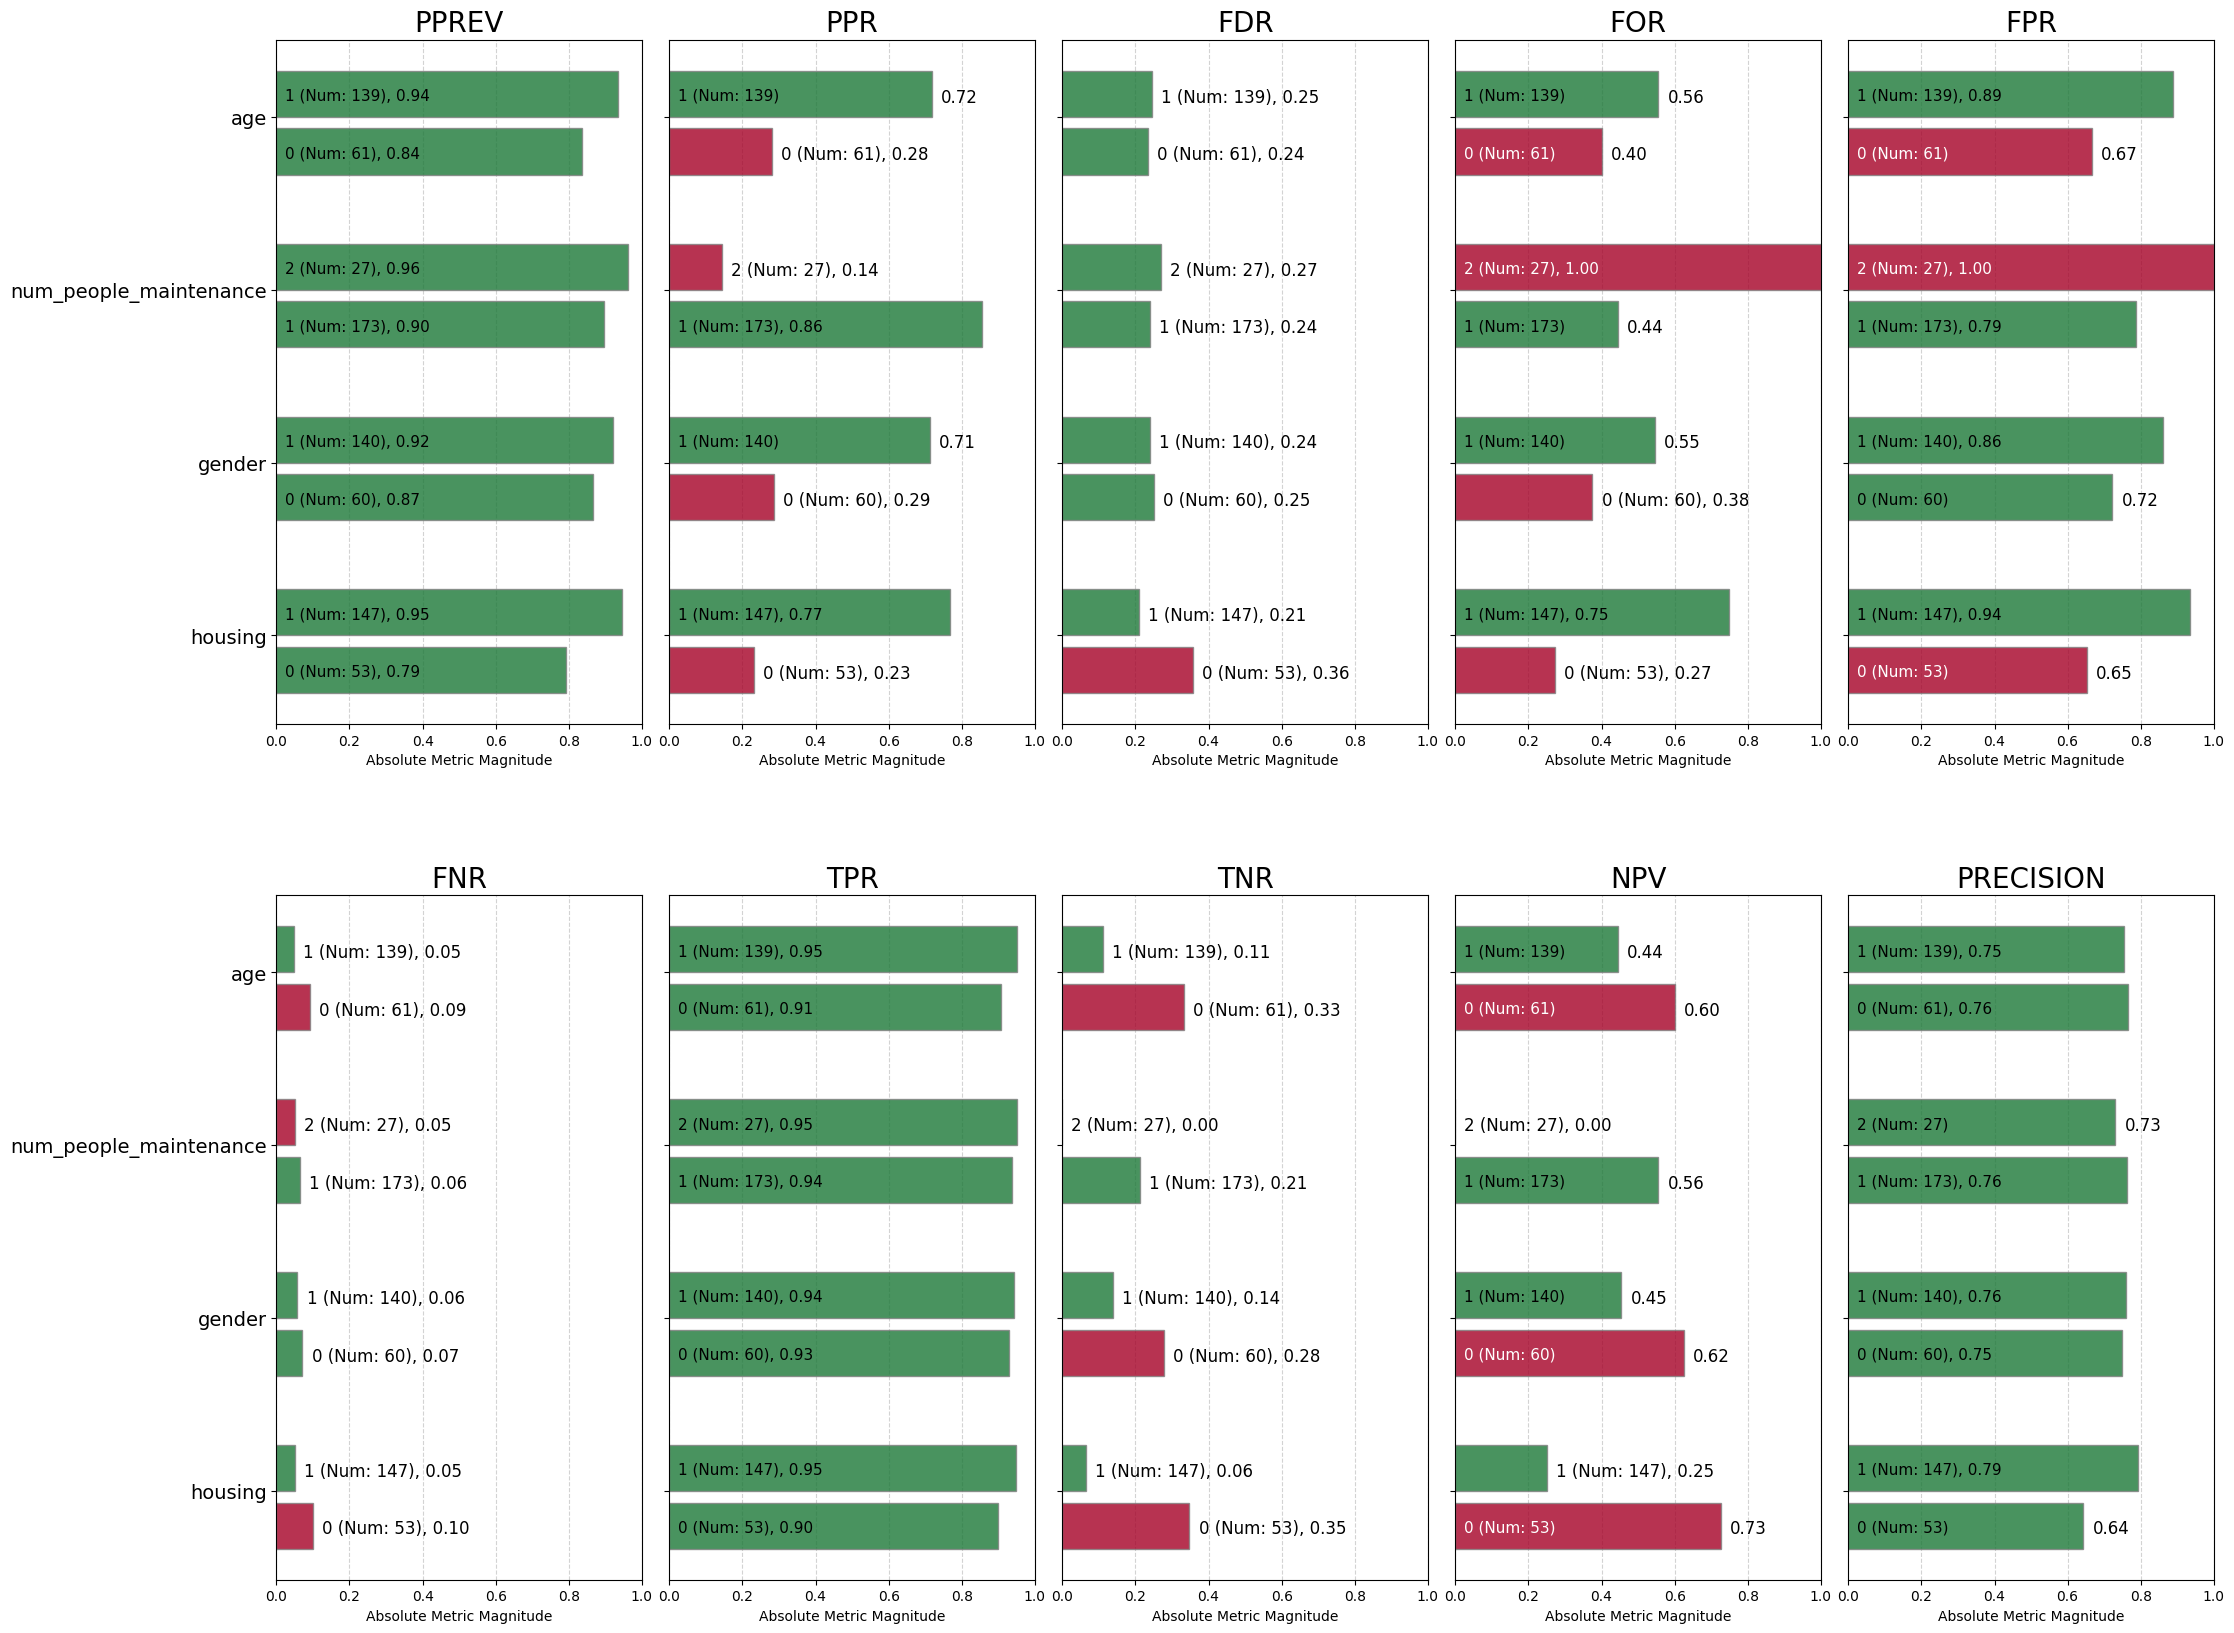

model_id score_threshold          attribute_name  Statistical Parity  \
0         0      binary 0/1                     age               False   
1         0      binary 0/1                  gender               False   
2         0      binary 0/1                 housing               False   
3         0      binary 0/1  num_people_maintenance               False   

   Impact Parity  FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  \
0           True        True       False       False       False        True   
1           True        True        True       False        True        True   
2           True       False       False       False       False        True   
3           True        True       False       False       False        True   

   TNR Parity  NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  \
0       False       False              True         False          False   
1       False       False              True          True          False   
2       False       False              True         False          False   
3       False       False              True         False          False   

   Equalized Odds  Unsupervised Fairness  Supervised Fairness  
0           False                  False                False  
1            True                  False                False  
2           False                  False                False  
3           False                  False                False

<Figure size 640x480 with 0 Axes>

In [78]:
"""
Train and calculate fairness metrics for original dataset.
"""
x_test, y_test, y_predicted_dict, metrics_dict = split_and_train(df_num,protected_attributes,target)
df_test= calc_fairness_report(x_test, y_test, y_predicted_dict['LogisticRegression'], target, protected_attributes, list_of_disparities,priv_orig,display_disp=True)

---------- Model name:  LogisticRegression ----------

Accuracy score training:
0.7275
Accuracy score test:
0.7500
----------------------------------------

Classification report for model: LogisticRegression(C=2.1, penalty='l1', random_state=7, solver='liblinear') : 
               precision    recall  f1-score   support

           0       0.59      0.24      0.34        54
           1       0.77      0.94      0.85       146

    accuracy                           0.75       200
   macro avg       0.68      0.59      0.59       200
weighted avg       0.72      0.75      0.71       200



attribute_name attribute_value  accuracy   tpr   tnr  \
0    num_people_maintenance/gender               0      0.75  0.92  0.35   
1    num_people_maintenance/gender               1      0.74  0.94  0.17   
2    num_people_maintenance/gender               2      0.67  1.00  0.00   
3    num_people_maintenance/gender               3      0.79  0.94  0.33   
4                   gender/housing               0      0.75  0.91  0.56   
5                   gender/housing               1      0.75  0.94  0.11   
6                   gender/housing               2      0.61  0.84  0.29   
7                   gender/housing               3      0.79  0.96  0.14   
8   num_people_maintenance/housing               0      0.66  0.85  0.40   
9   num_people_maintenance/housing               1      0.78  0.96  0.11   
10  num_people_maintenance/housing               2      0.67  1.00  0.33   
11  num_people_maintenance/housing               3      0.81  0.94  0.25   

     for   fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0   0.33  0.23  0.65  0.08  0.67       0.77  0.27   0.84  0.70  
1   0.50  0.24  0.83  0.06  0.50       0.76  0.60   0.91  0.74  
2    NaN  0.33  1.00  0.00   NaN       0.67  0.02   1.00  0.67  
3   0.33  0.19  0.67  0.06  0.67       0.81  0.12   0.88  0.75  
4   0.17  0.29  0.44  0.09  0.83       0.71  0.08   0.70  0.55  
5   0.67  0.22  0.89  0.06  0.33       0.78  0.21   0.92  0.78  
6   0.43  0.38  0.71  0.16  0.57       0.62  0.15   0.79  0.58  
7   0.50  0.19  0.86  0.04  0.50       0.81  0.57   0.94  0.79  
8   0.33  0.34  0.60  0.15  0.67       0.66  0.20   0.74  0.57  
9   0.57  0.20  0.89  0.04  0.43       0.80  0.67   0.94  0.79  
10  0.00  0.40  0.67  0.00  1.00       0.60  0.03   0.83  0.50  
11  0.50  0.16  0.75  0.06  0.50       0.84  0.11   0.90  0.81

Majority class for:  num_people_maintenance/gender  is: 1
Majority class for:  gender/housing  is: 3
Majority class for:  num_people_maintenance/housing  is: 1
[]


attribute_name attribute_value  fdr_disparity  \
0    num_people_maintenance/gender               0           0.97   
1    num_people_maintenance/gender               1           1.00   
2    num_people_maintenance/gender               2           1.41   
3    num_people_maintenance/gender               3           0.81   
4                   gender/housing               0           1.52   
5                   gender/housing               1           1.15   
6                   gender/housing               2           2.04   
7                   gender/housing               3           1.00   
8   num_people_maintenance/housing               0           1.70   
9   num_people_maintenance/housing               1           1.00   
10  num_people_maintenance/housing               2           1.98   
11  num_people_maintenance/housing               3           0.78   

    fnr_disparity  for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            1.29           0.67           0.78           1.33           0.45   
1            1.00           1.00           1.00           1.00           1.00   
2            0.00            NaN           1.20            NaN           0.03   
3            0.96           0.67           0.80           1.33           0.20   
4            2.58           0.33           0.51           1.67           0.14   
5            1.83           1.33           1.03           0.67           0.37   
6            4.47           0.86           0.83           1.14           0.26   
7            1.00           1.00           1.00           1.00           1.00   
8            3.67           0.58           0.68           1.56           0.29   
9            1.00           1.00           1.00           1.00           1.00   
10           0.00           0.00           0.75           2.33           0.04   
11           1.46           0.88           0.84           1.17           0.16   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              0.92                 1.01           2.12           0.98  
1              1.00                 1.00           1.00           1.00  
2              1.09                 0.87           0.00           1.06  
3              0.96                 1.06           2.00           1.00  
4              0.74                 0.88           4.07           0.94  
5              0.98                 0.97           0.81           0.97  
6              0.83                 0.76           2.10           0.87  
7              1.00                 1.00           1.00           1.00  
8              0.79                 0.82           3.60           0.89  
9              1.00                 1.00           1.00           1.00  
10             0.88                 0.75           3.00           1.04  
11             0.96                 1.05           2.25           0.98

                                fnr_disparity  for_disparity
num_people_maintenance/gender            0.75       0.670000
gender/housing                           2.96       0.840000
num_people_maintenance/housing           1.71       0.486667
Overall average for fnr_disparity:  1.807
Overall average for for_disparity:  0.666


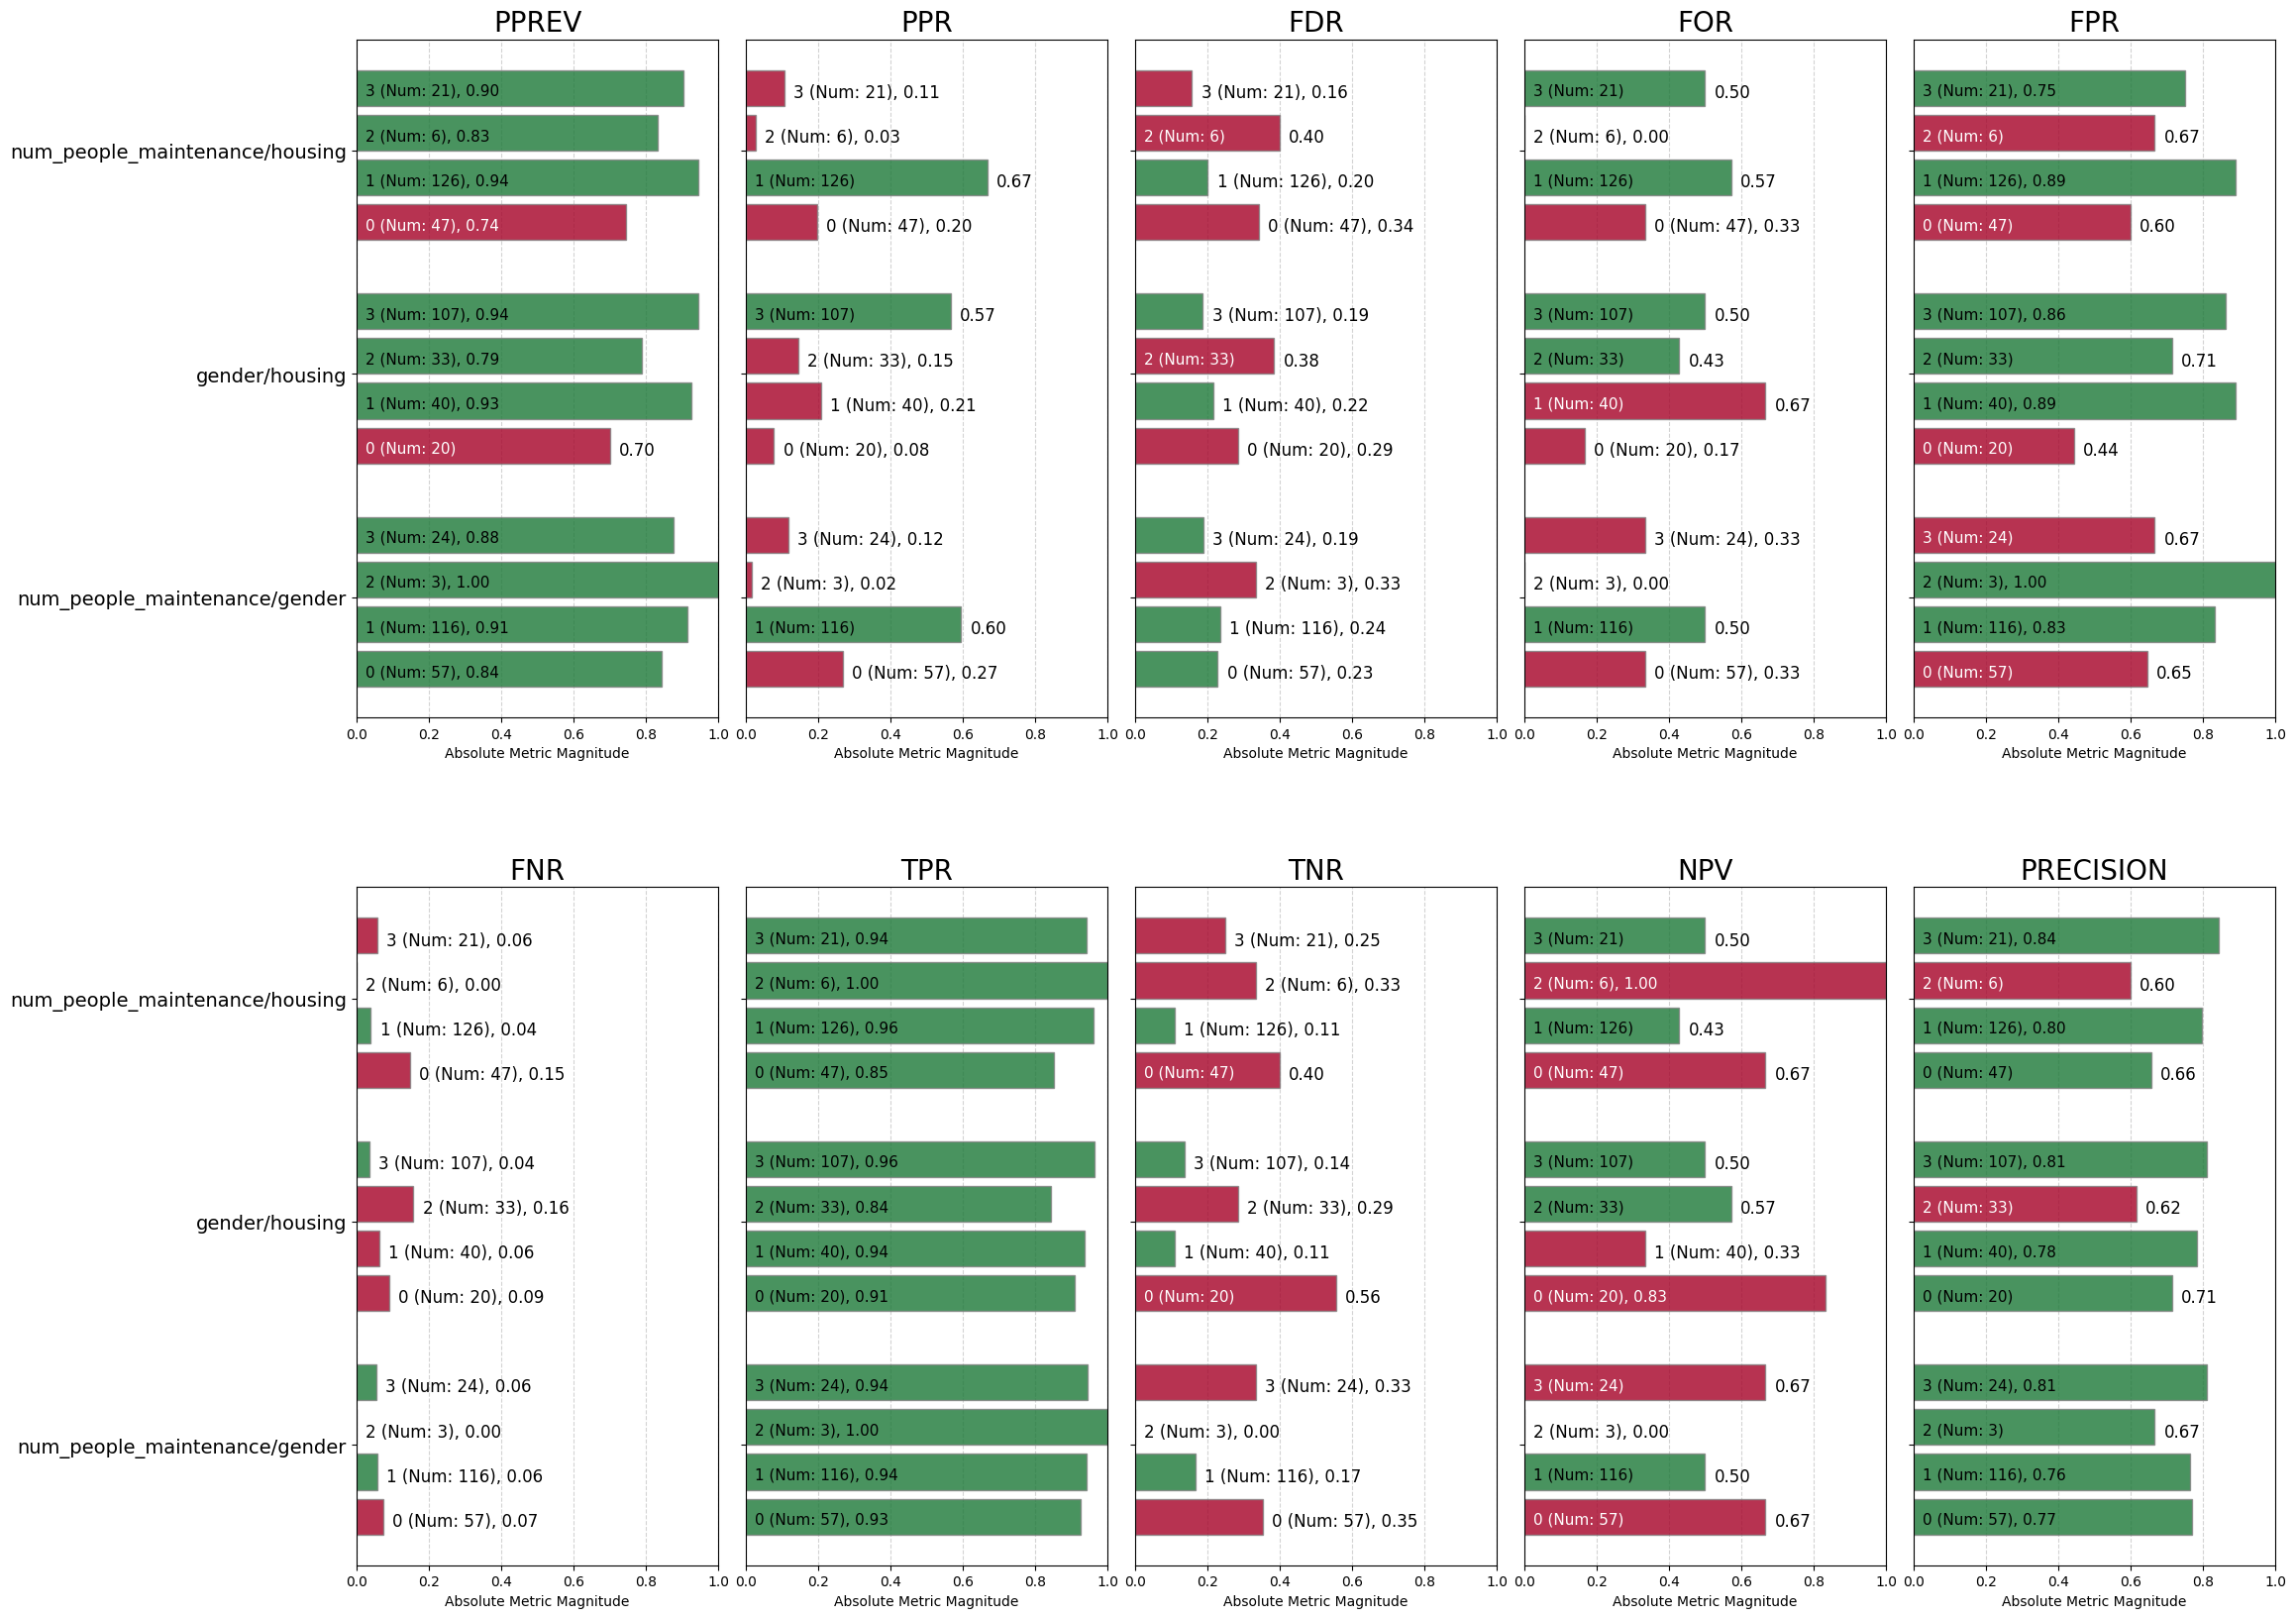

model_id score_threshold                  attribute_name  \
0         0      binary 0/1                  gender/housing   
1         0      binary 0/1   num_people_maintenance/gender   
2         0      binary 0/1  num_people_maintenance/housing   

   Statistical Parity  Impact Parity  FDR Parity  FPR Parity  FOR Parity  \
0               False          False       False       False       False   
1               False           True       False       False       False   
2               False          False       False       False       False   

   FNR Parity  TPR Parity  TNR Parity  NPV Parity  Precision Parity  \
0       False        True       False       False             False   
1       False        True       False       False              True   
2       False        True       False       False             False   

   TypeI Parity  TypeII Parity  Equalized Odds  Unsupervised Fairness  \
0         False          False           False                  False   
1         False          False           False                  False   
2         False          False           False                  False   

   Supervised Fairness  
0                False  
1                False  
2                False

<Figure size 640x480 with 0 Axes>

In [9]:
"""
Train and calculate fariness metrics for the dataset obtained by the intersection of protected attributes.
"""
x_test_int, y_test_int, y_predicted_dict_int, metrics_dict_int = split_and_train(df_num_int,protected_attributes_int,target)
df_test_int= calc_fairness_report(x_test_int, y_test_int, y_predicted_dict_int['LogisticRegression'], target, protected_attributes_int, list_of_disparities,priv, display_disp=True)

In [ ]:
plot_audit(df_test, protected_attributes)
plot_audit(df_test_int, protected_attributes_int)

---------- Model name:  LogisticRegression ----------

Accuracy score training:
0.8200
Accuracy score test:
0.8200
----------------------------------------

Classification report for model: LogisticRegression(C=2.1, penalty='l1', random_state=7, solver='liblinear') : 
               precision    recall  f1-score   support

           0       0.75      0.54      0.62        56
           1       0.84      0.93      0.88       144

    accuracy                           0.82       200
   macro avg       0.79      0.73      0.75       200
weighted avg       0.81      0.82      0.81       200



attribute_name attribute_value  accuracy   tpr   tnr  \
0    num_people_maintenance/gender               0      0.84  0.93  0.60   
1    num_people_maintenance/gender               1      0.83  0.94  0.57   
2    num_people_maintenance/gender               2      0.67  0.67   NaN   
3    num_people_maintenance/gender               3      0.75  0.94  0.17   
4                   gender/housing               0      0.85  0.92  0.71   
5                   gender/housing               1      0.82  0.91  0.50   
6                   gender/housing               2      0.76  0.91  0.45   
7                   gender/housing               3      0.83  0.95  0.53   
8   num_people_maintenance/housing               0      0.81  0.90  0.62   
9   num_people_maintenance/housing               1      0.84  0.95  0.56   
10  num_people_maintenance/housing               2      0.67  1.00  0.00   
11  num_people_maintenance/housing               3      0.76  0.88  0.25   

     for   fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0   0.25  0.13  0.40  0.07  0.75       0.87  0.28   0.79  0.74  
1   0.20  0.16  0.43  0.06  0.80       0.84  0.57   0.78  0.70  
2   1.00  0.00   NaN  0.33  0.00       1.00  0.01   0.67  1.00  
3   0.50  0.23  0.83  0.06  0.50       0.77  0.14   0.92  0.75  
4   0.17  0.14  0.29  0.08  0.83       0.86  0.09   0.70  0.65  
5   0.43  0.12  0.50  0.09  0.57       0.88  0.21   0.82  0.80  
6   0.29  0.23  0.55  0.09  0.71       0.77  0.16   0.79  0.67  
7   0.20  0.16  0.47  0.05  0.80       0.84  0.54   0.81  0.72  
8   0.23  0.18  0.38  0.10  0.77       0.82  0.21   0.72  0.66  
9   0.21  0.15  0.44  0.05  0.79       0.85  0.64   0.81  0.73  
10   NaN  0.33  1.00  0.00   NaN       0.67  0.04   1.00  0.67  
11  0.67  0.17  0.75  0.12  0.33       0.83  0.11   0.86  0.81

Majority class for:  num_people_maintenance/gender  is: 1
Majority class for:  gender/housing  is: 3
Majority class for:  num_people_maintenance/housing  is: 1
[]


attribute_name attribute_value  fdr_disparity  \
0    num_people_maintenance/gender               0           0.81   
1    num_people_maintenance/gender               1           1.00   
2    num_people_maintenance/gender               2           0.00   
3    num_people_maintenance/gender               3           1.38   
4                   gender/housing               0           0.89   
5                   gender/housing               1           0.75   
6                   gender/housing               2           1.43   
7                   gender/housing               3           1.00   
8   num_people_maintenance/housing               0           1.20   
9   num_people_maintenance/housing               1           1.00   
10  num_people_maintenance/housing               2           2.27   
11  num_people_maintenance/housing               3           1.13   

    fnr_disparity  for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            1.16           1.25           0.93           0.94           0.49   
1            1.00           1.00           1.00           1.00           1.00   
2            5.40           5.00            NaN           0.00           0.02   
3            0.90           2.50           1.94           0.62           0.24   
4            1.48           0.83           0.61           1.04           0.16   
5            1.80           2.14           1.07           0.71           0.38   
6            1.75           1.43           1.17           0.89           0.30   
7            1.00           1.00           1.00           1.00           1.00   
8            1.78           1.11           0.85           0.97           0.33   
9            1.00           1.00           1.00           1.00           1.00   
10           0.00            NaN           2.27            NaN           0.06   
11           2.16           3.20           1.70           0.42           0.18   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              1.01                 1.04           1.05           0.99  
1              1.00                 1.00           1.00           1.00  
2              0.85                 1.20            NaN           0.71  
3              1.17                 0.93           0.29           1.01  
4              0.86                 1.02           1.34           0.97  
5              1.01                 1.05           0.94           0.96  
6              0.97                 0.92           0.85           0.96  
7              1.00                 1.00           1.00           1.00  
8              0.89                 0.97           1.12           0.96  
9              1.00                 1.00           1.00           1.00  
10             1.24                 0.78           0.00           1.06  
11             1.06                 0.98           0.45           0.93

                                fnr_disparity  for_disparity
num_people_maintenance/gender        2.486667       2.916667
gender/housing                       1.676667       1.466667
num_people_maintenance/housing       1.313333       2.155000
Overall average for fnr_disparity:  1.826
Overall average for for_disparity:  2.179


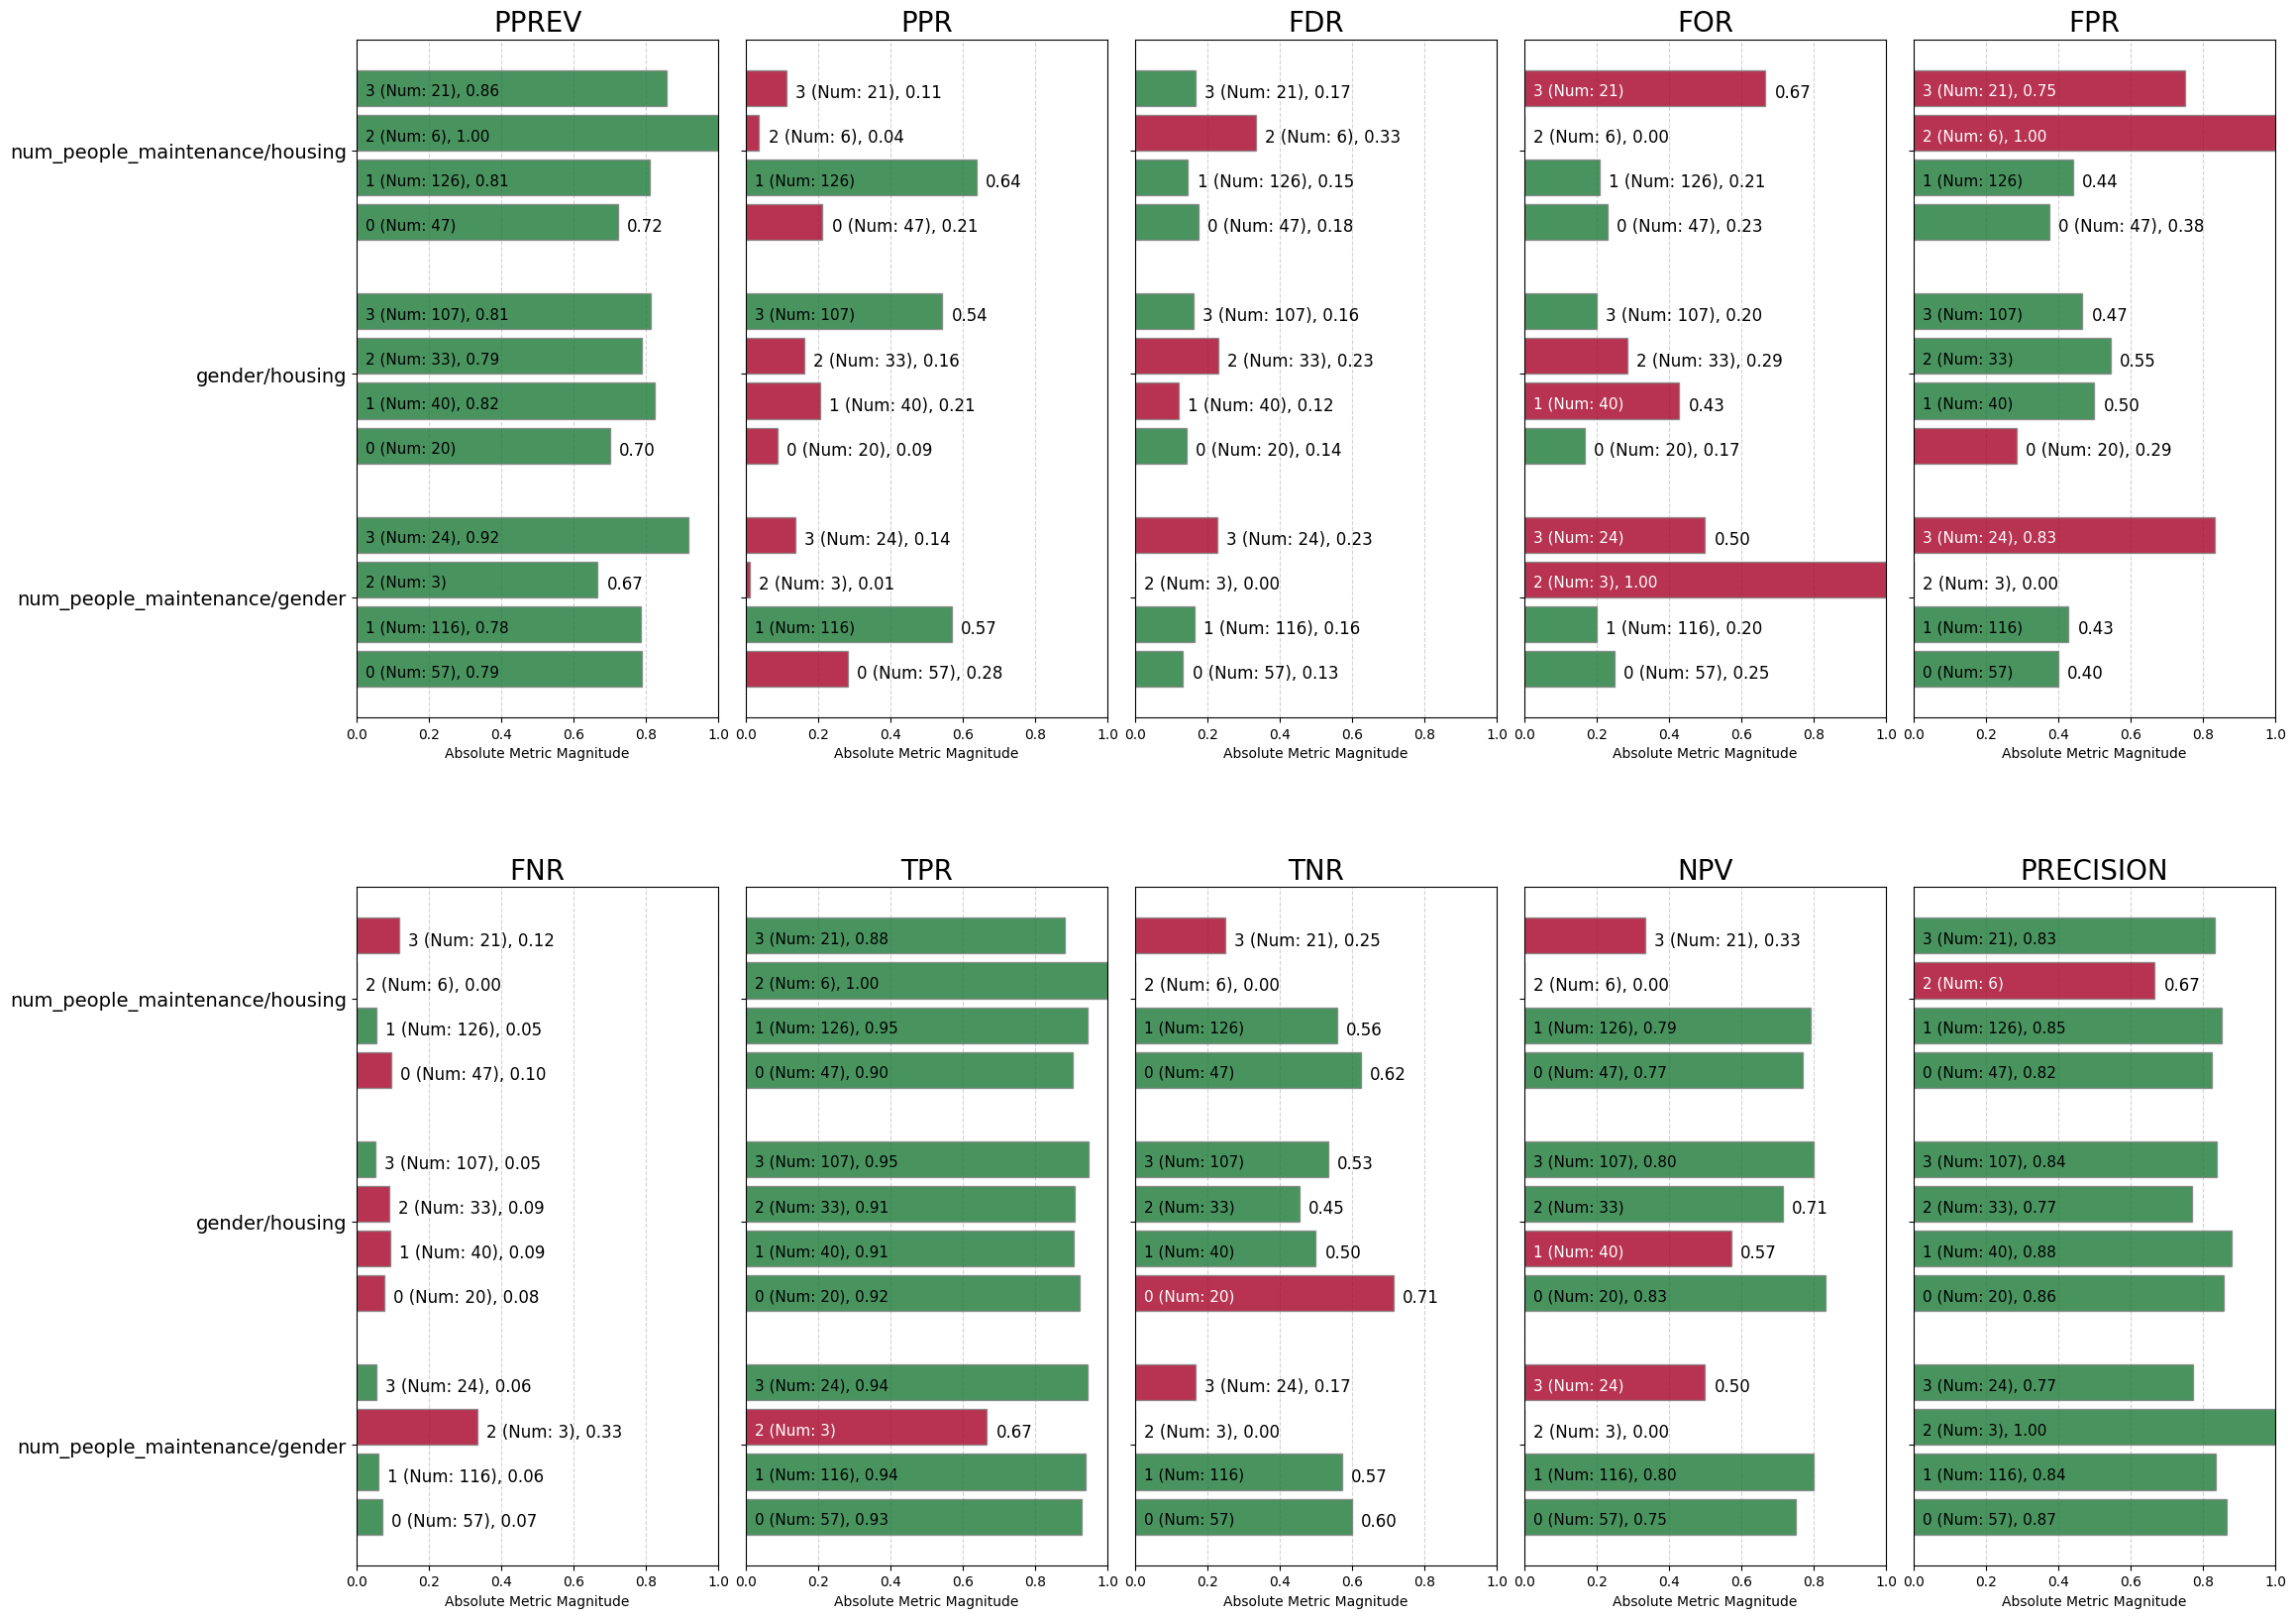

model_id score_threshold                  attribute_name  \
0         0      binary 0/1                  gender/housing   
1         0      binary 0/1   num_people_maintenance/gender   
2         0      binary 0/1  num_people_maintenance/housing   

   Statistical Parity  Impact Parity  FDR Parity  FPR Parity  FOR Parity  \
0               False           True       False       False       False   
1               False           True       False       False       False   
2               False           True       False       False       False   

   FNR Parity  TPR Parity  TNR Parity  NPV Parity  Precision Parity  \
0       False        True       False       False              True   
1       False       False       False       False              True   
2       False        True       False       False             False   

   TypeI Parity  TypeII Parity  Equalized Odds  Unsupervised Fairness  \
0         False          False           False                  False   
1         False          False           False                  False   
2         False          False           False                  False   

   Supervised Fairness  
0                False  
1                False  
2                False

<Figure size 640x480 with 0 Axes>

In [80]:
'''
1: Massaging method (Flips selected labels to reduce prevalence disparity between groups), train and calculate metrics.
'''
#transform data
data_to_transform = df_num_int.copy()
data_transformed_m = prep_massaging(df_num_int, protected_attributes_int,target)

#train on the transformed dataset
x_test_ms, y_test_ms, y_predicted_dict_transformed, metrics_ms_dict = split_and_train(data_transformed_m,protected_attributes_int,target)
#calculate the fairness report
df_test_transformed=calc_fairness_report(x_test_ms, y_test_ms, y_predicted_dict_transformed["LogisticRegression"],target,protected_attributes_int, list_of_disparities,priv, display_disp=True)

# plot_audit(df_test_int,protected_attributes_int)
# plot_audit(df_test_transformed,protected_attributes_int)


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Original group 0 size: 296


INFO:methods.preprocessing.PrevalenceSampling:Original group 0 size: 296


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Final group 0 size: 343


INFO:methods.preprocessing.PrevalenceSampling:Final group 0 size: 343


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Original group 1 size: 549


INFO:methods.preprocessing.PrevalenceSampling:Original group 1 size: 549


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Final group 1 size: 569


INFO:methods.preprocessing.PrevalenceSampling:Final group 1 size: 569


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Original group 3 size: 141


INFO:methods.preprocessing.PrevalenceSampling:Original group 3 size: 141


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Final group 3 size: 144


INFO:methods.preprocessing.PrevalenceSampling:Final group 3 size: 144


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Original group 2 size: 14


INFO:methods.preprocessing.PrevalenceSampling:Original group 2 size: 14


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Final group 2 size: 20


INFO:methods.preprocessing.PrevalenceSampling:Final group 2 size: 20


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Original group 1 size: 235


INFO:methods.preprocessing.PrevalenceSampling:Original group 1 size: 235


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Final group 1 size: 251


INFO:methods.preprocessing.PrevalenceSampling:Final group 1 size: 251


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Original group 3 size: 536


INFO:methods.preprocessing.PrevalenceSampling:Original group 3 size: 536


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Final group 3 size: 564


INFO:methods.preprocessing.PrevalenceSampling:Final group 3 size: 564


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Original group 0 size: 128


INFO:methods.preprocessing.PrevalenceSampling:Original group 0 size: 128


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Final group 0 size: 184


INFO:methods.preprocessing.PrevalenceSampling:Final group 0 size: 184


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Original group 2 size: 177


INFO:methods.preprocessing.PrevalenceSampling:Original group 2 size: 177


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Final group 2 size: 227


INFO:methods.preprocessing.PrevalenceSampling:Final group 2 size: 227


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Original group 1 size: 701


INFO:methods.preprocessing.PrevalenceSampling:Original group 1 size: 701


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Final group 1 size: 743


INFO:methods.preprocessing.PrevalenceSampling:Final group 1 size: 743


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Original group 0 size: 351


INFO:methods.preprocessing.PrevalenceSampling:Original group 0 size: 351


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Final group 0 size: 369


INFO:methods.preprocessing.PrevalenceSampling:Final group 0 size: 369


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Original group 2 size: 60


INFO:methods.preprocessing.PrevalenceSampling:Original group 2 size: 60


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Final group 2 size: 90


INFO:methods.preprocessing.PrevalenceSampling:Final group 2 size: 90


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Original group 3 size: 114


INFO:methods.preprocessing.PrevalenceSampling:Original group 3 size: 114


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Final group 3 size: 125


INFO:methods.preprocessing.PrevalenceSampling:Final group 3 size: 125


[INFO] 2024-11-20 19:28:05 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


---------- Model name:  LogisticRegression ----------

Accuracy score training:
0.7191
Accuracy score test:
0.7143
----------------------------------------

Classification report for model: LogisticRegression(C=2.1, penalty='l1', random_state=7, solver='liblinear') : 
               precision    recall  f1-score   support

           0       0.48      0.17      0.25        75
           1       0.74      0.93      0.82       191

    accuracy                           0.71       266
   macro avg       0.61      0.55      0.54       266
weighted avg       0.67      0.71      0.66       266



attribute_name attribute_value  accuracy   tpr   tnr  \
0    num_people_maintenance/gender               0      0.74  1.00  0.12   
1    num_people_maintenance/gender               1      0.67  0.88  0.16   
2    num_people_maintenance/gender               2      0.80  1.00  0.00   
3    num_people_maintenance/gender               3      0.83  0.91  0.50   
4                   gender/housing               0      0.70  1.00  0.23   
5                   gender/housing               1      0.77  1.00  0.00   
6                   gender/housing               2      0.74  0.90  0.23   
7                   gender/housing               3      0.68  0.88  0.19   
8   num_people_maintenance/housing               0      0.72  0.92  0.26   
9   num_people_maintenance/housing               1      0.69  0.93  0.09   
10  num_people_maintenance/housing               2      0.75  1.00  0.00   
11  num_people_maintenance/housing               3      0.86  0.89  0.75   

     for   fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0   0.00  0.27  0.88  0.00  1.00       0.73  0.34   0.96  0.71  
1   0.63  0.28  0.84  0.12  0.37       0.72  0.54   0.87  0.71  
2    NaN  0.20  1.00  0.00   NaN       0.80  0.02   1.00  0.80  
3   0.40  0.12  0.50  0.09  0.60       0.88  0.10   0.83  0.79  
4   0.00  0.33  0.77  0.00  1.00       0.67  0.13   0.91  0.61  
5    NaN  0.23  1.00  0.00   NaN       0.77  0.24   1.00  0.77  
6   0.57  0.21  0.77  0.10  0.43       0.79  0.20   0.87  0.76  
7   0.59  0.28  0.81  0.12  0.41       0.72  0.44   0.86  0.70  
8   0.40  0.26  0.74  0.08  0.60       0.74  0.27   0.87  0.69  
9   0.67  0.28  0.91  0.07  0.33       0.72  0.61   0.92  0.71  
10   NaN  0.25  1.00  0.00   NaN       0.75  0.05   1.00  0.75  
11  0.40  0.06  0.25  0.11  0.60       0.94  0.07   0.77  0.82

Majority class for:  num_people_maintenance/gender  is: 1
Majority class for:  gender/housing  is: 3
Majority class for:  num_people_maintenance/housing  is: 1
[]


attribute_name attribute_value  fdr_disparity  \
0    num_people_maintenance/gender               0           0.95   
1    num_people_maintenance/gender               1           1.00   
2    num_people_maintenance/gender               2           0.71   
3    num_people_maintenance/gender               3           0.44   
4                   gender/housing               0           1.21   
5                   gender/housing               1           0.83   
6                   gender/housing               2           0.77   
7                   gender/housing               3           1.00   
8   num_people_maintenance/housing               0           0.92   
9   num_people_maintenance/housing               1           1.00   
10  num_people_maintenance/housing               2           0.88   
11  num_people_maintenance/housing               3           0.21   

    fnr_disparity  for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            0.00           0.00           1.05           2.71           0.64   
1            1.00           1.00           1.00           1.00           1.00   
2            0.00            NaN           1.19            NaN           0.04   
3            0.75           0.63           0.60           1.63           0.19   
4            0.00           0.00           0.95           2.43           0.29   
5            0.00            NaN           1.24            NaN           0.54   
6            0.84           0.97           0.95           1.04           0.45   
7            1.00           1.00           1.00           1.00           1.00   
8            1.08           0.60           0.81           1.80           0.45   
9            1.00           1.00           1.00           1.00           1.00   
10           0.00            NaN           1.10            NaN           0.08   
11           1.56           0.60           0.27           1.80           0.12   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              1.11                 1.02           0.74           1.13  
1              1.00                 1.00           1.00           1.00  
2              1.15                 1.11           0.00           1.13  
3              0.95                 1.22           3.07           1.03  
4              1.06                 0.92           1.19           1.13  
5              1.16                 1.07           0.00           1.13  
6              1.01                 1.09           1.19           1.02  
7              1.00                 1.00           1.00           1.00  
8              0.94                 1.03           2.93           0.99  
9              1.00                 1.00           1.00           1.00  
10             1.08                 1.05           0.00           1.08  
11             0.84                 1.31           8.44           0.96

                                fnr_disparity  for_disparity
num_people_maintenance/gender            0.25          0.315
gender/housing                           0.28          0.485
num_people_maintenance/housing           0.88          0.600
Overall average for fnr_disparity:  0.470
Overall average for for_disparity:  0.467


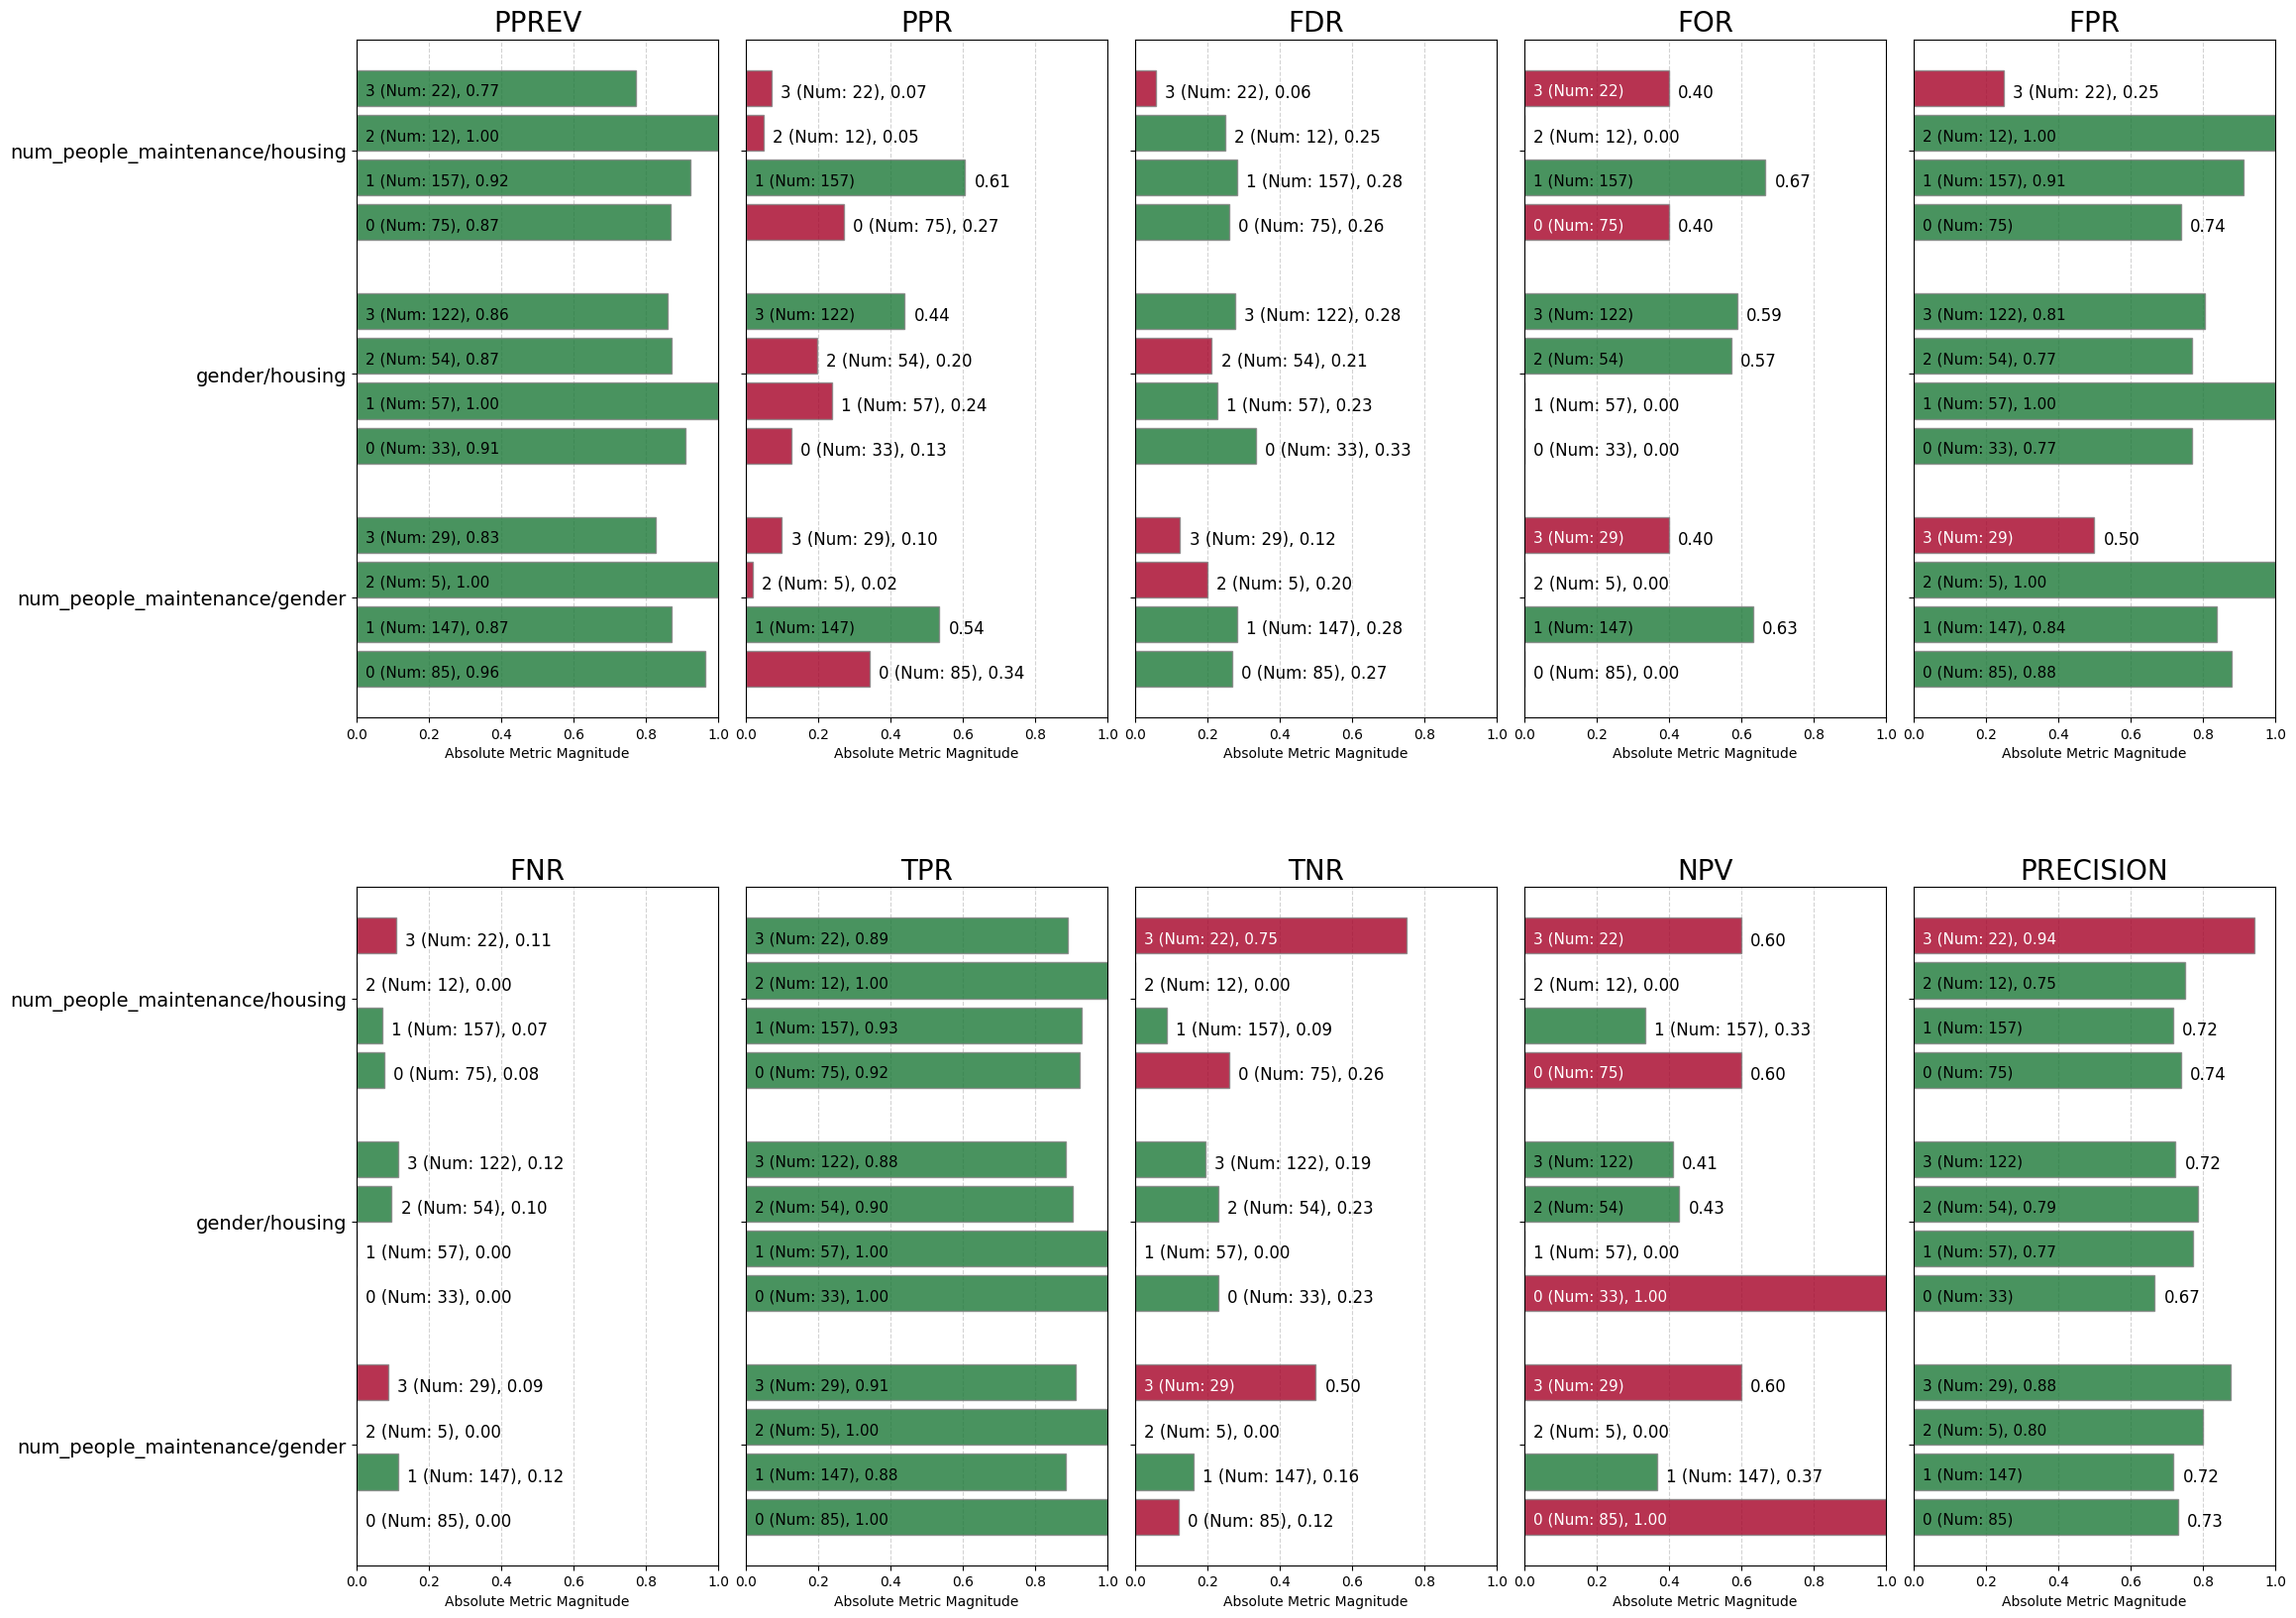

model_id score_threshold                  attribute_name  \
0         0      binary 0/1                  gender/housing   
1         0      binary 0/1   num_people_maintenance/gender   
2         0      binary 0/1  num_people_maintenance/housing   

   Statistical Parity  Impact Parity  FDR Parity  FPR Parity  FOR Parity  \
0               False           True       False        True       False   
1               False           True       False       False       False   
2               False           True       False       False       False   

   FNR Parity  TPR Parity  TNR Parity  NPV Parity  Precision Parity  \
0       False        True       False       False              True   
1       False        True       False       False              True   
2       False        True       False       False             False   

   TypeI Parity  TypeII Parity  Equalized Odds  Unsupervised Fairness  \
0         False          False            True                  False   
1         False          False           False                  False   
2         False          False           False                  False   

   Supervised Fairness  
0                False  
1                False  
2                False

<Figure size 640x480 with 0 Axes>

In [89]:
''' 
2: Prevalance Sampling: Generates a training sample with controllable balanced prevalence for the groups in dataset, either by undersampling or oversampling.
'''
#transform data
data_to_transform = df_num_int.copy()
data_transformed_ps = prep_prev_sampling(df_num_int, protected_attributes_int,target)

#train the new dataset
x_test_ps, y_test_ps, y_predicted_dict_ps, metrics_ps_dict = split_and_train(data_transformed_ps,protected_attributes_int,target)
df_test_transformed_ps =calc_fairness_report(x_test_ps, y_test_ps, y_predicted_dict_ps["LogisticRegression"],target,protected_attributes_int, list_of_disparities,priv, display_disp=True)

#compare disparities
# plot_audit(df_test_int, protected_attributes_int)
# plot_audit(df_test_transformed_ps, protected_attributes_int)

---------- Model name:  LogisticRegression ----------

Accuracy score training:
0.7225
Accuracy score test:
0.7550
----------------------------------------

Classification report for model: LogisticRegression(C=2.1, penalty='l1', random_state=7, solver='liblinear') : 
               precision    recall  f1-score   support

           0       0.65      0.20      0.31        54
           1       0.77      0.96      0.85       146

    accuracy                           0.76       200
   macro avg       0.71      0.58      0.58       200
weighted avg       0.73      0.76      0.70       200



attribute_name attribute_value  accuracy   tpr   tnr  \
0    num_people_maintenance/gender               0      0.79  0.95  0.41   
1    num_people_maintenance/gender               1      0.74  0.95  0.13   
2    num_people_maintenance/gender               2      0.67  1.00  0.00   
3    num_people_maintenance/gender               3      0.75  1.00  0.00   
4                   gender/housing               0      0.75  0.91  0.56   
5                   gender/housing               1      0.80  0.97  0.22   
6                   gender/housing               2      0.58  0.89  0.14   
7                   gender/housing               3      0.79  0.98  0.09   
8   num_people_maintenance/housing               0      0.66  0.89  0.35   
9   num_people_maintenance/housing               1      0.79  0.97  0.15   
10  num_people_maintenance/housing               2      0.50  1.00  0.00   
11  num_people_maintenance/housing               3      0.81  1.00  0.00   

     for   fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0   0.22  0.21  0.59  0.05  0.78       0.79  0.26   0.84  0.70  
1   0.50  0.24  0.87  0.05  0.50       0.76  0.59   0.93  0.74  
2    NaN  0.33  1.00  0.00   NaN       0.67  0.02   1.00  0.67  
3    NaN  0.25  1.00  0.00   NaN       0.75  0.13   1.00  0.75  
4   0.17  0.29  0.44  0.09  0.83       0.71  0.08   0.70  0.55  
5   0.33  0.19  0.78  0.03  0.67       0.81  0.20   0.92  0.78  
6   0.50  0.41  0.86  0.11  0.50       0.59  0.16   0.88  0.58  
7   0.50  0.19  0.91  0.02  0.50       0.81  0.56   0.96  0.79  
8   0.30  0.35  0.65  0.11  0.70       0.65  0.20   0.79  0.57  
9   0.43  0.19  0.85  0.03  0.57       0.81  0.65   0.94  0.79  
10   NaN  0.50  1.00  0.00   NaN       0.50  0.03   1.00  0.50  
11   NaN  0.19  1.00  0.00   NaN       0.81  0.11   1.00  0.81

Majority class for:  num_people_maintenance/gender  is: 1
Majority class for:  gender/housing  is: 3
Majority class for:  num_people_maintenance/housing  is: 1
[]


attribute_name attribute_value  fdr_disparity  \
0    num_people_maintenance/gender               0           0.87   
1    num_people_maintenance/gender               1           1.00   
2    num_people_maintenance/gender               2           1.38   
3    num_people_maintenance/gender               3           1.04   
4                   gender/housing               0           1.47   
5                   gender/housing               1           0.97   
6                   gender/housing               2           2.13   
7                   gender/housing               3           1.00   
8   num_people_maintenance/housing               0           1.82   
9   num_people_maintenance/housing               1           1.00   
10  num_people_maintenance/housing               2           2.59   
11  num_people_maintenance/housing               3           0.99   

    fnr_disparity  for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            1.08           0.44           0.68           1.56           0.44   
1            1.00           1.00           1.00           1.00           1.00   
2            0.00            NaN           1.15            NaN           0.03   
3            0.00            NaN           1.15            NaN           0.22   
4            3.86           0.33           0.49           1.67           0.14   
5            1.37           0.67           0.86           1.33           0.36   
6            4.47           1.00           0.94           1.00           0.28   
7            1.00           1.00           1.00           1.00           1.00   
8            3.67           0.70           0.76           1.23           0.31   
9            1.00           1.00           1.00           1.00           1.00   
10           0.00            NaN           1.17            NaN           0.05   
11           0.00            NaN           1.17            NaN           0.18   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              0.90                 1.04           3.09           1.00  
1              1.00                 1.00           1.00           1.00  
2              1.07                 0.88           0.00           1.05  
3              1.07                 0.99           0.00           1.05  
4              0.73                 0.89           6.11           0.93  
5              0.96                 1.01           2.44           0.99  
6              0.91                 0.73           1.57           0.92  
7              1.00                 1.00           1.00           1.00  
8              0.83                 0.80           2.36           0.92  
9              1.00                 1.00           1.00           1.00  
10             1.06                 0.62           0.00           1.03  
11             1.06                 1.00           0.00           1.03

                                fnr_disparity  for_disparity
num_people_maintenance/gender        0.360000       0.440000
gender/housing                       3.233333       0.666667
num_people_maintenance/housing       1.223333       0.700000
Overall average for fnr_disparity:  1.606
Overall average for for_disparity:  0.602


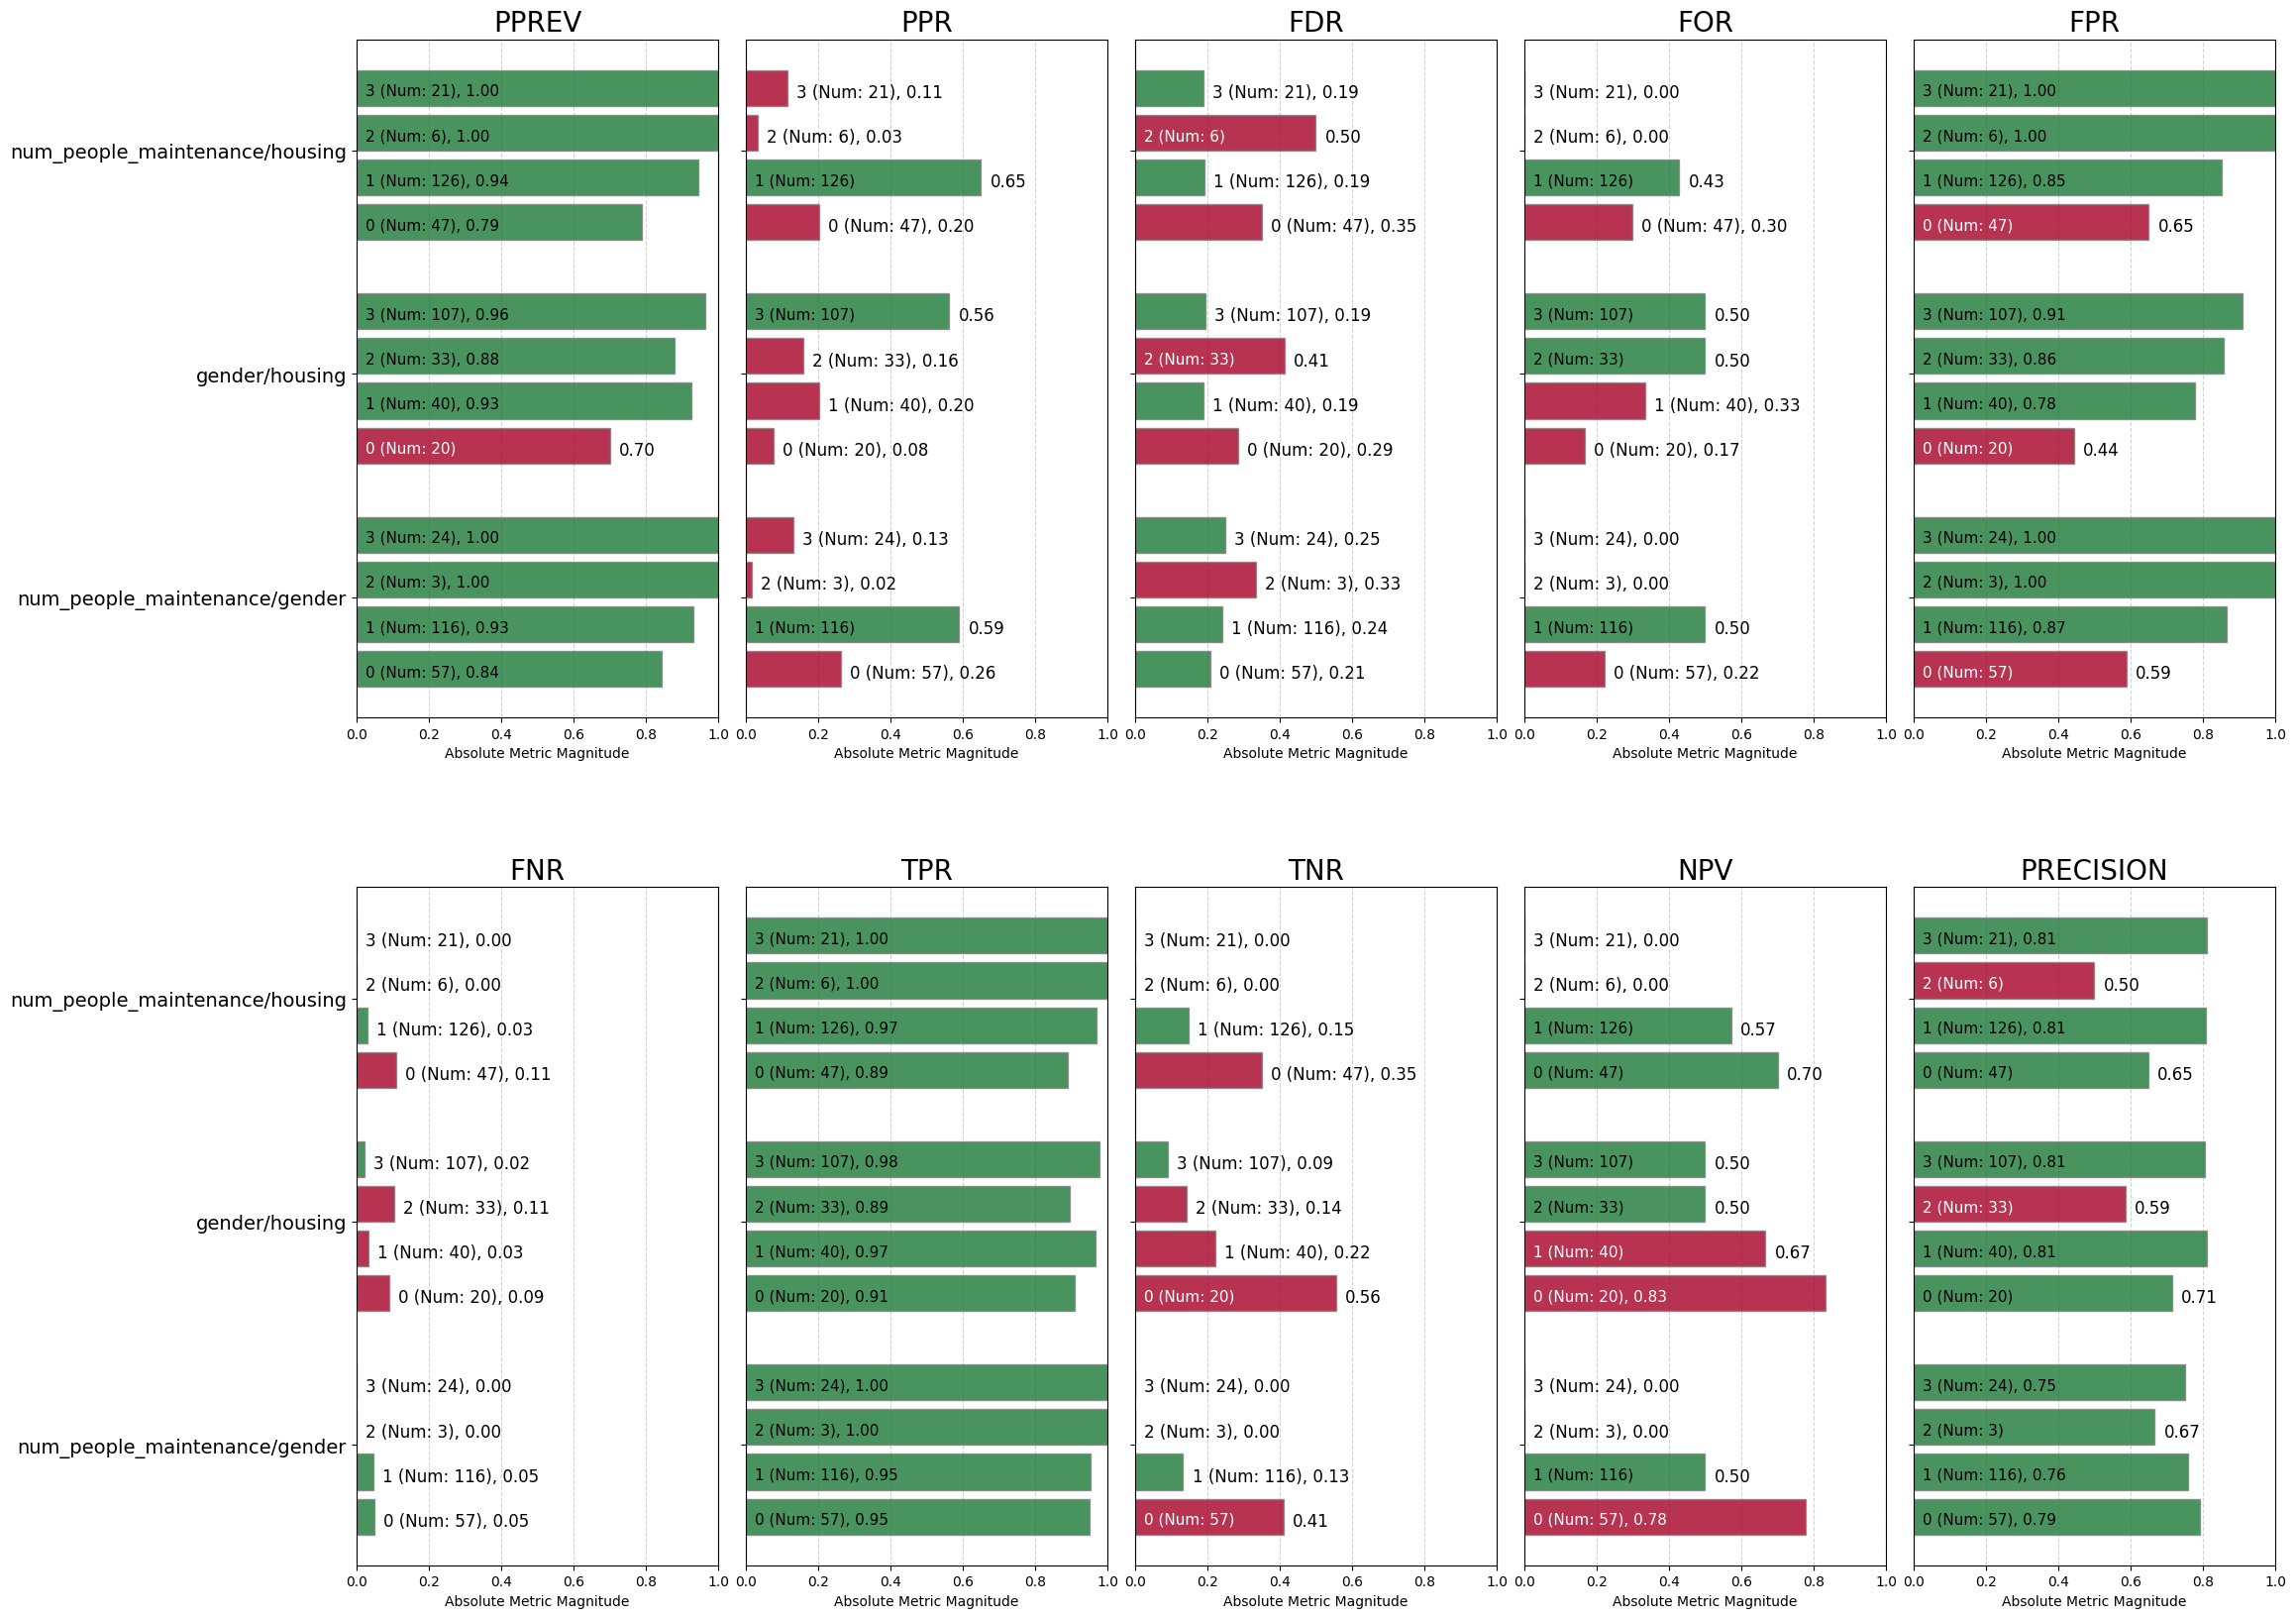

model_id score_threshold                  attribute_name  \
0         0      binary 0/1                  gender/housing   
1         0      binary 0/1   num_people_maintenance/gender   
2         0      binary 0/1  num_people_maintenance/housing   

   Statistical Parity  Impact Parity  FDR Parity  FPR Parity  FOR Parity  \
0               False          False       False       False       False   
1               False           True       False       False       False   
2               False           True       False       False       False   

   FNR Parity  TPR Parity  TNR Parity  NPV Parity  Precision Parity  \
0       False        True       False       False             False   
1       False        True       False       False              True   
2       False        True       False        True             False   

   TypeI Parity  TypeII Parity  Equalized Odds  Unsupervised Fairness  \
0         False          False           False                  False   
1         False          False           False                  False   
2         False          False           False                  False   

   Supervised Fairness  
0                False  
1                False  
2                False

<Figure size 640x480 with 0 Axes>

In [90]:
'''
3. Data repairer: Transforms the data distribution so that a given feature distribution is marginally independent of the sensitive attribute, s. 
'''

#transform data
data_to_transform = df_num_int.copy()
data_transformed_dr = prep_data_repairer(df_num_int,protected_attributes_int,target)

#train
x_test_dr, y_test_dr, y_predicted_dict_dr, metrics_dr_dict = split_and_train(data_transformed_dr,protected_attributes_int,target)

#calc metrics
df_test_transformed_dr =calc_fairness_report(x_test_dr, y_test_dr, y_predicted_dict_dr["LogisticRegression"],target,protected_attributes_int,list_of_disparities,priv, display_disp=True)

#compare disparities
# plot_audit(df_test_int, protected_attributes_int)
# plot_audit(df_test_transformed_dr, protected_attributes_int)


[INFO] 2024-11-20 19:30:32 methods.preprocessing.LabelFlipping - Instantiating a LabelFlipping preprocessing method.


INFO:methods.preprocessing.LabelFlipping:Instantiating a LabelFlipping preprocessing method.


[INFO] 2024-11-20 19:30:32 methods.preprocessing.LabelFlipping - Fitting LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Fitting LabelFlipping.


[INFO] 2024-11-20 19:30:32 methods.preprocessing.LabelFlipping - Transforming data with LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Transforming data with LabelFlipping.


[INFO] 2024-11-20 19:30:32 methods.preprocessing.LabelFlipping - Flipped 13 instances.


INFO:methods.preprocessing.LabelFlipping:Flipped 13 instances.


[INFO] 2024-11-20 19:30:32 methods.preprocessing.LabelFlipping - Data transformed.


INFO:methods.preprocessing.LabelFlipping:Data transformed.


[INFO] 2024-11-20 19:30:32 methods.preprocessing.LabelFlipping - Instantiating a LabelFlipping preprocessing method.


INFO:methods.preprocessing.LabelFlipping:Instantiating a LabelFlipping preprocessing method.


[INFO] 2024-11-20 19:30:32 methods.preprocessing.LabelFlipping - Fitting LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Fitting LabelFlipping.


[INFO] 2024-11-20 19:30:32 methods.preprocessing.LabelFlipping - Transforming data with LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Transforming data with LabelFlipping.


[INFO] 2024-11-20 19:30:32 methods.preprocessing.LabelFlipping - Flipped 33 instances.


INFO:methods.preprocessing.LabelFlipping:Flipped 33 instances.


[INFO] 2024-11-20 19:30:32 methods.preprocessing.LabelFlipping - Data transformed.


INFO:methods.preprocessing.LabelFlipping:Data transformed.


[INFO] 2024-11-20 19:30:32 methods.preprocessing.LabelFlipping - Instantiating a LabelFlipping preprocessing method.


INFO:methods.preprocessing.LabelFlipping:Instantiating a LabelFlipping preprocessing method.


[INFO] 2024-11-20 19:30:32 methods.preprocessing.LabelFlipping - Fitting LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Fitting LabelFlipping.


[INFO] 2024-11-20 19:30:33 methods.preprocessing.LabelFlipping - Transforming data with LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Transforming data with LabelFlipping.


[INFO] 2024-11-20 19:30:33 methods.preprocessing.LabelFlipping - Flipped 18 instances.


INFO:methods.preprocessing.LabelFlipping:Flipped 18 instances.


[INFO] 2024-11-20 19:30:33 methods.preprocessing.LabelFlipping - Data transformed.


INFO:methods.preprocessing.LabelFlipping:Data transformed.


---------- Model name:  LogisticRegression ----------

Accuracy score training:
0.7600
Accuracy score test:
0.7800
----------------------------------------

Classification report for model: LogisticRegression(C=2.1, penalty='l1', random_state=7, solver='liblinear') : 
               precision    recall  f1-score   support

           0       0.58      0.23      0.33        47
           1       0.80      0.95      0.87       153

    accuracy                           0.78       200
   macro avg       0.69      0.59      0.60       200
weighted avg       0.75      0.78      0.74       200



attribute_name attribute_value  accuracy   tpr   tnr  \
0    num_people_maintenance/gender               0      0.77  0.95  0.27   
1    num_people_maintenance/gender               1      0.79  0.96  0.23   
2    num_people_maintenance/gender               2      0.67  1.00  0.00   
3    num_people_maintenance/gender               3      0.75  0.89  0.20   
4                   gender/housing               0      0.70  1.00  0.25   
5                   gender/housing               1      0.80  0.94  0.25   
6                   gender/housing               2      0.64  0.86  0.18   
7                   gender/housing               3      0.83  0.97  0.25   
8   num_people_maintenance/housing               0      0.68  0.93  0.24   
9   num_people_maintenance/housing               1      0.83  0.96  0.25   
10  num_people_maintenance/housing               2      0.50  0.75  0.00   
11  num_people_maintenance/housing               3      0.81  0.94  0.25   

     for   fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0   0.33  0.22  0.73  0.05  0.67       0.78  0.28   0.89  0.74  
1   0.40  0.19  0.77  0.04  0.60       0.81  0.59   0.91  0.78  
2    NaN  0.33  1.00  0.00   NaN       0.67  0.02   1.00  0.67  
3   0.67  0.19  0.80  0.11  0.33       0.81  0.12   0.88  0.79  
4   0.00  0.33  0.75  0.00  1.00       0.67  0.10   0.90  0.60  
5   0.50  0.17  0.75  0.06  0.50       0.83  0.20   0.90  0.80  
6   0.60  0.32  0.82  0.14  0.40       0.68  0.15   0.85  0.67  
7   0.38  0.15  0.75  0.03  0.62       0.85  0.55   0.93  0.81  
8   0.33  0.32  0.76  0.07  0.67       0.68  0.23   0.87  0.64  
9   0.40  0.16  0.75  0.04  0.60       0.84  0.64   0.92  0.81  
10  1.00  0.40  1.00  0.25  0.00       0.60  0.03   0.83  0.67  
11  0.50  0.16  0.75  0.06  0.50       0.84  0.10   0.90  0.81

Majority class for:  num_people_maintenance/gender  is: 1
Majority class for:  gender/housing  is: 3
Majority class for:  num_people_maintenance/housing  is: 1
[]


attribute_name attribute_value  fdr_disparity  \
0    num_people_maintenance/gender               0           1.14   
1    num_people_maintenance/gender               1           1.00   
2    num_people_maintenance/gender               2           1.77   
3    num_people_maintenance/gender               3           1.01   
4                   gender/housing               0           2.20   
5                   gender/housing               1           1.10   
6                   gender/housing               2           2.12   
7                   gender/housing               3           1.00   
8   num_people_maintenance/housing               0           2.04   
9   num_people_maintenance/housing               1           1.00   
10  num_people_maintenance/housing               2           2.58   
11  num_people_maintenance/housing               3           1.02   

    fnr_disparity  for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            1.07           0.83           0.95           1.11           0.48   
1            1.00           1.00           1.00           1.00           1.00   
2            0.00            NaN           1.30            NaN           0.03   
3            2.37           1.67           1.04           0.56           0.20   
4            0.00           0.00           1.00           1.60           0.18   
5            1.81           1.33           1.00           0.80           0.36   
6            3.95           1.60           1.09           0.64           0.28   
7            1.00           1.00           1.00           1.00           1.00   
8            1.70           0.83           1.02           1.11           0.35   
9            1.00           1.00           1.00           1.00           1.00   
10           6.38           2.50           1.33           0.00           0.04   
11           1.50           1.25           1.00           0.83           0.16   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              0.98                 0.97           1.16           1.00  
1              1.00                 1.00           1.00           1.00  
2              1.09                 0.82           0.00           1.05  
3              0.96                 1.00           0.87           0.94  
4              0.97                 0.79           1.00           1.04  
5              0.97                 0.98           1.00           0.97  
6              0.92                 0.80           0.73           0.89  
7              1.00                 1.00           1.00           1.00  
8              0.95                 0.81           0.94           0.97  
9              1.00                 1.00           1.00           1.00  
10             0.91                 0.71           0.00           0.78  
11             0.98                 1.00           1.00           0.98

                                fnr_disparity  for_disparity
num_people_maintenance/gender        1.146667       1.250000
gender/housing                       1.920000       0.976667
num_people_maintenance/housing       3.193333       1.526667
Overall average for fnr_disparity:  2.087
Overall average for for_disparity:  1.251


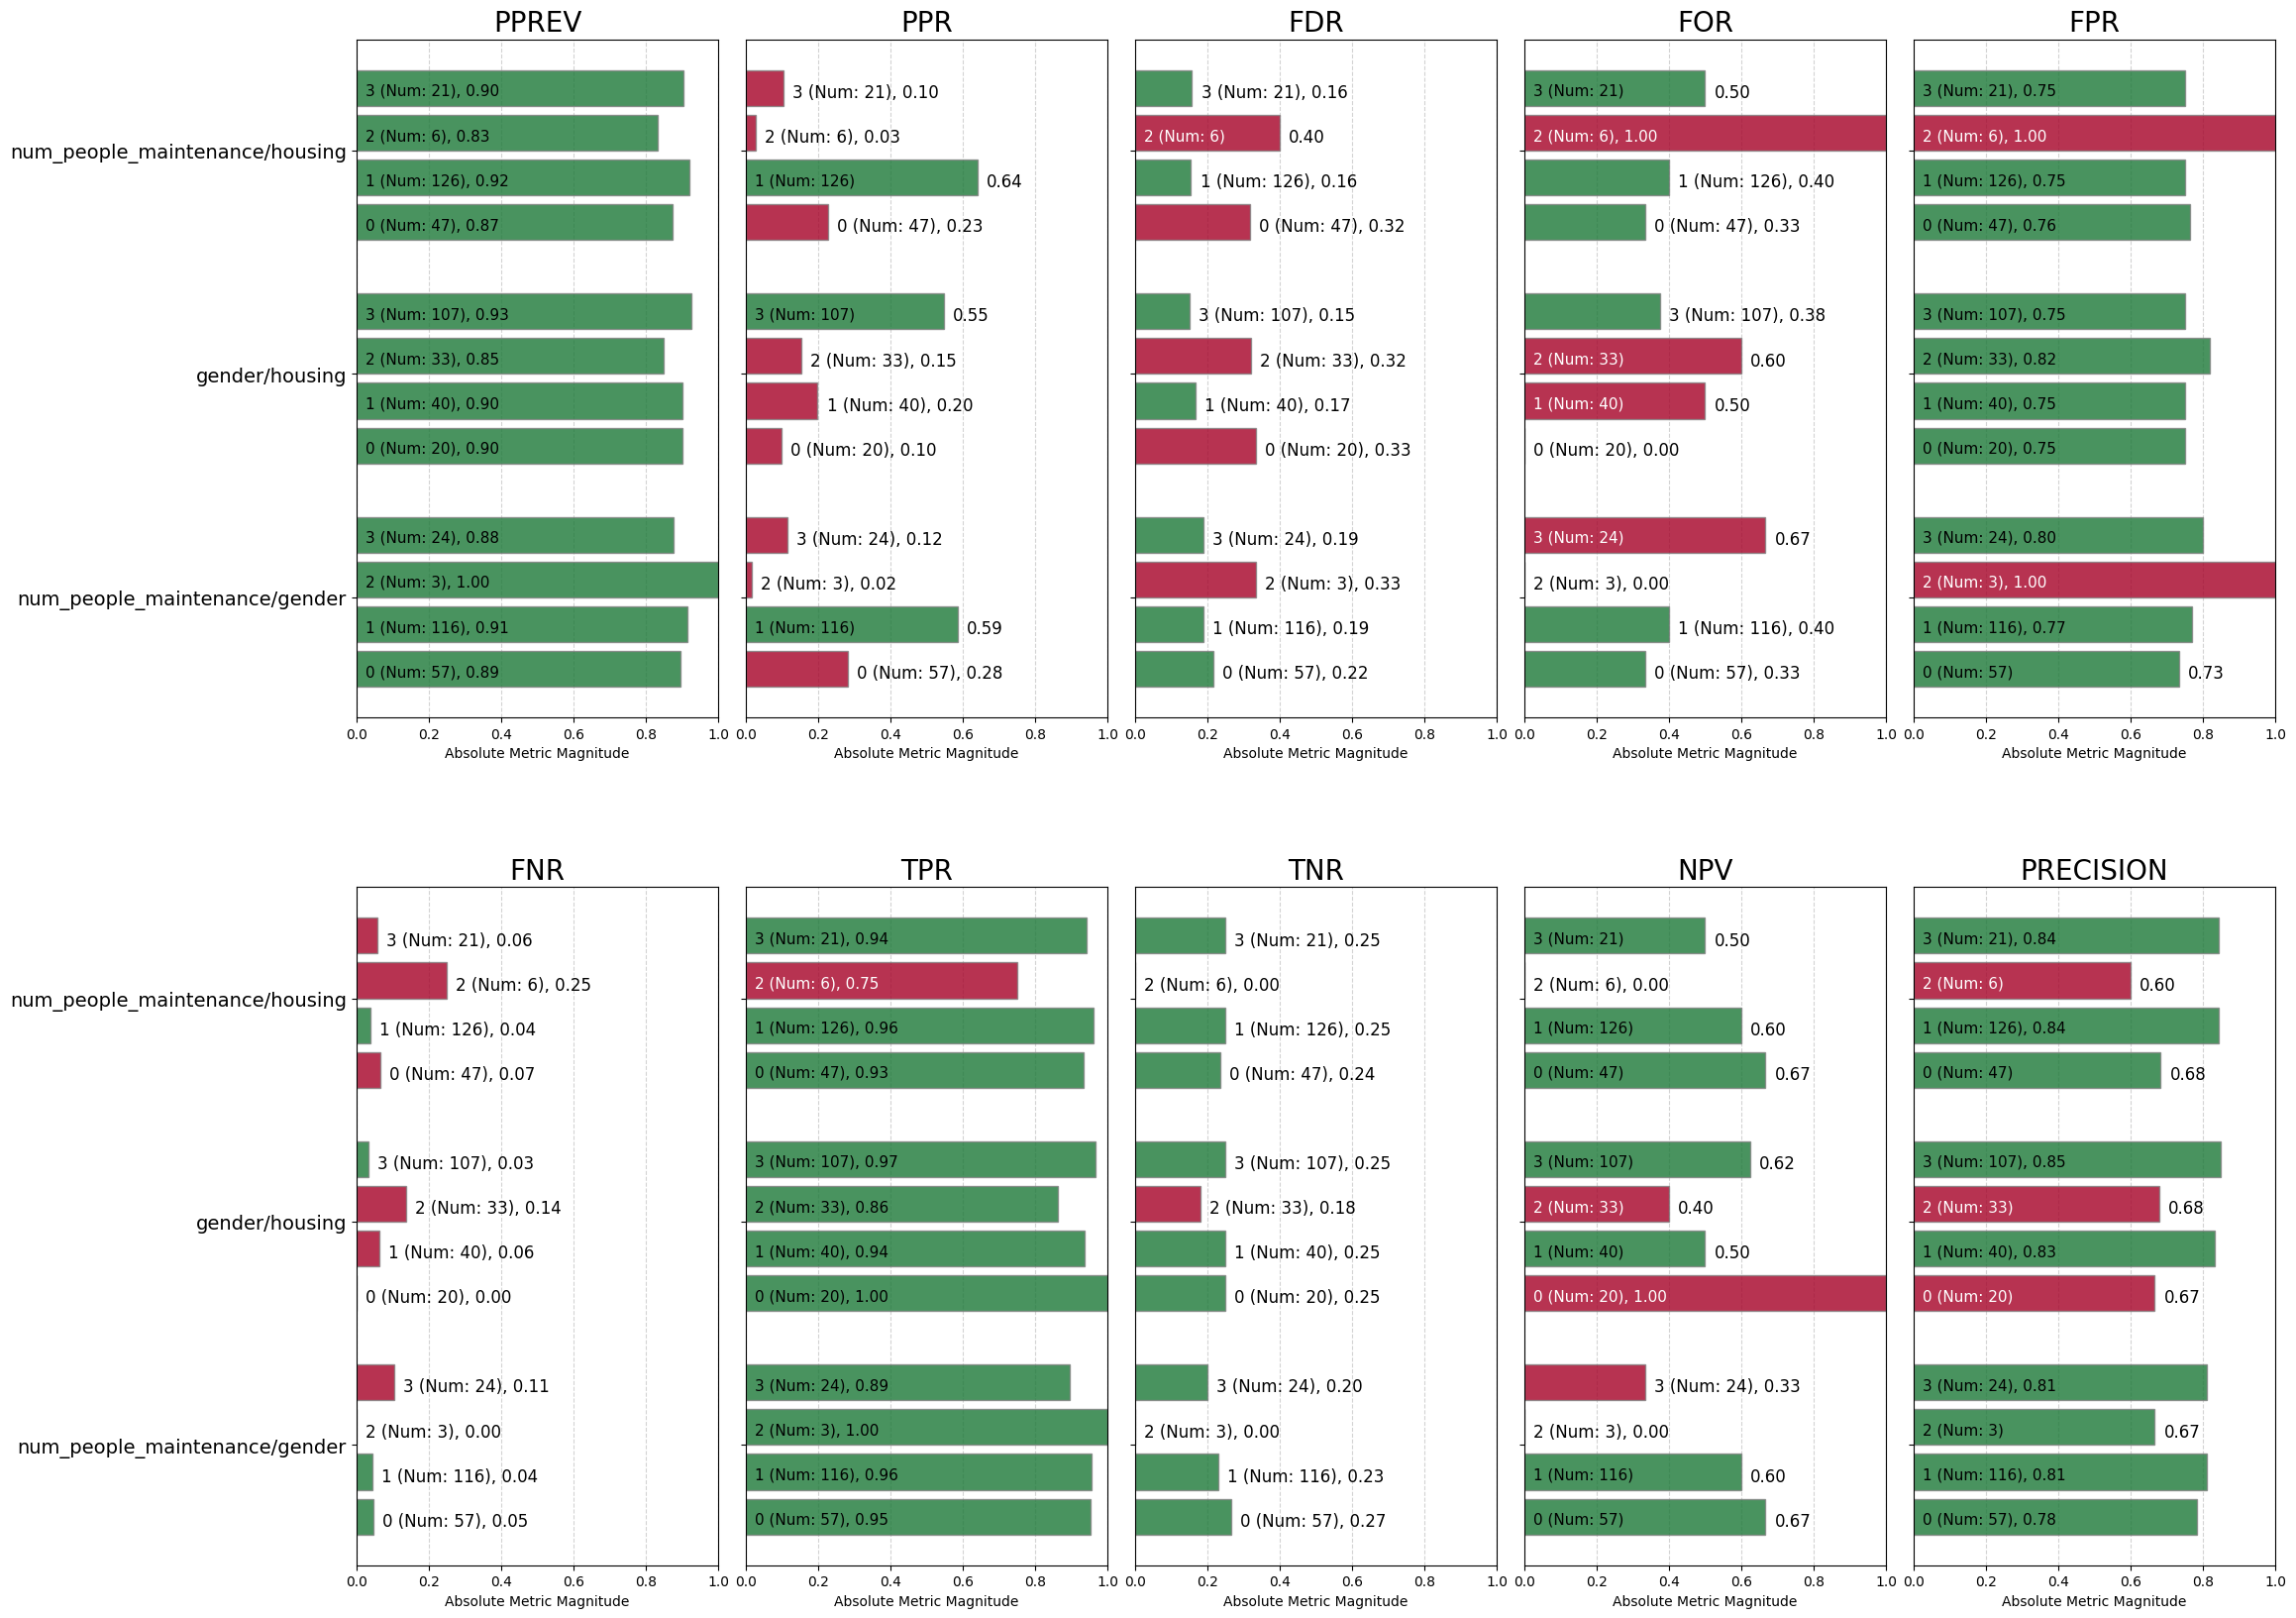

model_id score_threshold                  attribute_name  \
0         0      binary 0/1                  gender/housing   
1         0      binary 0/1   num_people_maintenance/gender   
2         0      binary 0/1  num_people_maintenance/housing   

   Statistical Parity  Impact Parity  FDR Parity  FPR Parity  FOR Parity  \
0               False           True       False        True       False   
1               False           True       False       False       False   
2               False           True       False       False       False   

   FNR Parity  TPR Parity  TNR Parity  NPV Parity  Precision Parity  \
0       False        True       False       False             False   
1       False        True       False       False              True   
2       False       False       False       False             False   

   TypeI Parity  TypeII Parity  Equalized Odds  Unsupervised Fairness  \
0         False          False            True                  False   
1         False          False           False                  False   
2         False          False           False                  False   

   Supervised Fairness  
0                False  
1                False  
2                False

alt.VConcatChart(...)

alt.VConcatChart(...)

<Figure size 640x480 with 0 Axes>

In [92]:
'''
4. Label flipping
'''

#transform data
data_to_transform = df_num_int.copy()
data_transformed_lf = prep_label_flipping(df_num_int,protected_attributes_int,target)
#train
x_test_lf, y_test_lf, y_predicted_dict_lf, metrics_lf_dict = split_and_train(data_transformed_lf,
                                                                             protected_attributes_int,target)
#calc metrics
df_test_transformed_lf = calc_fairness_report(x_test_lf, y_test_lf, y_predicted_dict_lf["LogisticRegression"], target,
                                              protected_attributes_int, list_of_disparities,priv, display_disp=True)

#compare disparities
plot_audit(df_test_int, protected_attributes_int)
plot_audit(df_test_transformed_lf, protected_attributes_int)

Accuracy score test:
0.7850


attribute_name attribute_value  accuracy   tpr   tnr  \
0    num_people_maintenance/gender             0.0      0.77  0.94  0.41   
1    num_people_maintenance/gender             1.0      0.79  0.98  0.23   
2    num_people_maintenance/gender             2.0      0.00   NaN  0.00   
3    num_people_maintenance/gender             3.0      0.81  0.88  0.33   
4                   gender/housing             0.0      0.84  0.88  0.78   
5                   gender/housing             1.0      0.68  1.00  0.00   
6                   gender/housing             2.0      0.68  0.78  0.50   
7                   gender/housing             3.0      0.82  0.99  0.13   
8   num_people_maintenance/housing             0.0      0.82  0.89  0.69   
9   num_people_maintenance/housing             1.0      0.77  0.99  0.10   
10  num_people_maintenance/housing             2.0      0.44  0.50  0.33   
11  num_people_maintenance/housing             3.0      0.95  1.00  0.00   

     for   fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0   0.22  0.23  0.59  0.06  0.78       0.77  0.24   0.83  0.67  
1   0.22  0.21  0.77  0.02  0.78       0.79  0.62   0.92  0.75  
2    NaN  1.00  1.00   NaN   NaN       0.00  0.01   1.00  0.00  
3   0.75  0.09  0.67  0.12  0.25       0.91  0.13   0.85  0.89  
4   0.22  0.12  0.22  0.12  0.78       0.88  0.09   0.64  0.64  
5    NaN  0.32  1.00  0.00   NaN       0.68  0.16   1.00  0.68  
6   0.44  0.26  0.50  0.22  0.56       0.74  0.11   0.68  0.64  
7   0.25  0.17  0.87  0.01  0.75       0.83  0.65   0.97  0.81  
8   0.21  0.17  0.31  0.11  0.79       0.83  0.17   0.68  0.64  
9   0.25  0.23  0.90  0.01  0.75       0.77  0.70   0.97  0.76  
10  0.75  0.40  0.67  0.50  0.25       0.60  0.03   0.56  0.67  
11   NaN  0.05  1.00  0.00   NaN       0.95  0.11   1.00  0.95

Majority class for:  num_people_maintenance/gender  is: 1.0
Majority class for:  gender/housing  is: 3.0
Majority class for:  num_people_maintenance/housing  is: 1.0
[]


attribute_name attribute_value  fdr_disparity  \
0    num_people_maintenance/gender             0.0           1.12   
1    num_people_maintenance/gender             1.0           1.00   
2    num_people_maintenance/gender             2.0           4.83   
3    num_people_maintenance/gender             3.0           0.42   
4                   gender/housing             0.0           0.72   
5                   gender/housing             1.0           1.85   
6                   gender/housing             2.0           1.51   
7                   gender/housing             3.0           1.00   
8   num_people_maintenance/housing             0.0           0.74   
9   num_people_maintenance/housing             1.0           1.00   
10  num_people_maintenance/housing             2.0           1.77   
11  num_people_maintenance/housing             3.0           0.23   

    fnr_disparity  for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            2.57           1.00           0.77           1.00           0.39   
1            1.00           1.00           1.00           1.00           1.00   
2             NaN            NaN           1.30            NaN           0.01   
3            5.62           3.38           0.87           0.32           0.21   
4           12.00           0.89           0.26           1.04           0.14   
5            0.00            NaN           1.15            NaN           0.24   
6           21.33           1.78           0.58           0.74           0.17   
7            1.00           1.00           1.00           1.00           1.00   
8           10.39           0.86           0.35           1.05           0.24   
9            1.00           1.00           1.00           1.00           1.00   
10          48.50           3.00           0.74           0.33           0.04   
11           0.00            NaN           1.11            NaN           0.15   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              0.89                 0.97           1.76           0.96  
1              1.00                 1.00           1.00           1.00  
2              1.08                 0.00           0.00            NaN  
3              0.92                 1.15           1.43           0.89  
4              0.66                 1.06           5.96           0.88  
5              1.03                 0.82           0.00           1.01  
6              0.70                 0.89           3.83           0.79  
7              1.00                 1.00           1.00           1.00  
8              0.70                 1.08           7.10           0.90  
9              1.00                 1.00           1.00           1.00  
10             0.57                 0.78           3.44           0.51  
11             1.03                 1.22           0.00           1.01

                                fnr_disparity  for_disparity
num_people_maintenance/gender        3.063333       1.793333
gender/housing                       8.582500       1.223333
num_people_maintenance/housing      14.972500       1.620000
Overall average for fnr_disparity:  8.873
Overall average for for_disparity:  1.546


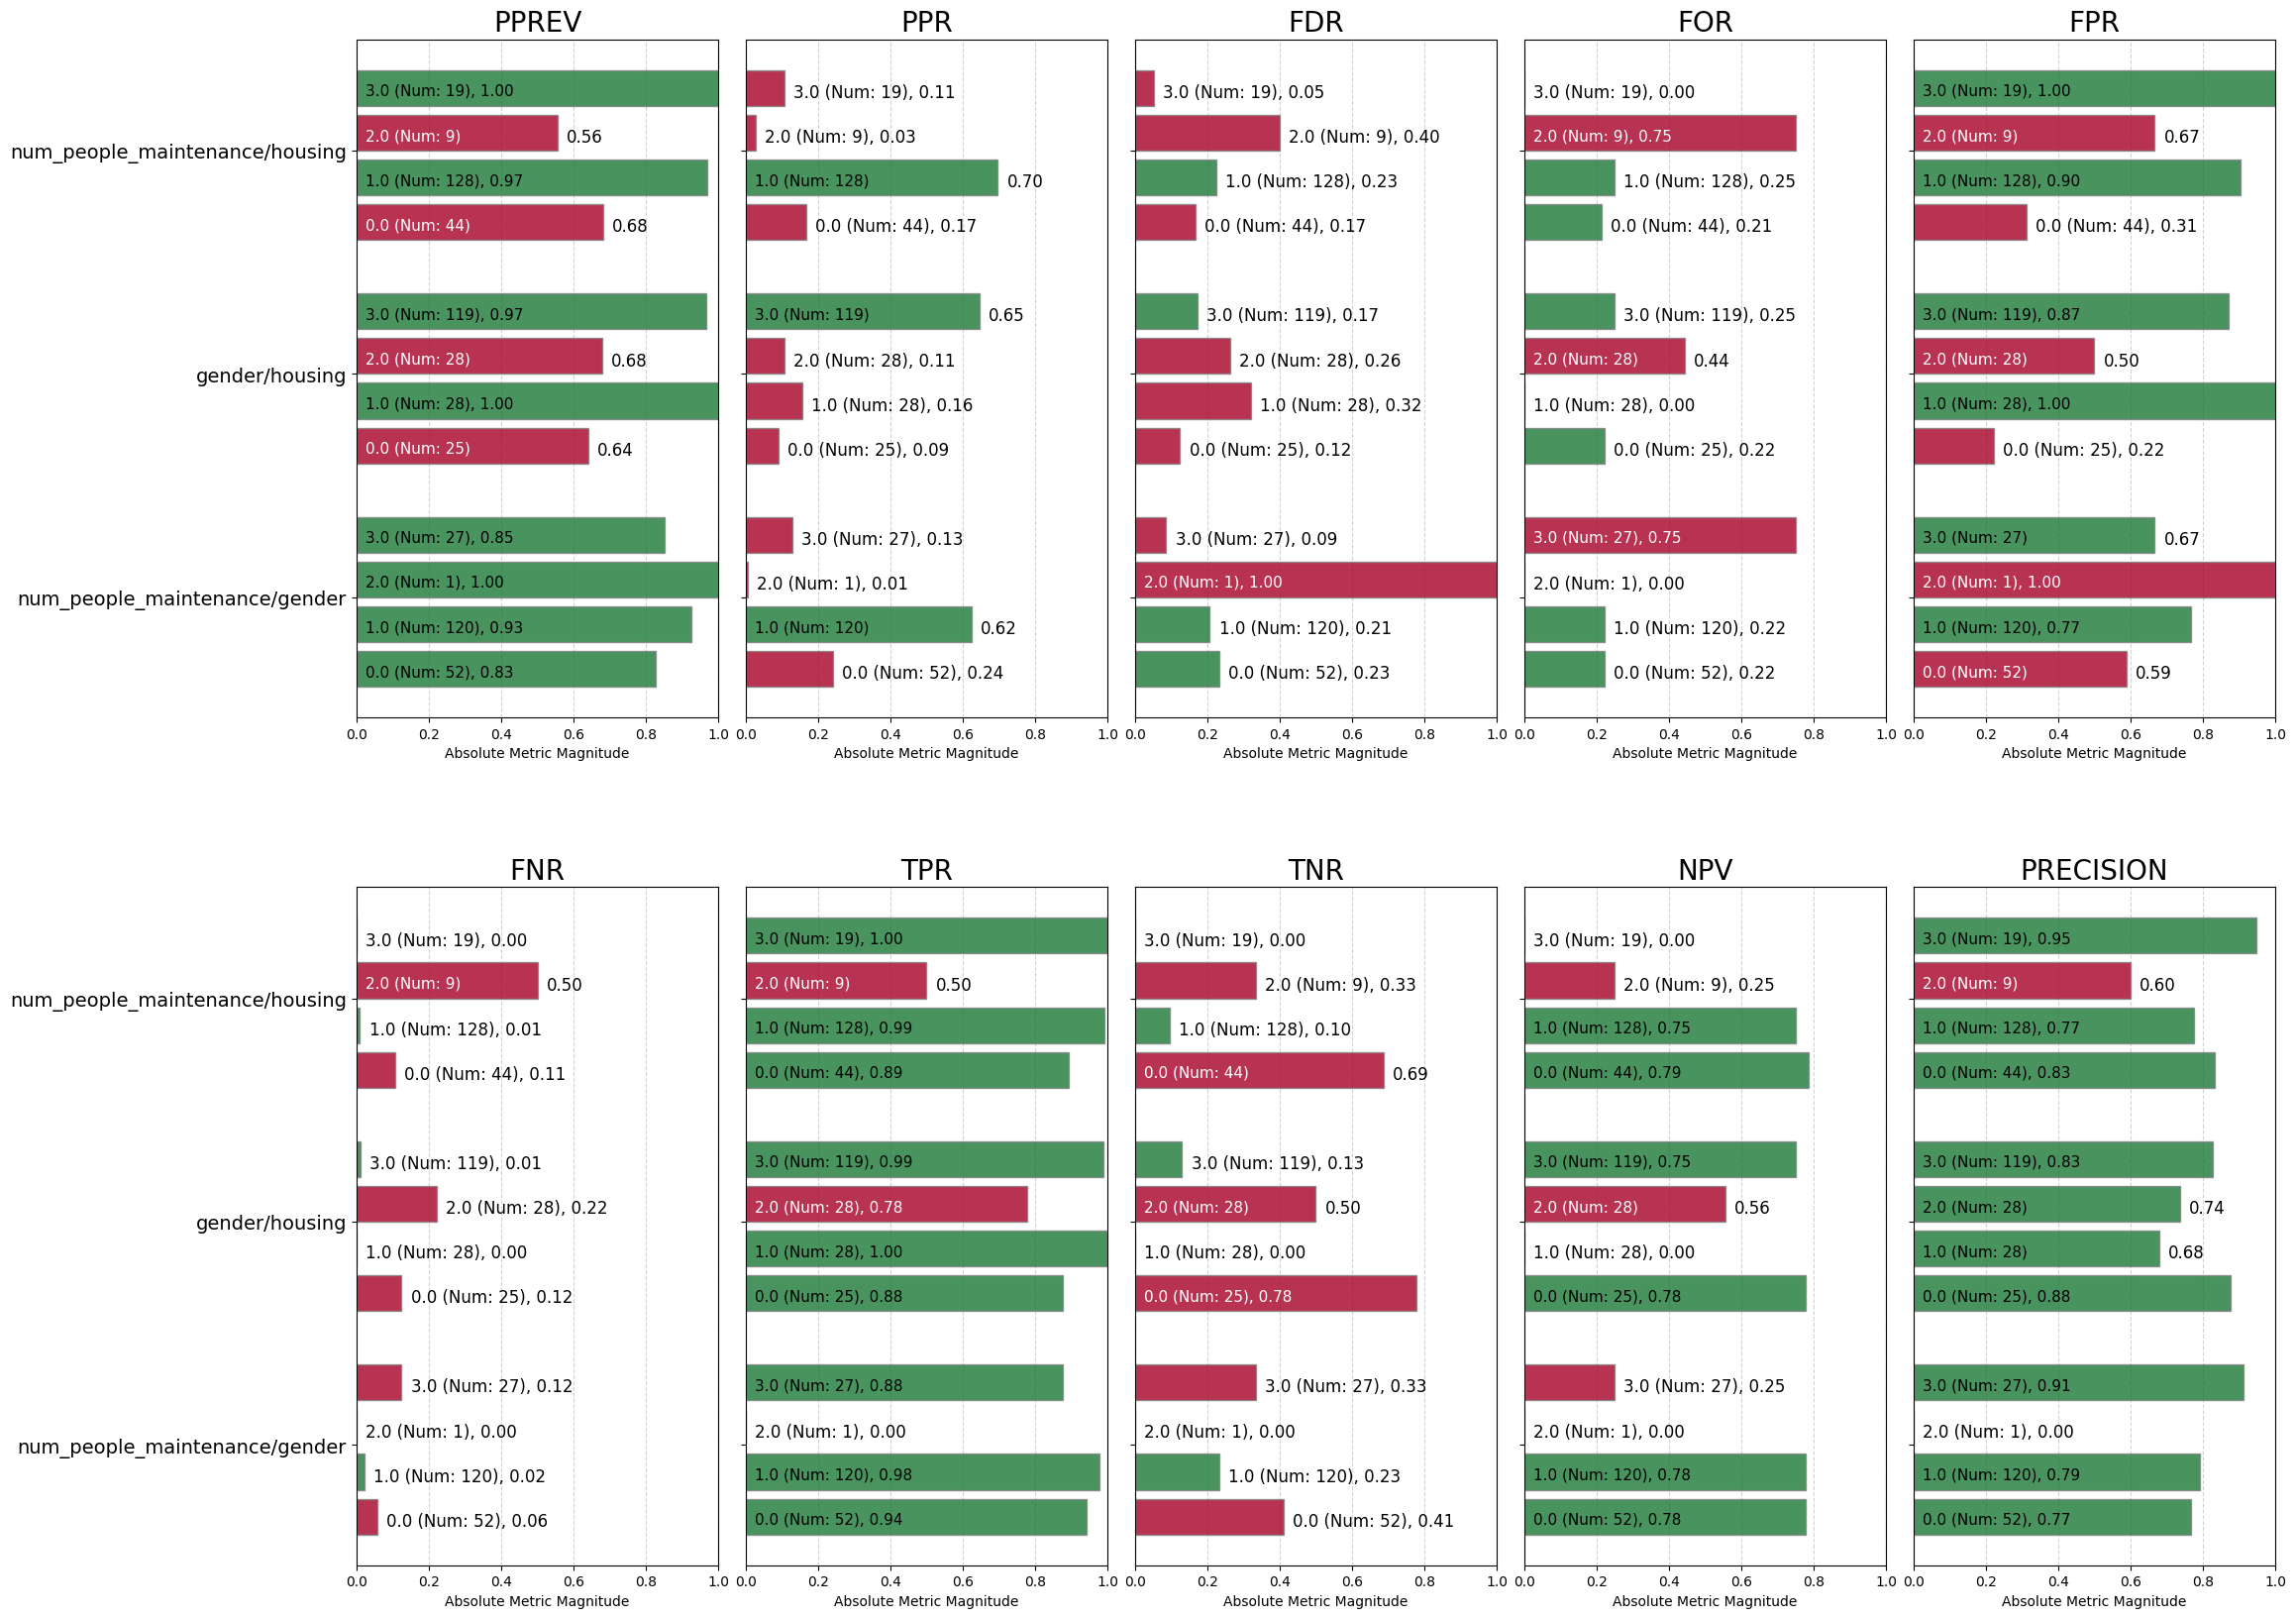

model_id score_threshold                  attribute_name  \
0         0      binary 0/1                  gender/housing   
1         0      binary 0/1   num_people_maintenance/gender   
2         0      binary 0/1  num_people_maintenance/housing   

   Statistical Parity  Impact Parity  FDR Parity  FPR Parity  FOR Parity  \
0               False          False       False       False       False   
1               False           True       False       False       False   
2               False          False       False       False       False   

   FNR Parity  TPR Parity  TNR Parity  NPV Parity  Precision Parity  \
0       False       False       False       False              True   
1       False        True       False       False             False   
2       False       False       False       False             False   

   TypeI Parity  TypeII Parity  Equalized Odds  Unsupervised Fairness  \
0         False          False           False                  False   
1         False          False           False                  False   
2         False          False           False                  False   

   Supervised Fairness  
0                False  
1                False  
2                False

<Figure size 640x480 with 0 Axes>

In [10]:
"""Gerry fair"""""

maj_1 = get_majority_classes(df_num_int[protected_attributes_int[0]])[0]
maj_2 = get_majority_classes(df_num_int[protected_attributes_int[1]])[0]
maj_3 = get_majority_classes(df_num_int[protected_attributes_int[2]])[0]
maj_classes = [[maj_1],[maj_2],[maj_3]]

x_test_gf,y_test_gf,y_test_pred_gf = in_process_gerryfair(df_num_int,target, protected_attributes_int, maj_classes, len(df_num_int)-len(x_test_int))
df_test_transformed_gf =calc_fairness_report(x_test_gf, y_test_gf, y_test_pred_gf,target,protected_attributes_int,list_of_disparities,priv, display_disp=True)

[INFO] 2024-11-20 19:29:18 methods.inprocessing.ExponentiatedGradient - Instantiating estimator '<class 'sklearn.linear_model._logistic.LogisticRegression'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating estimator '<class 'sklearn.linear_model._logistic.LogisticRegression'>' with parameters: {}.


[INFO] 2024-11-20 19:29:18 methods.inprocessing.ExponentiatedGradient - Instantiating constraint '<class 'fairlearn.reductions._moments.utility_parity.ErrorRateParity'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating constraint '<class 'fairlearn.reductions._moments.utility_parity.ErrorRateParity'>' with parameters: {}.


[INFO] 2024-11-20 19:29:18 methods.inprocessing.ExponentiatedGradient - Instantiating reduction '<class 'fairlearn.reductions._exponentiated_gradient.exponentiated_gradient.ExponentiatedGradient'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating reduction '<class 'fairlearn.reductions._exponentiated_gradient.exponentiated_gradient.ExponentiatedGradient'>' with parameters: {}.


Model:
 sklearn.linear_model.LogisticRegression
Accuracy score training:
0.7050
Accuracy score test:
0.7000
Classification report for model: sklearn.linear_model.LogisticRegression : 
               precision    recall  f1-score   support

           0       0.44      0.43      0.43        54
           1       0.79      0.80      0.80       146

    accuracy                           0.70       200
   macro avg       0.62      0.61      0.61       200
weighted avg       0.70      0.70      0.70       200

attribute: num_people_maintenance/gender
Privileged groups:  [{'num_people_maintenance/gender': 1}]
Unprivileged groups:  [{'num_people_maintenance/gender': 2}, {'num_people_maintenance/gender': 3}, {'num_people_maintenance/gender': 0}]
---------- Metrics --------

Disparate Impact Ratio for num_people_maintenance/gender: 0.942
Statistical Parity Difference for num_people_maintenance/gender: -0.044
equalized opportunity difference for num_people_maintenance/gender: 0.026
equalized od

attribute_name attribute_value  accuracy   tpr   tnr  \
0    num_people_maintenance/gender               0      0.74  0.82  0.53   
1    num_people_maintenance/gender               1      0.67  0.79  0.33   
2    num_people_maintenance/gender               2      0.33  0.50  0.00   
3    num_people_maintenance/gender               3      0.79  0.83  0.67   
4                   gender/housing               0      0.75  0.82  0.67   
5                   gender/housing               1      0.70  0.81  0.33   
6                   gender/housing               2      0.55  0.68  0.36   
7                   gender/housing               3      0.74  0.82  0.41   
8   num_people_maintenance/housing               0      0.62  0.70  0.50   
9   num_people_maintenance/housing               1      0.72  0.83  0.33   
10  num_people_maintenance/housing               2      0.67  1.00  0.33   
11  num_people_maintenance/housing               3      0.76  0.76  0.75   

     for   fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0   0.44  0.20  0.47  0.18  0.56       0.80  0.28   0.72  0.70  
1   0.64  0.23  0.67  0.21  0.36       0.77  0.59   0.76  0.74  
2   1.00  0.50  1.00  0.50  0.00       0.50  0.01   0.67  0.67  
3   0.43  0.12  0.33  0.17  0.57       0.88  0.11   0.71  0.75  
4   0.25  0.25  0.33  0.18  0.75       0.75  0.08   0.60  0.55  
5   0.67  0.19  0.67  0.19  0.33       0.81  0.21   0.78  0.78  
6   0.55  0.41  0.64  0.32  0.45       0.59  0.15   0.67  0.58  
7   0.62  0.16  0.59  0.18  0.38       0.84  0.56   0.78  0.79  
8   0.44  0.34  0.50  0.30  0.56       0.66  0.20   0.62  0.57  
9   0.65  0.18  0.67  0.17  0.35       0.82  0.68   0.79  0.79  
10  0.00  0.40  0.67  0.00  1.00       0.60  0.03   0.83  0.50  
11  0.57  0.07  0.25  0.24  0.43       0.93  0.09   0.67  0.81

Majority class for:  num_people_maintenance/gender  is: 1
Majority class for:  gender/housing  is: 3
Majority class for:  num_people_maintenance/housing  is: 1
[]


attribute_name attribute_value  fdr_disparity  \
0    num_people_maintenance/gender               0           0.86   
1    num_people_maintenance/gender               1           1.00   
2    num_people_maintenance/gender               2           2.20   
3    num_people_maintenance/gender               3           0.52   
4                   gender/housing               0           1.60   
5                   gender/housing               1           1.24   
6                   gender/housing               2           2.61   
7                   gender/housing               3           1.00   
8   num_people_maintenance/housing               0           1.92   
9   num_people_maintenance/housing               1           1.00   
10  num_people_maintenance/housing               2           2.22   
11  num_people_maintenance/housing               3           0.40   

    fnr_disparity  for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            0.84           0.68           0.71           1.58           0.47   
1            1.00           1.00           1.00           1.00           1.00   
2            2.39           1.56           1.50           0.00           0.02   
3            0.80           0.67           0.50           1.60           0.19   
4            1.03           0.40           0.56           2.00           0.14   
5            1.10           1.07           1.13           0.89           0.37   
6            1.79           0.87           1.09           1.21           0.27   
7            1.00           1.00           1.00           1.00           1.00   
8            1.73           0.68           0.75           1.60           0.29   
9            1.00           1.00           1.00           1.00           1.00   
10           0.00           0.00           1.00           2.89           0.05   
11           1.37           0.87           0.38           1.24           0.14   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              0.95                 1.04           1.59           1.04  
1              1.00                 1.00           1.00           1.00  
2              0.88                 0.65           0.00           0.63  
3              0.93                 1.14           2.00           1.05  
4              0.77                 0.89           1.63           0.99  
5              1.00                 0.96           0.81           0.98  
6              0.86                 0.70           0.87           0.83  
7              1.00                 1.00           1.00           1.00  
8              0.78                 0.80           1.50           0.85  
9              1.00                 1.00           1.00           1.00  
10             1.05                 0.73           1.00           1.21  
11             0.84                 1.13           2.25           0.92

                                fnr_disparity  for_disparity
num_people_maintenance/gender        1.343333       0.970000
gender/housing                       1.306667       0.780000
num_people_maintenance/housing       1.033333       0.516667
Overall average for fnr_disparity:  1.228
Overall average for for_disparity:  0.756


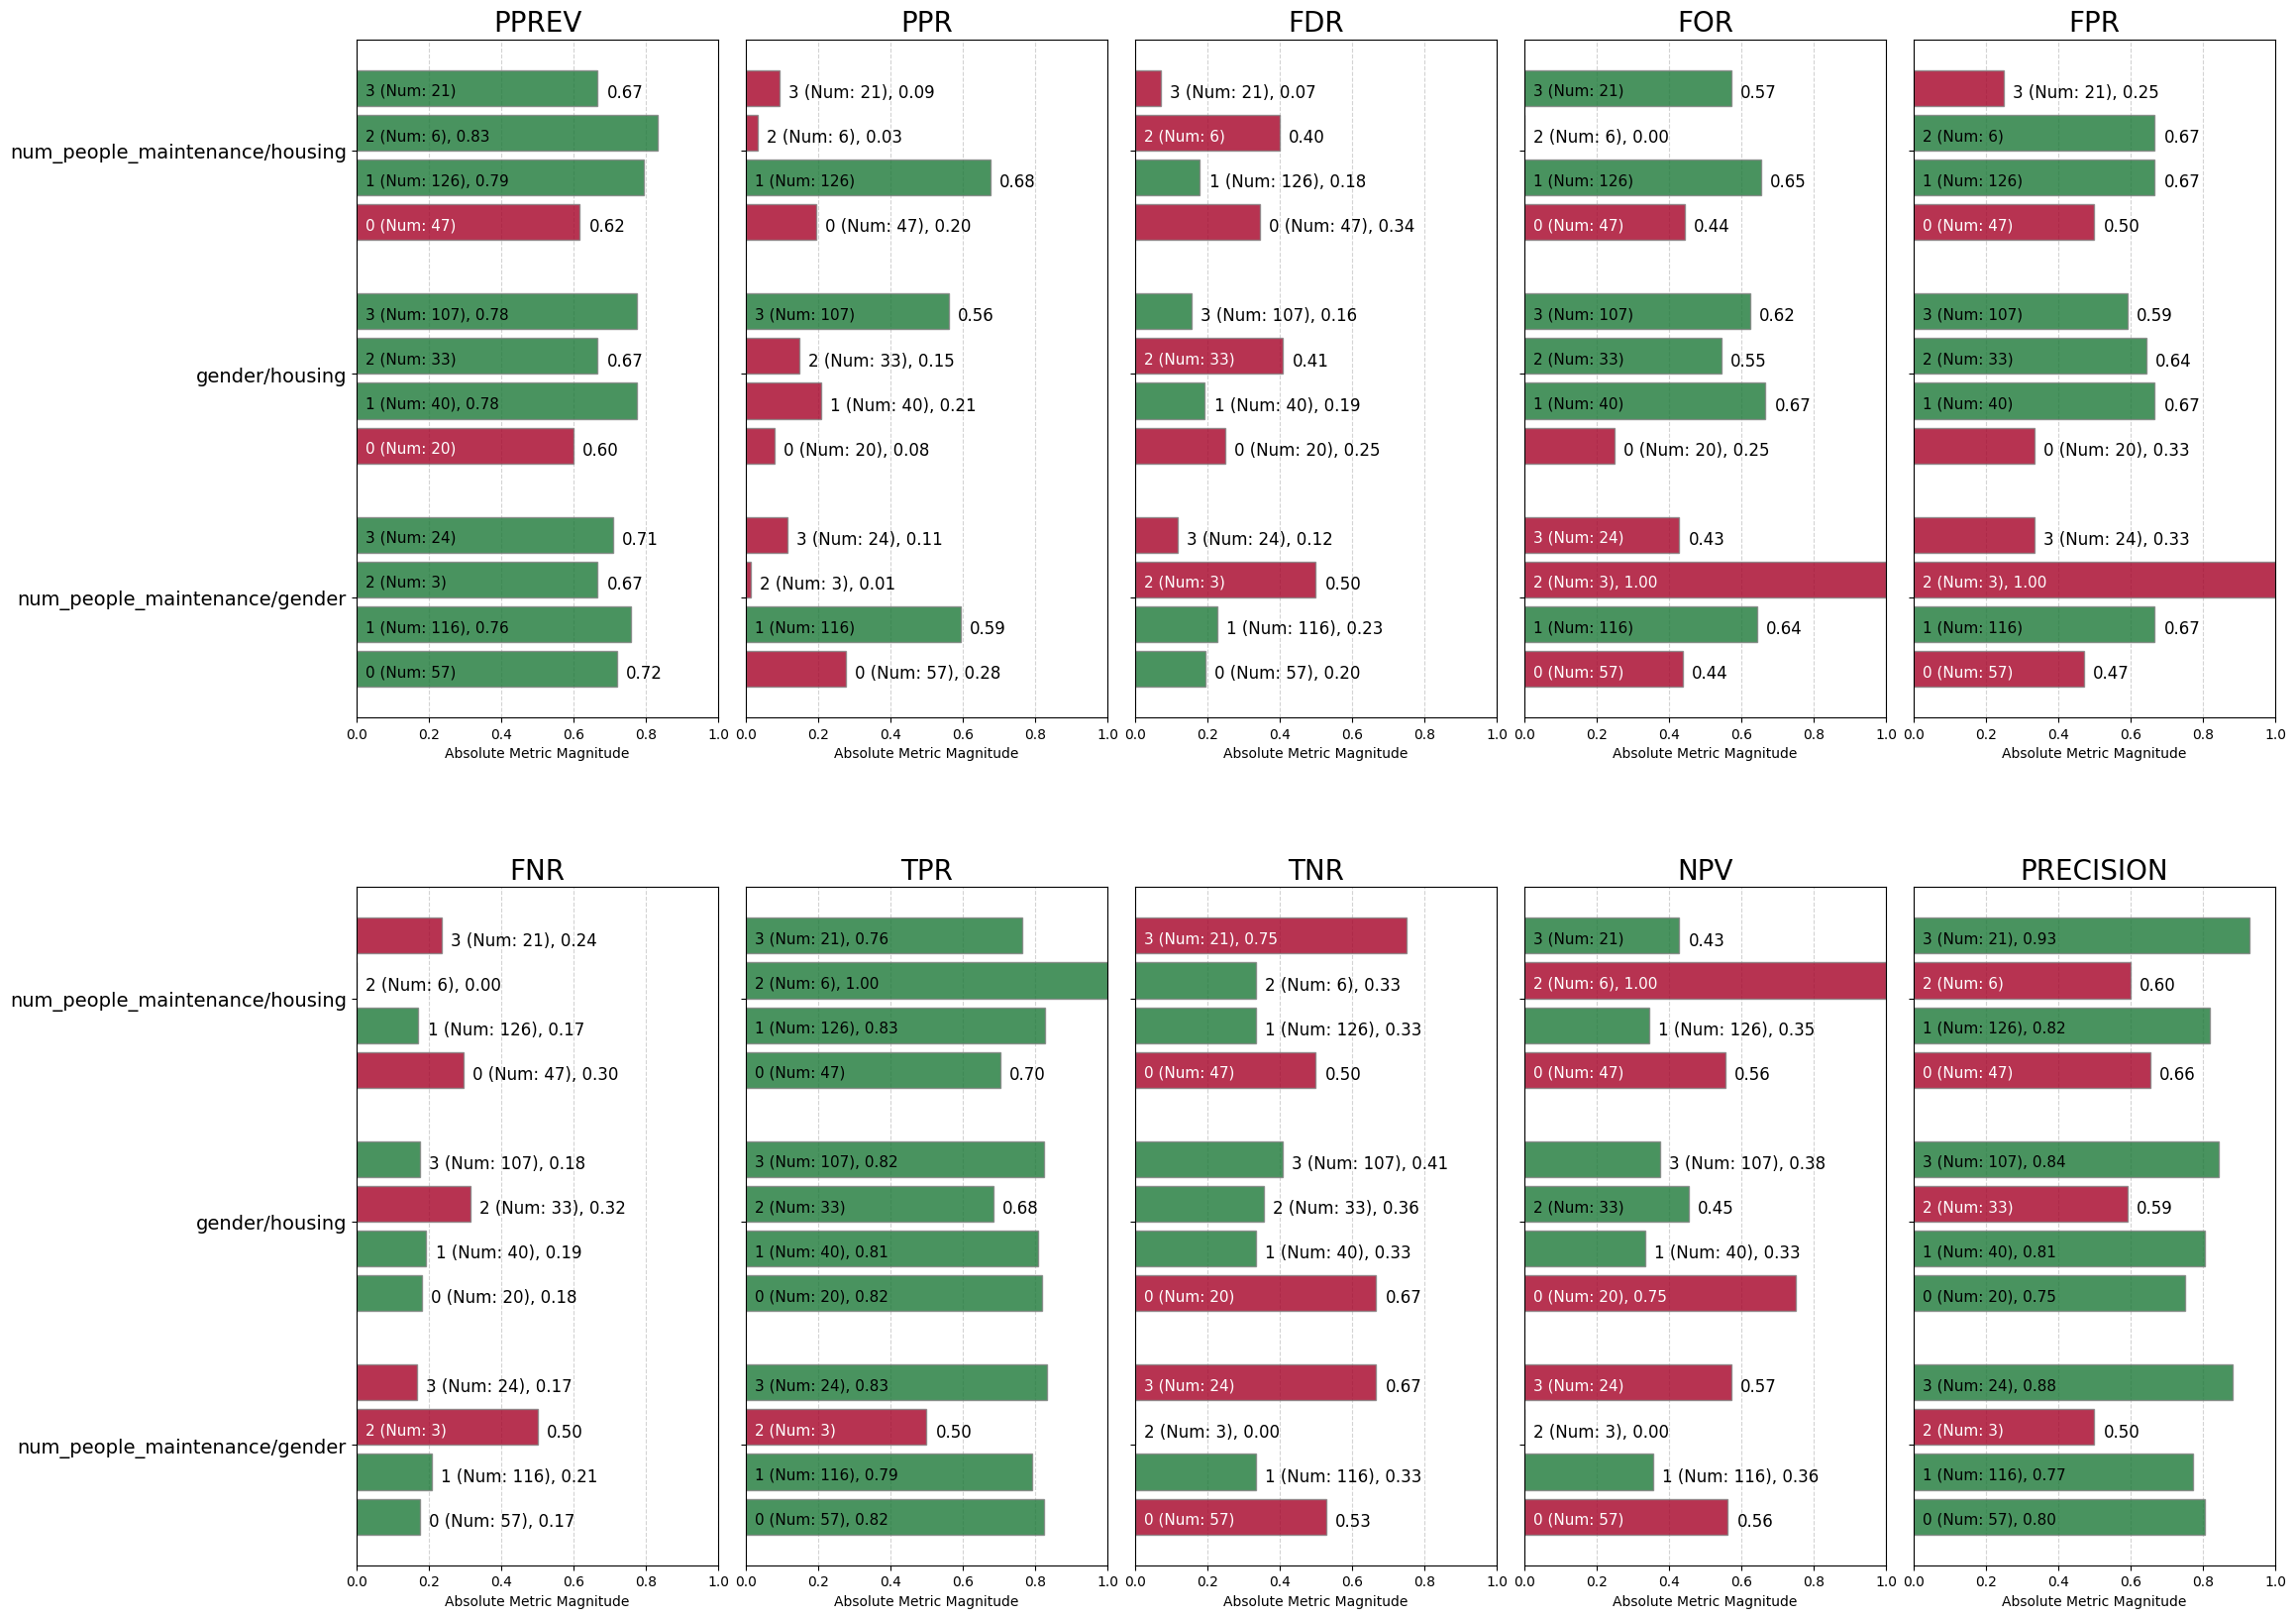

model_id score_threshold                  attribute_name  \
0         0      binary 0/1                  gender/housing   
1         0      binary 0/1   num_people_maintenance/gender   
2         0      binary 0/1  num_people_maintenance/housing   

   Statistical Parity  Impact Parity  FDR Parity  FPR Parity  FOR Parity  \
0               False          False       False       False       False   
1               False           True       False       False       False   
2               False          False       False       False       False   

   FNR Parity  TPR Parity  TNR Parity  NPV Parity  Precision Parity  \
0       False        True       False       False             False   
1       False       False       False       False             False   
2       False        True       False       False             False   

   TypeI Parity  TypeII Parity  Equalized Odds  Unsupervised Fairness  \
0         False          False           False                  False   
1         False          False           False                  False   
2         False          False           False                  False   

   Supervised Fairness  
0                False  
1                False  
2                False

[INFO] 2024-11-20 19:29:20 methods.inprocessing.ExponentiatedGradient - Instantiating estimator '<class 'sklearn.linear_model._logistic.LogisticRegression'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating estimator '<class 'sklearn.linear_model._logistic.LogisticRegression'>' with parameters: {}.


[INFO] 2024-11-20 19:29:20 methods.inprocessing.ExponentiatedGradient - Instantiating constraint '<class 'fairlearn.reductions._moments.utility_parity.ErrorRateParity'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating constraint '<class 'fairlearn.reductions._moments.utility_parity.ErrorRateParity'>' with parameters: {}.


[INFO] 2024-11-20 19:29:20 methods.inprocessing.ExponentiatedGradient - Instantiating reduction '<class 'fairlearn.reductions._exponentiated_gradient.exponentiated_gradient.ExponentiatedGradient'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating reduction '<class 'fairlearn.reductions._exponentiated_gradient.exponentiated_gradient.ExponentiatedGradient'>' with parameters: {}.


Model:
 sklearn.linear_model.LogisticRegression
Accuracy score training:
0.7200
Accuracy score test:
0.7050
Classification report for model: sklearn.linear_model.LogisticRegression : 
               precision    recall  f1-score   support

           0       0.44      0.31      0.37        54
           1       0.77      0.85      0.81       146

    accuracy                           0.70       200
   macro avg       0.60      0.58      0.59       200
weighted avg       0.68      0.70      0.69       200

attribute: gender/housing
Privileged groups:  [{'gender/housing': 3}]
Unprivileged groups:  [{'gender/housing': 0}, {'gender/housing': 2}, {'gender/housing': 1}]
---------- Metrics --------

Disparate Impact Ratio for gender/housing: 1.029
Statistical Parity Difference for gender/housing: 0.023
equalized opportunity difference for gender/housing: 0.034
equalized ods difference for gender/housing: 0.082
 FNR ratio for gender/housing: 0.796
 FNR privileged for gender/housing: 0.151
 FN

attribute_name attribute_value  accuracy   tpr   tnr  \
0    num_people_maintenance/gender               0      0.77  0.95  0.35   
1    num_people_maintenance/gender               1      0.66  0.79  0.30   
2    num_people_maintenance/gender               2      0.33  0.50  0.00   
3    num_people_maintenance/gender               3      0.79  0.94  0.33   
4                   gender/housing               0      0.75  0.91  0.56   
5                   gender/housing               1      0.75  0.94  0.11   
6                   gender/housing               2      0.52  0.74  0.21   
7                   gender/housing               3      0.74  0.84  0.36   
8   num_people_maintenance/housing               0      0.62  0.78  0.40   
9   num_people_maintenance/housing               1      0.73  0.86  0.26   
10  num_people_maintenance/housing               2      0.50  1.00  0.00   
11  num_people_maintenance/housing               3      0.81  0.88  0.50   

     for   fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0   0.25  0.22  0.65  0.05  0.75       0.78  0.30   0.86  0.70  
1   0.67  0.24  0.70  0.21  0.33       0.76  0.55   0.77  0.74  
2   1.00  0.50  1.00  0.50  0.00       0.50  0.01   0.67  0.67  
3   0.33  0.19  0.67  0.06  0.67       0.81  0.13   0.88  0.75  
4   0.17  0.29  0.44  0.09  0.83       0.71  0.09   0.70  0.55  
5   0.67  0.22  0.89  0.06  0.33       0.78  0.23   0.92  0.78  
6   0.62  0.44  0.79  0.26  0.38       0.56  0.16   0.76  0.58  
7   0.64  0.16  0.64  0.16  0.36       0.84  0.53   0.79  0.79  
8   0.43  0.36  0.60  0.22  0.57       0.64  0.20   0.70  0.57  
9   0.67  0.19  0.74  0.14  0.33       0.81  0.65   0.83  0.79  
10   NaN  0.50  1.00  0.00   NaN       0.50  0.04   1.00  0.50  
11  0.50  0.12  0.50  0.12  0.50       0.88  0.11   0.81  0.81

Majority class for:  num_people_maintenance/gender  is: 1
Majority class for:  gender/housing  is: 3
Majority class for:  num_people_maintenance/housing  is: 1
[]


attribute_name attribute_value  fdr_disparity  \
0    num_people_maintenance/gender               0           0.95   
1    num_people_maintenance/gender               1           1.00   
2    num_people_maintenance/gender               2           2.12   
3    num_people_maintenance/gender               3           0.81   
4                   gender/housing               0           1.73   
5                   gender/housing               1           1.31   
6                   gender/housing               2           2.67   
7                   gender/housing               3           1.00   
8   num_people_maintenance/housing               0           1.91   
9   num_people_maintenance/housing               1           1.00   
10  num_people_maintenance/housing               2           2.62   
11  num_people_maintenance/housing               3           0.62   

    fnr_disparity  for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            0.24           0.38           0.92           2.25           0.55   
1            1.00           1.00           1.00           1.00           1.00   
2            2.39           1.50           1.43           0.00           0.02   
3            0.27           0.50           0.95           2.00           0.24   
4            0.55           0.26           0.70           2.29           0.16   
5            0.39           1.05           1.40           0.92           0.44   
6            1.60           0.98           1.23           1.03           0.29   
7            1.00           1.00           1.00           1.00           1.00   
8            1.57           0.64           0.81           1.71           0.31   
9            1.00           1.00           1.00           1.00           1.00   
10           0.00            NaN           1.35            NaN           0.06   
11           0.83           0.75           0.68           1.50           0.16   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              1.12                 1.02           1.18           1.20  
1              1.00                 1.00           1.00           1.00  
2              0.87                 0.65           0.00           0.63  
3              1.14                 1.06           1.11           1.19  
4              0.88                 0.86           1.53           1.09  
5              1.16                 0.94           0.31           1.12  
6              0.95                 0.67           0.59           0.88  
7              1.00                 1.00           1.00           1.00  
8              0.84                 0.79           1.54           0.91  
9              1.00                 1.00           1.00           1.00  
10             1.20                 0.62           0.00           1.16  
11             0.97                 1.09           1.93           1.03

                                fnr_disparity  for_disparity
num_people_maintenance/gender        0.966667       0.793333
gender/housing                       0.846667       0.763333
num_people_maintenance/housing       0.800000       0.695000
Overall average for fnr_disparity:  0.871
Overall average for for_disparity:  0.751


<Figure size 640x480 with 0 Axes>

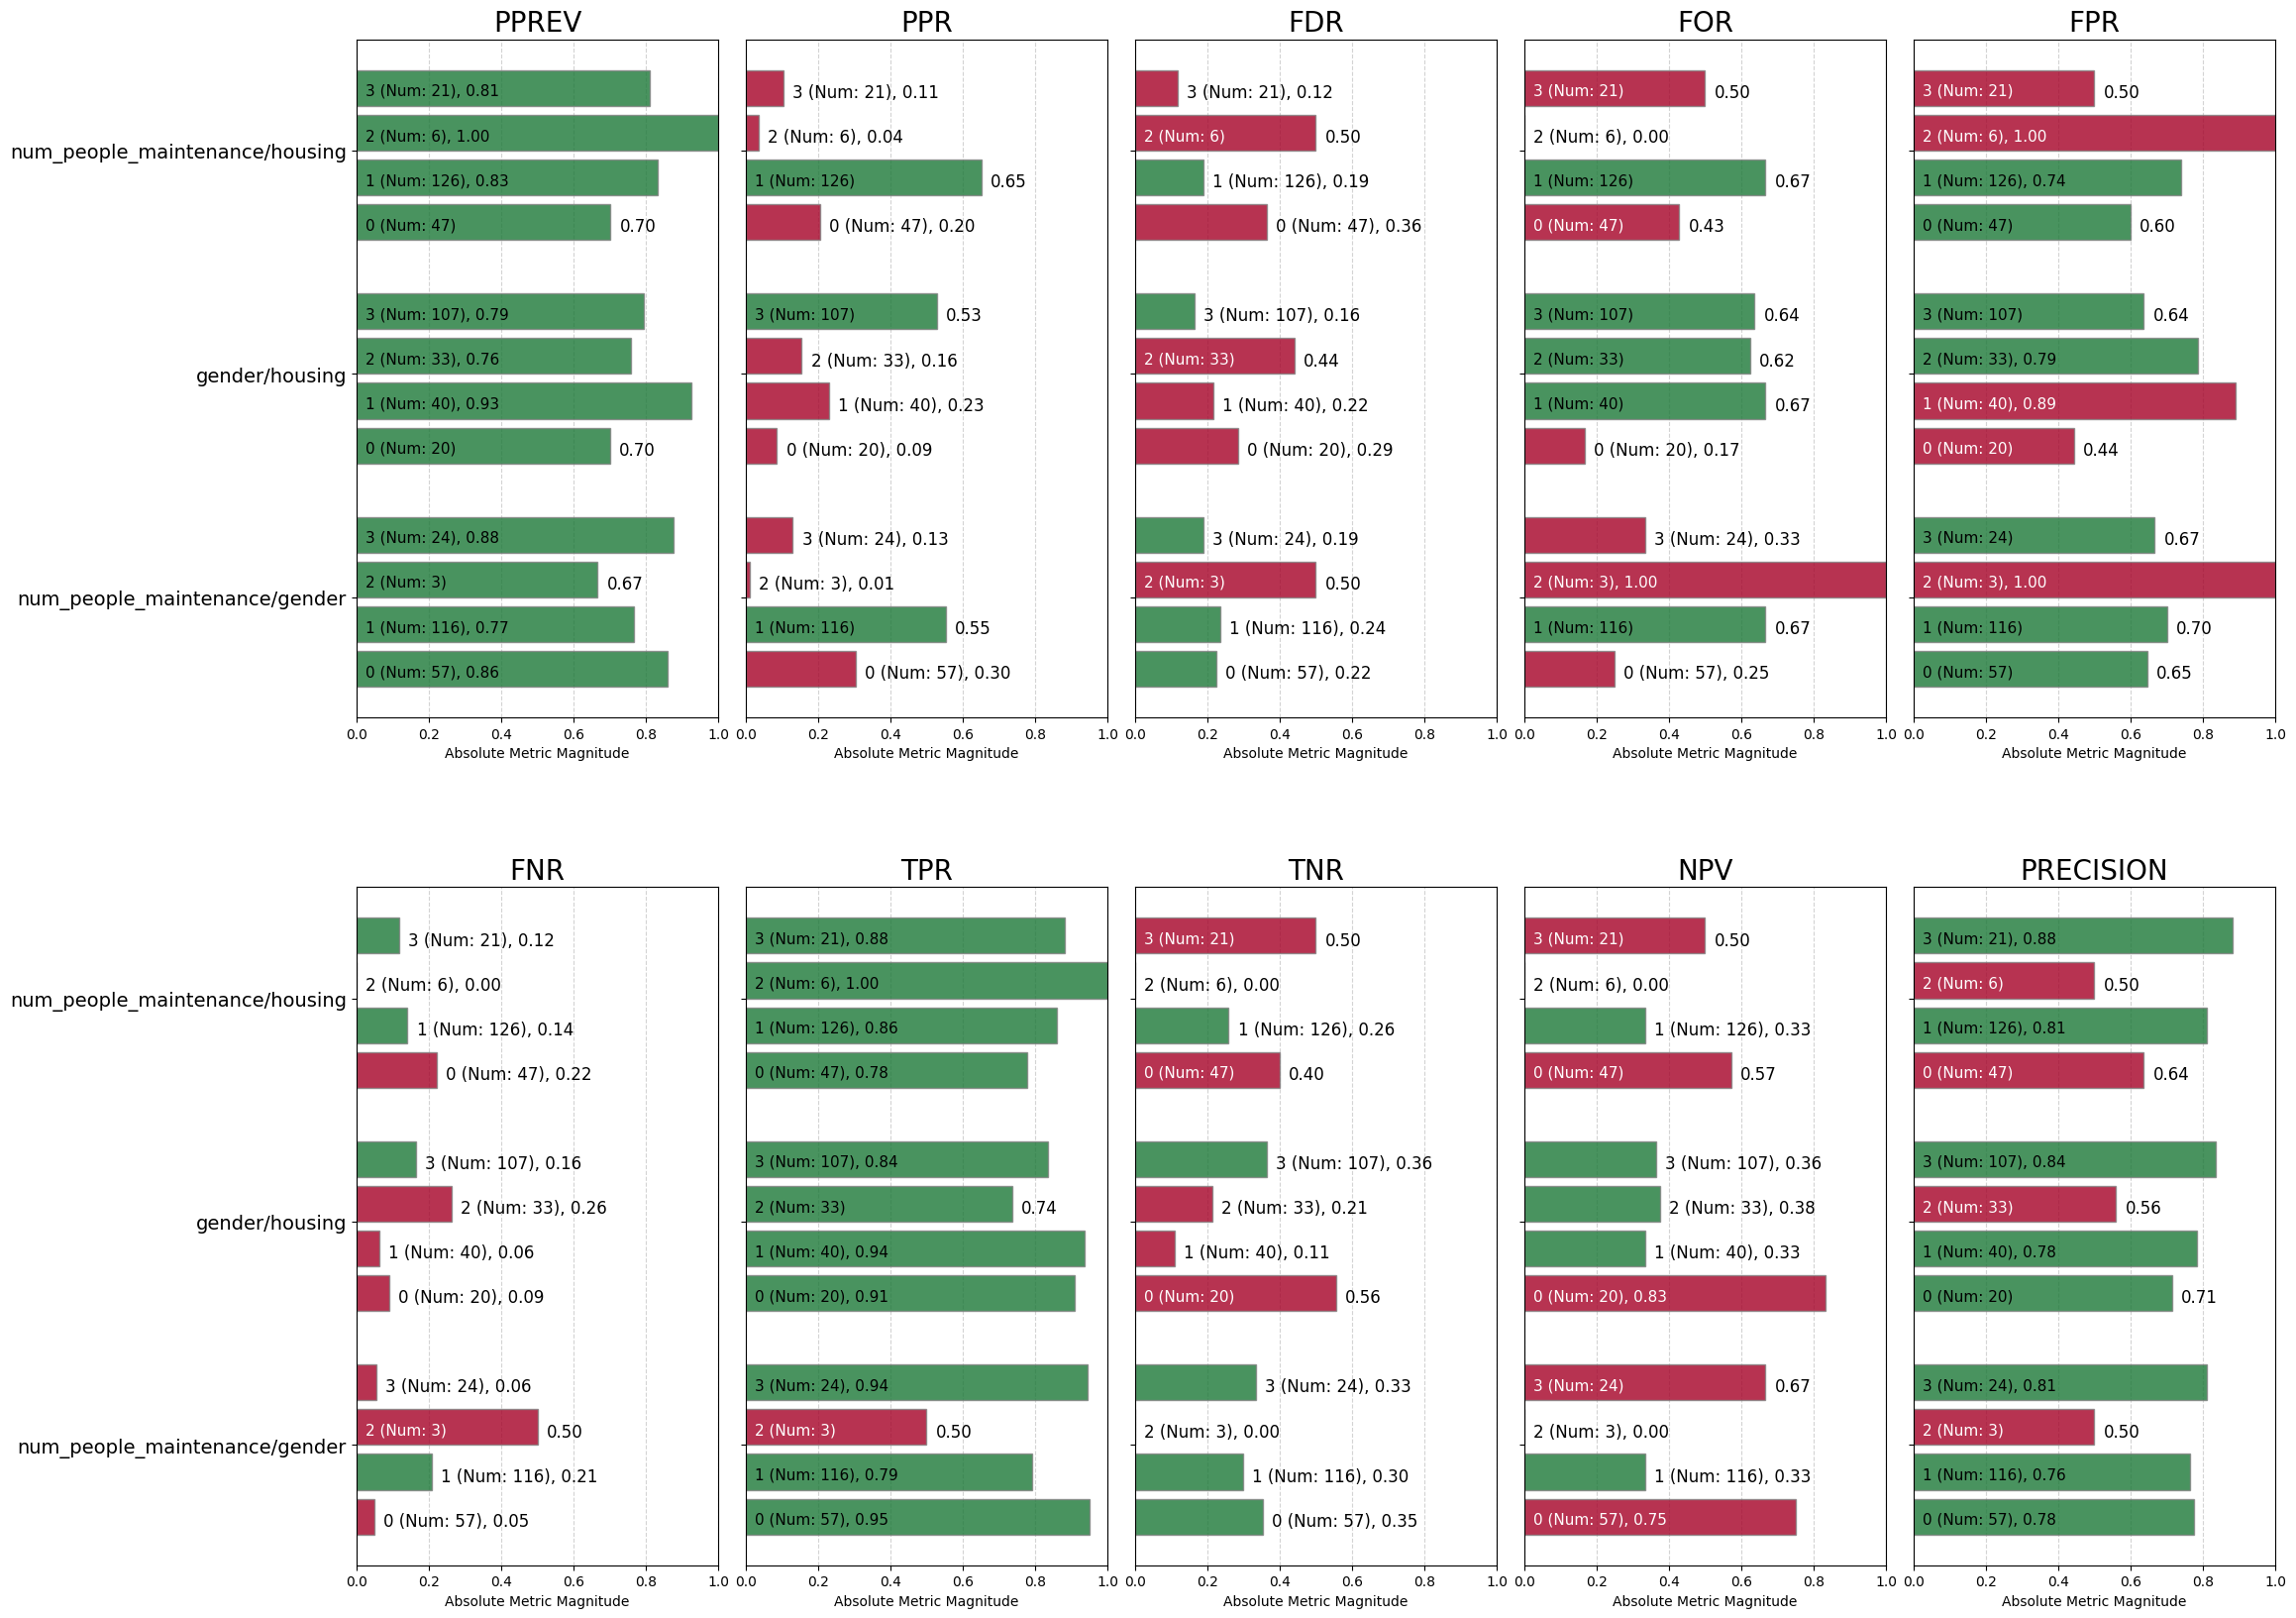

model_id score_threshold                  attribute_name  \
0         0      binary 0/1                  gender/housing   
1         0      binary 0/1   num_people_maintenance/gender   
2         0      binary 0/1  num_people_maintenance/housing   

   Statistical Parity  Impact Parity  FDR Parity  FPR Parity  FOR Parity  \
0               False           True       False       False       False   
1               False           True       False       False       False   
2               False           True       False       False       False   

   FNR Parity  TPR Parity  TNR Parity  NPV Parity  Precision Parity  \
0       False        True       False       False             False   
1       False       False       False       False             False   
2       False        True       False       False             False   

   TypeI Parity  TypeII Parity  Equalized Odds  Unsupervised Fairness  \
0         False          False           False                  False   
1         False          False           False                  False   
2         False          False           False                  False   

   Supervised Fairness  
0                False  
1                False  
2                False

[INFO] 2024-11-20 19:29:23 methods.inprocessing.ExponentiatedGradient - Instantiating estimator '<class 'sklearn.linear_model._logistic.LogisticRegression'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating estimator '<class 'sklearn.linear_model._logistic.LogisticRegression'>' with parameters: {}.


[INFO] 2024-11-20 19:29:23 methods.inprocessing.ExponentiatedGradient - Instantiating constraint '<class 'fairlearn.reductions._moments.utility_parity.ErrorRateParity'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating constraint '<class 'fairlearn.reductions._moments.utility_parity.ErrorRateParity'>' with parameters: {}.


[INFO] 2024-11-20 19:29:23 methods.inprocessing.ExponentiatedGradient - Instantiating reduction '<class 'fairlearn.reductions._exponentiated_gradient.exponentiated_gradient.ExponentiatedGradient'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating reduction '<class 'fairlearn.reductions._exponentiated_gradient.exponentiated_gradient.ExponentiatedGradient'>' with parameters: {}.


Model:
 sklearn.linear_model.LogisticRegression
Accuracy score training:
0.6562
Accuracy score test:
0.7050
Classification report for model: sklearn.linear_model.LogisticRegression : 
               precision    recall  f1-score   support

           0       0.46      0.57      0.51        54
           1       0.83      0.75      0.79       146

    accuracy                           0.70       200
   macro avg       0.64      0.66      0.65       200
weighted avg       0.73      0.70      0.71       200

attribute: num_people_maintenance/housing
Privileged groups:  [{'num_people_maintenance/housing': 1}]
Unprivileged groups:  [{'num_people_maintenance/housing': 2}, {'num_people_maintenance/housing': 3}, {'num_people_maintenance/housing': 0}]
---------- Metrics --------

Disparate Impact Ratio for num_people_maintenance/housing: 0.732
Statistical Parity Difference for num_people_maintenance/housing: -0.198
equalized opportunity difference for num_people_maintenance/housing: -0.107
equ

attribute_name attribute_value  accuracy   tpr   tnr  \
0    num_people_maintenance/gender               0      0.74  0.85  0.47   
1    num_people_maintenance/gender               1      0.72  0.78  0.53   
2    num_people_maintenance/gender               2      0.33  0.00  1.00   
3    num_people_maintenance/gender               3      0.62  0.50  1.00   
4                   gender/housing               0      0.80  0.82  0.78   
5                   gender/housing               1      0.68  0.81  0.22   
6                   gender/housing               2      0.70  0.79  0.57   
7                   gender/housing               3      0.70  0.72  0.64   
8   num_people_maintenance/housing               0      0.74  0.85  0.60   
9   num_people_maintenance/housing               1      0.71  0.79  0.44   
10  num_people_maintenance/housing               2      0.67  0.33  1.00   
11  num_people_maintenance/housing               3      0.57  0.47  1.00   

     for   fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0   0.43  0.21  0.53  0.15  0.57       0.79  0.32   0.75  0.70  
1   0.54  0.17  0.47  0.22  0.46       0.83  0.61   0.70  0.74  
2   0.67   NaN  0.00  1.00  0.33        NaN  0.00   0.00  0.67  
3   0.60  0.00  0.00  0.50  0.40       1.00  0.07   0.38  0.75  
4   0.22  0.18  0.22  0.18  0.78       0.82  0.08   0.55  0.55  
5   0.75  0.22  0.78  0.19  0.25       0.78  0.24   0.80  0.78  
6   0.33  0.29  0.43  0.21  0.67       0.71  0.16   0.64  0.58  
7   0.63  0.12  0.36  0.28  0.37       0.88  0.52   0.64  0.79  
8   0.25  0.26  0.40  0.15  0.75       0.74  0.23   0.66  0.57  
9   0.64  0.16  0.56  0.21  0.36       0.84  0.70   0.74  0.79  
10  0.40  0.00  0.00  0.67  0.60       1.00  0.01   0.17  0.50  
11  0.69  0.00  0.00  0.53  0.31       1.00  0.06   0.38  0.81

Majority class for:  num_people_maintenance/gender  is: 1
Majority class for:  gender/housing  is: 3
Majority class for:  num_people_maintenance/housing  is: 1
[]


attribute_name attribute_value  fdr_disparity  \
0    num_people_maintenance/gender               0           1.21   
1    num_people_maintenance/gender               1           1.00   
2    num_people_maintenance/gender               2            NaN   
3    num_people_maintenance/gender               3           0.00   
4                   gender/housing               0           1.57   
5                   gender/housing               1           1.89   
6                   gender/housing               2           2.46   
7                   gender/housing               3           1.00   
8   num_people_maintenance/housing               0           1.60   
9   num_people_maintenance/housing               1           1.00   
10  num_people_maintenance/housing               2           0.00   
11  num_people_maintenance/housing               3           0.00   

    fnr_disparity  for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            0.68           0.79           1.13           1.25           0.53   
1            1.00           1.00           1.00           1.00           1.00   
2            4.53           1.23           0.00           0.73           0.00   
3            2.26           1.11           0.00           0.88           0.11   
4            0.64           0.35           0.61           2.11           0.16   
5            0.69           1.19           2.14           0.68           0.46   
6            0.75           0.53           1.18           1.81           0.30   
7            1.00           1.00           1.00           1.00           1.00   
8            0.70           0.39           0.72           2.06           0.33   
9            1.00           1.00           1.00           1.00           1.00   
10           3.14           0.63           0.00           1.65           0.01   
11           2.50           1.09           0.00           0.85           0.09   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              1.08                 0.96           0.88           1.09  
1              1.00                 1.00           1.00           1.00  
2              0.00                  NaN           1.88           0.00  
3              0.54                 1.21           1.88           0.64  
4              0.85                 0.93           1.22           1.14  
5              1.24                 0.88           0.35           1.12  
6              0.99                 0.81           0.90           1.10  
7              1.00                 1.00           1.00           1.00  
8              0.89                 0.88           1.35           1.08  
9              1.00                 1.00           1.00           1.00  
10             0.23                 1.19           2.25           0.42  
11             0.52                 1.19           2.25           0.60

                                fnr_disparity  for_disparity
num_people_maintenance/gender        2.490000       1.043333
gender/housing                       0.693333       0.690000
num_people_maintenance/housing       2.113333       0.703333
Overall average for fnr_disparity:  1.766
Overall average for for_disparity:  0.812


<Figure size 640x480 with 0 Axes>

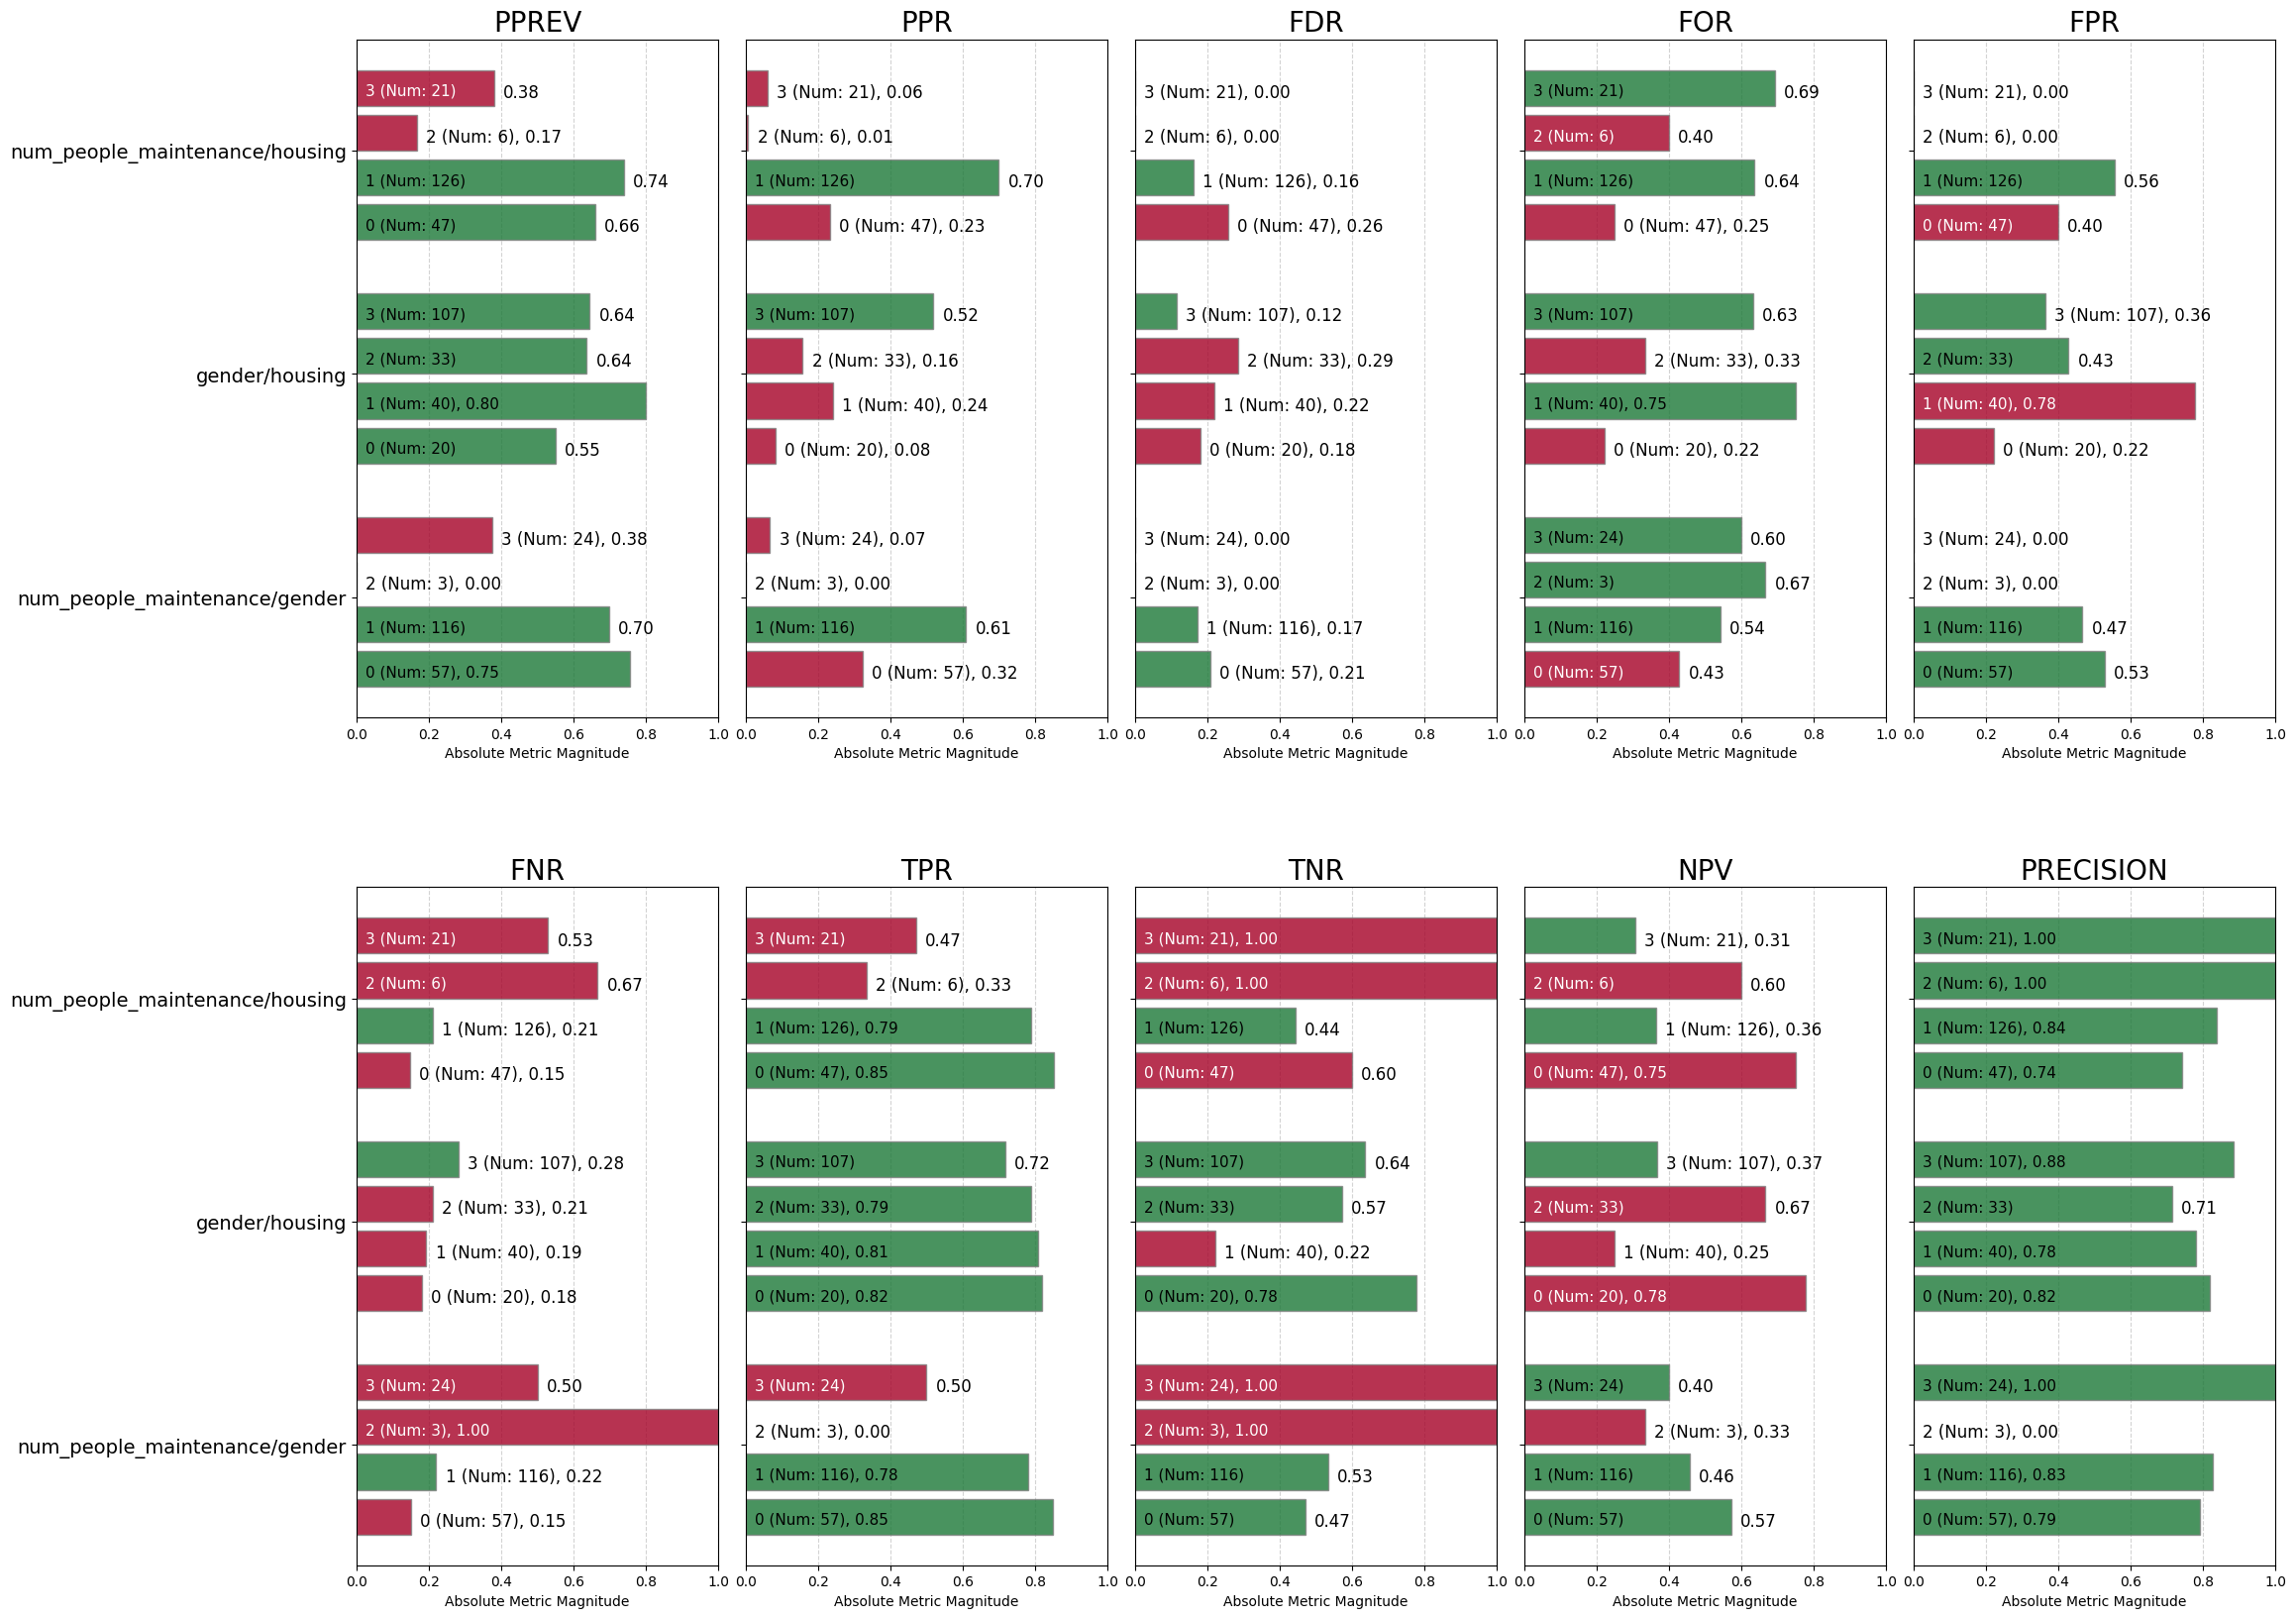

model_id score_threshold                  attribute_name  \
0         0      binary 0/1                  gender/housing   
1         0      binary 0/1   num_people_maintenance/gender   
2         0      binary 0/1  num_people_maintenance/housing   

   Statistical Parity  Impact Parity  FDR Parity  FPR Parity  FOR Parity  \
0               False           True       False       False       False   
1               False          False       False       False       False   
2               False          False       False       False       False   

   FNR Parity  TPR Parity  TNR Parity  NPV Parity  Precision Parity  \
0       False        True       False       False              True   
1       False       False       False       False              True   
2       False       False       False       False              True   

   TypeI Parity  TypeII Parity  Equalized Odds  Unsupervised Fairness  \
0         False          False           False                  False   
1         False          False           False                  False   
2         False          False           False                  False   

   Supervised Fairness  
0                False  
1                False  
2                False

<Figure size 640x480 with 0 Axes>

In [91]:
from aequitas.flow.methods.inprocessing import FairlearnClassifier

'''
In-processing: Fair learn classifier 
'''
data_to_transform = df_num_int.copy()
models = ["sklearn.linear_model.LogisticRegression"]
metrics_dict = {}
x_test_fl, y_test_fl, y_test_pred_fl, metrics_dict_fl =train_with_fairlearn(data_to_transform, protected_attributes_int[0], models[0], metrics_dict,target)
df_test_transformed_fl1 =calc_fairness_report(x_test_fl, y_test_fl, y_test_pred_fl,target,protected_attributes_int,list_of_disparities,priv, display_disp=True)

data_to_transform = df_num_int.copy()
x_test_fl, y_test_fl, y_test_pred_fl, metrics_dict_fl =train_with_fairlearn(data_to_transform, protected_attributes_int[1], models[0], metrics_dict,target)
df_test_transformed_fl2 =calc_fairness_report(x_test_fl, y_test_fl, y_test_pred_fl,target,protected_attributes_int, list_of_disparities,priv, display_disp=True)

data_to_transform = df_num_int.copy()

x_test_fl, y_test_fl, y_test_pred_fl, metrics_dict_fl =train_with_fairlearn(data_to_transform, protected_attributes_int[2], models[0], metrics_dict,target)
df_test_transformed_fl3 =calc_fairness_report(x_test_fl, y_test_fl, y_test_pred_fl,target,protected_attributes_int,list_of_disparities,priv, display_disp=True)



---------- Model name:  LogisticRegression ----------

[INFO] 2024-11-20 19:25:12 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 19:25:12 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 19:25:12 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 19:25:12 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 19:25:12 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 19:25:12 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-20 19:25:12 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 19:25:12 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-20 19:25:12 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 19:25:12 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-20 19:25:12 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 19:25:12 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


attribute: num_people_maintenance/gender
Privileged groups:  [{'num_people_maintenance/gender': 1}]
Unprivileged groups:  [{'num_people_maintenance/gender': 2}, {'num_people_maintenance/gender': 3}, {'num_people_maintenance/gender': 0}]
---------- Metrics --------

Disparate Impact Ratio for num_people_maintenance/gender: 1.270
Statistical Parity Difference for num_people_maintenance/gender: 0.058
equalized opportunity difference for num_people_maintenance/gender: 0.061
equalized ods difference for num_people_maintenance/gender: 0.067
 FNR ratio for num_people_maintenance/gender: 0.918
 FNR privileged for num_people_maintenance/gender: 0.719
 FNR unpriv for num_people_maintenance/gender: 0.683
 FPR ratio for num_people_maintenance/gender: 1.667
 FOR ratio for num_people_maintenance/gender: 0.956
 FDR ratio for num_people_maintenance/gender: 1.449


Average FNR: 0.918
Average FPR: 1.449
Average FOR: 0.956
Average FDR: 1.449
Accuracy score test corrected:
0.3800


attribute_name attribute_value  accuracy   tpr   tnr   for  \
0  num_people_maintenance/gender               0      0.44  0.30  0.76  0.68   
1  num_people_maintenance/gender               1      0.42  0.26  0.90  0.70   
2  num_people_maintenance/gender               2      0.33  0.00  1.00  0.67   
3  num_people_maintenance/gender               3      0.54  0.39  1.00  0.65   

    fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0  0.25  0.24  0.70  0.32       0.75  0.33   0.28  0.70  
1  0.12  0.10  0.74  0.30       0.88  0.52   0.22  0.74  
2   NaN  0.00  1.00  0.33        NaN  0.00   0.00  0.67  
3  0.00  0.00  0.61  0.35       1.00  0.15   0.29  0.75

Majority class for:  num_people_maintenance/gender  is: 1
[]


attribute_name attribute_value  fdr_disparity  \
0  num_people_maintenance/gender               0           2.08   
1  num_people_maintenance/gender               1           1.00   
2  num_people_maintenance/gender               2            NaN   
3  num_people_maintenance/gender               3           0.00   

   fnr_disparity  for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0           0.94           0.97           2.35           1.07           0.64   
1           1.00           1.00           1.00           1.00           1.00   
2           1.34           0.95           0.00           1.12           0.00   
3           0.82           0.92           0.00           1.19           0.28   

   pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0             1.30                 0.85           0.85           1.17  
1             1.00                 1.00           1.00           1.00  
2             0.00                  NaN           1.11           0.00  
3             1.35                 1.14           1.11           1.52

                                fnr_disparity  for_disparity
num_people_maintenance/gender        1.033333       0.946667
gender/housing                            NaN            NaN
num_people_maintenance/housing            NaN            NaN
Overall average for fnr_disparity:  1.033
Overall average for for_disparity:  0.947


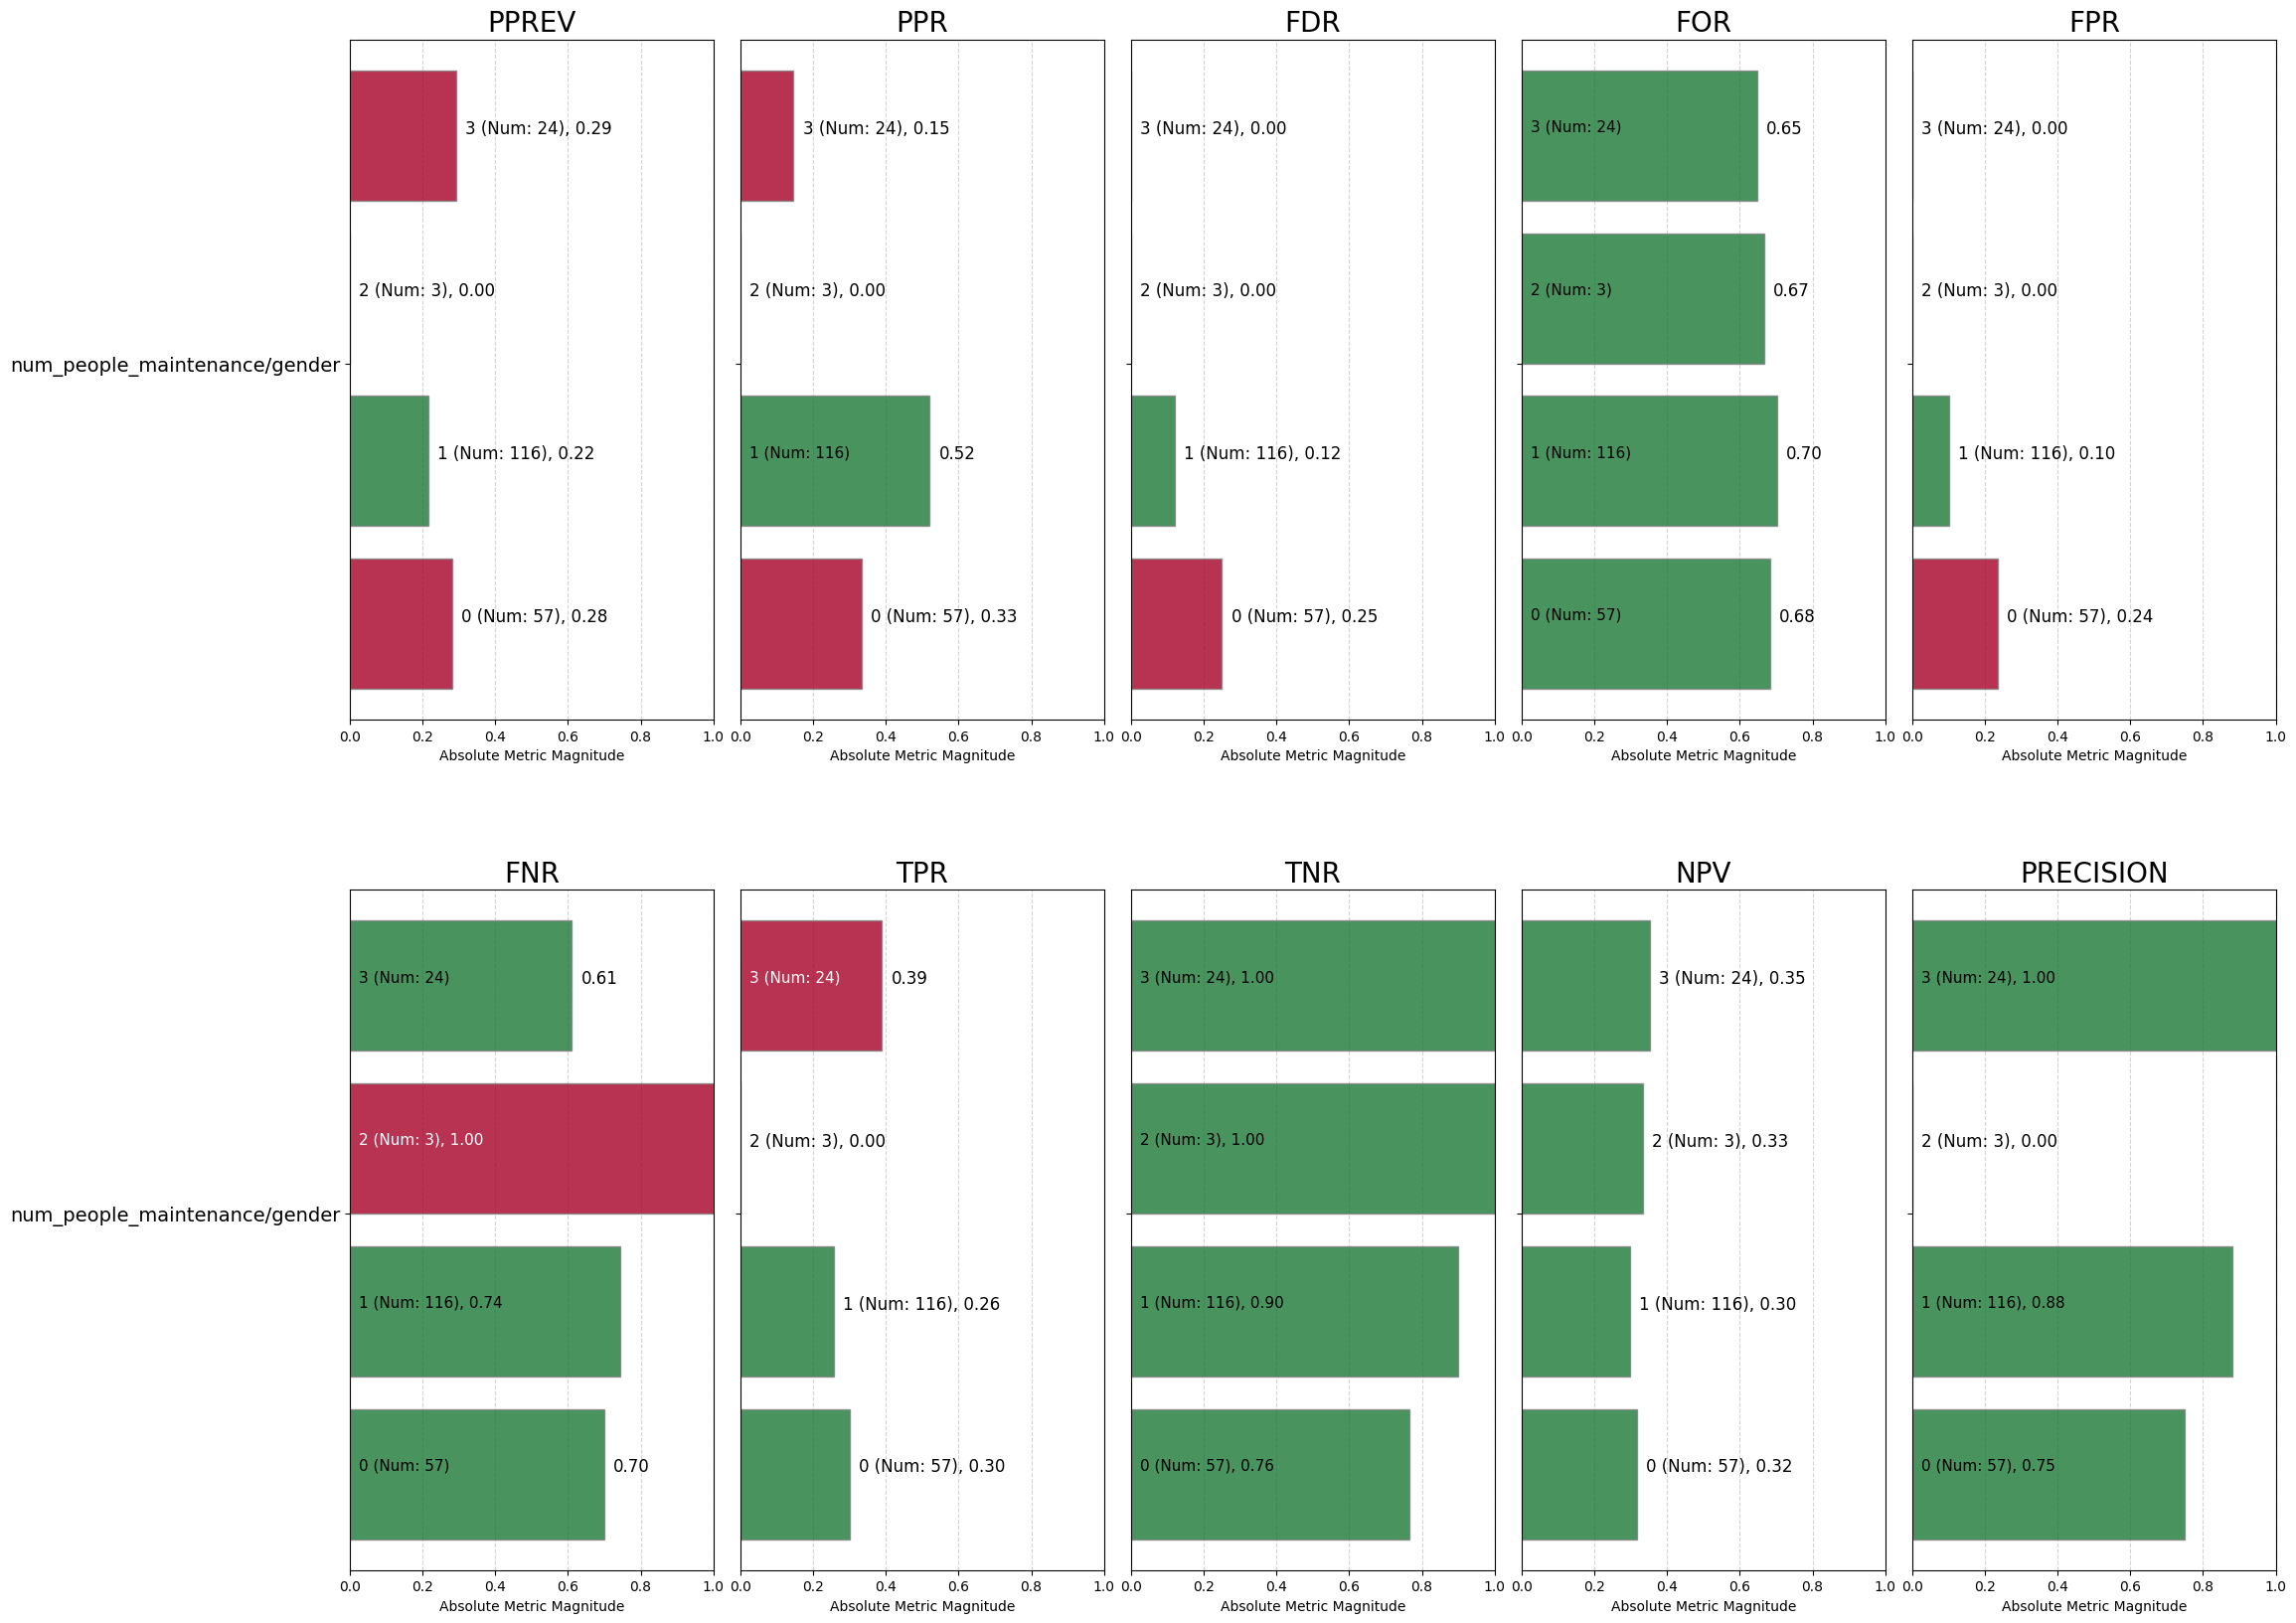

model_id score_threshold                 attribute_name  \
0         0      binary 0/1  num_people_maintenance/gender   

   Statistical Parity  Impact Parity  FDR Parity  FPR Parity  FOR Parity  \
0               False          False       False       False        True   

   FNR Parity  TPR Parity  TNR Parity  NPV Parity  Precision Parity  \
0       False       False        True        True              True   

   TypeI Parity  TypeII Parity  Equalized Odds  Unsupervised Fairness  \
0         False          False           False                  False   

   Supervised Fairness  
0                False

---------- Model name:  LogisticRegression ----------

[INFO] 2024-11-20 19:25:13 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 19:25:13 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 19:25:13 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 19:25:13 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 19:25:13 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 19:25:13 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-20 19:25:13 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 19:25:13 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-20 19:25:13 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 19:25:13 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-20 19:25:13 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 19:25:13 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


attribute: gender/housing
Privileged groups:  [{'gender/housing': 3}]
Unprivileged groups:  [{'gender/housing': 0}, {'gender/housing': 2}, {'gender/housing': 1}]
---------- Metrics --------

Disparate Impact Ratio for gender/housing: 0.900
Statistical Parity Difference for gender/housing: -0.021
equalized opportunity difference for gender/housing: -0.029
equalized ods difference for gender/housing: 0.080
 FNR ratio for gender/housing: 1.040
 FNR privileged for gender/housing: 0.753
 FNR unpriv for gender/housing: 0.770
 FPR ratio for gender/housing: 2.750
 FOR ratio for gender/housing: 0.836
 FDR ratio for gender/housing: 5.111


Average FNR: 1.040
Average FPR: 5.111
Average FOR: 0.836
Average FDR: 5.111
Accuracy score test corrected:
0.3650


attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0  gender/housing               0      0.50  0.18  0.89  0.53  0.33  0.11   
1  gender/housing               1      0.35  0.23  0.78  0.77  0.22  0.22   
2  gender/housing               2      0.55  0.26  0.93  0.52  0.17  0.07   
3  gender/housing               3      0.40  0.26  0.95  0.75  0.04  0.05   

    fnr   npv  precision   ppr  pprev  prev  
0  0.82  0.47       0.67  0.07   0.15  0.55  
1  0.77  0.23       0.78  0.22   0.22  0.78  
2  0.74  0.48       0.83  0.15   0.18  0.58  
3  0.74  0.25       0.96  0.56   0.21  0.79

Majority class for:  gender/housing  is: 3
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  \
0  gender/housing               0           7.67           1.10   
1  gender/housing               1           5.11           1.04   
2  gender/housing               2           3.83           0.99   
3  gender/housing               3           1.00           1.00   

   for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0           0.71           2.44           1.88           0.13   
1           1.03           4.89           0.90           0.39   
2           0.69           1.57           1.93           0.26   
3           1.00           1.00           1.00           1.00   

   pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0             0.70                 0.70           0.93           0.70  
1             1.05                 0.81           0.81           0.87  
2             0.85                 0.87           0.97           1.02  
3             1.00                 1.00           1.00           1.00

                                fnr_disparity  for_disparity
num_people_maintenance/gender             NaN            NaN
gender/housing                       1.043333           0.81
num_people_maintenance/housing            NaN            NaN
Overall average for fnr_disparity:  1.043
Overall average for for_disparity:  0.810


<Figure size 640x480 with 0 Axes>

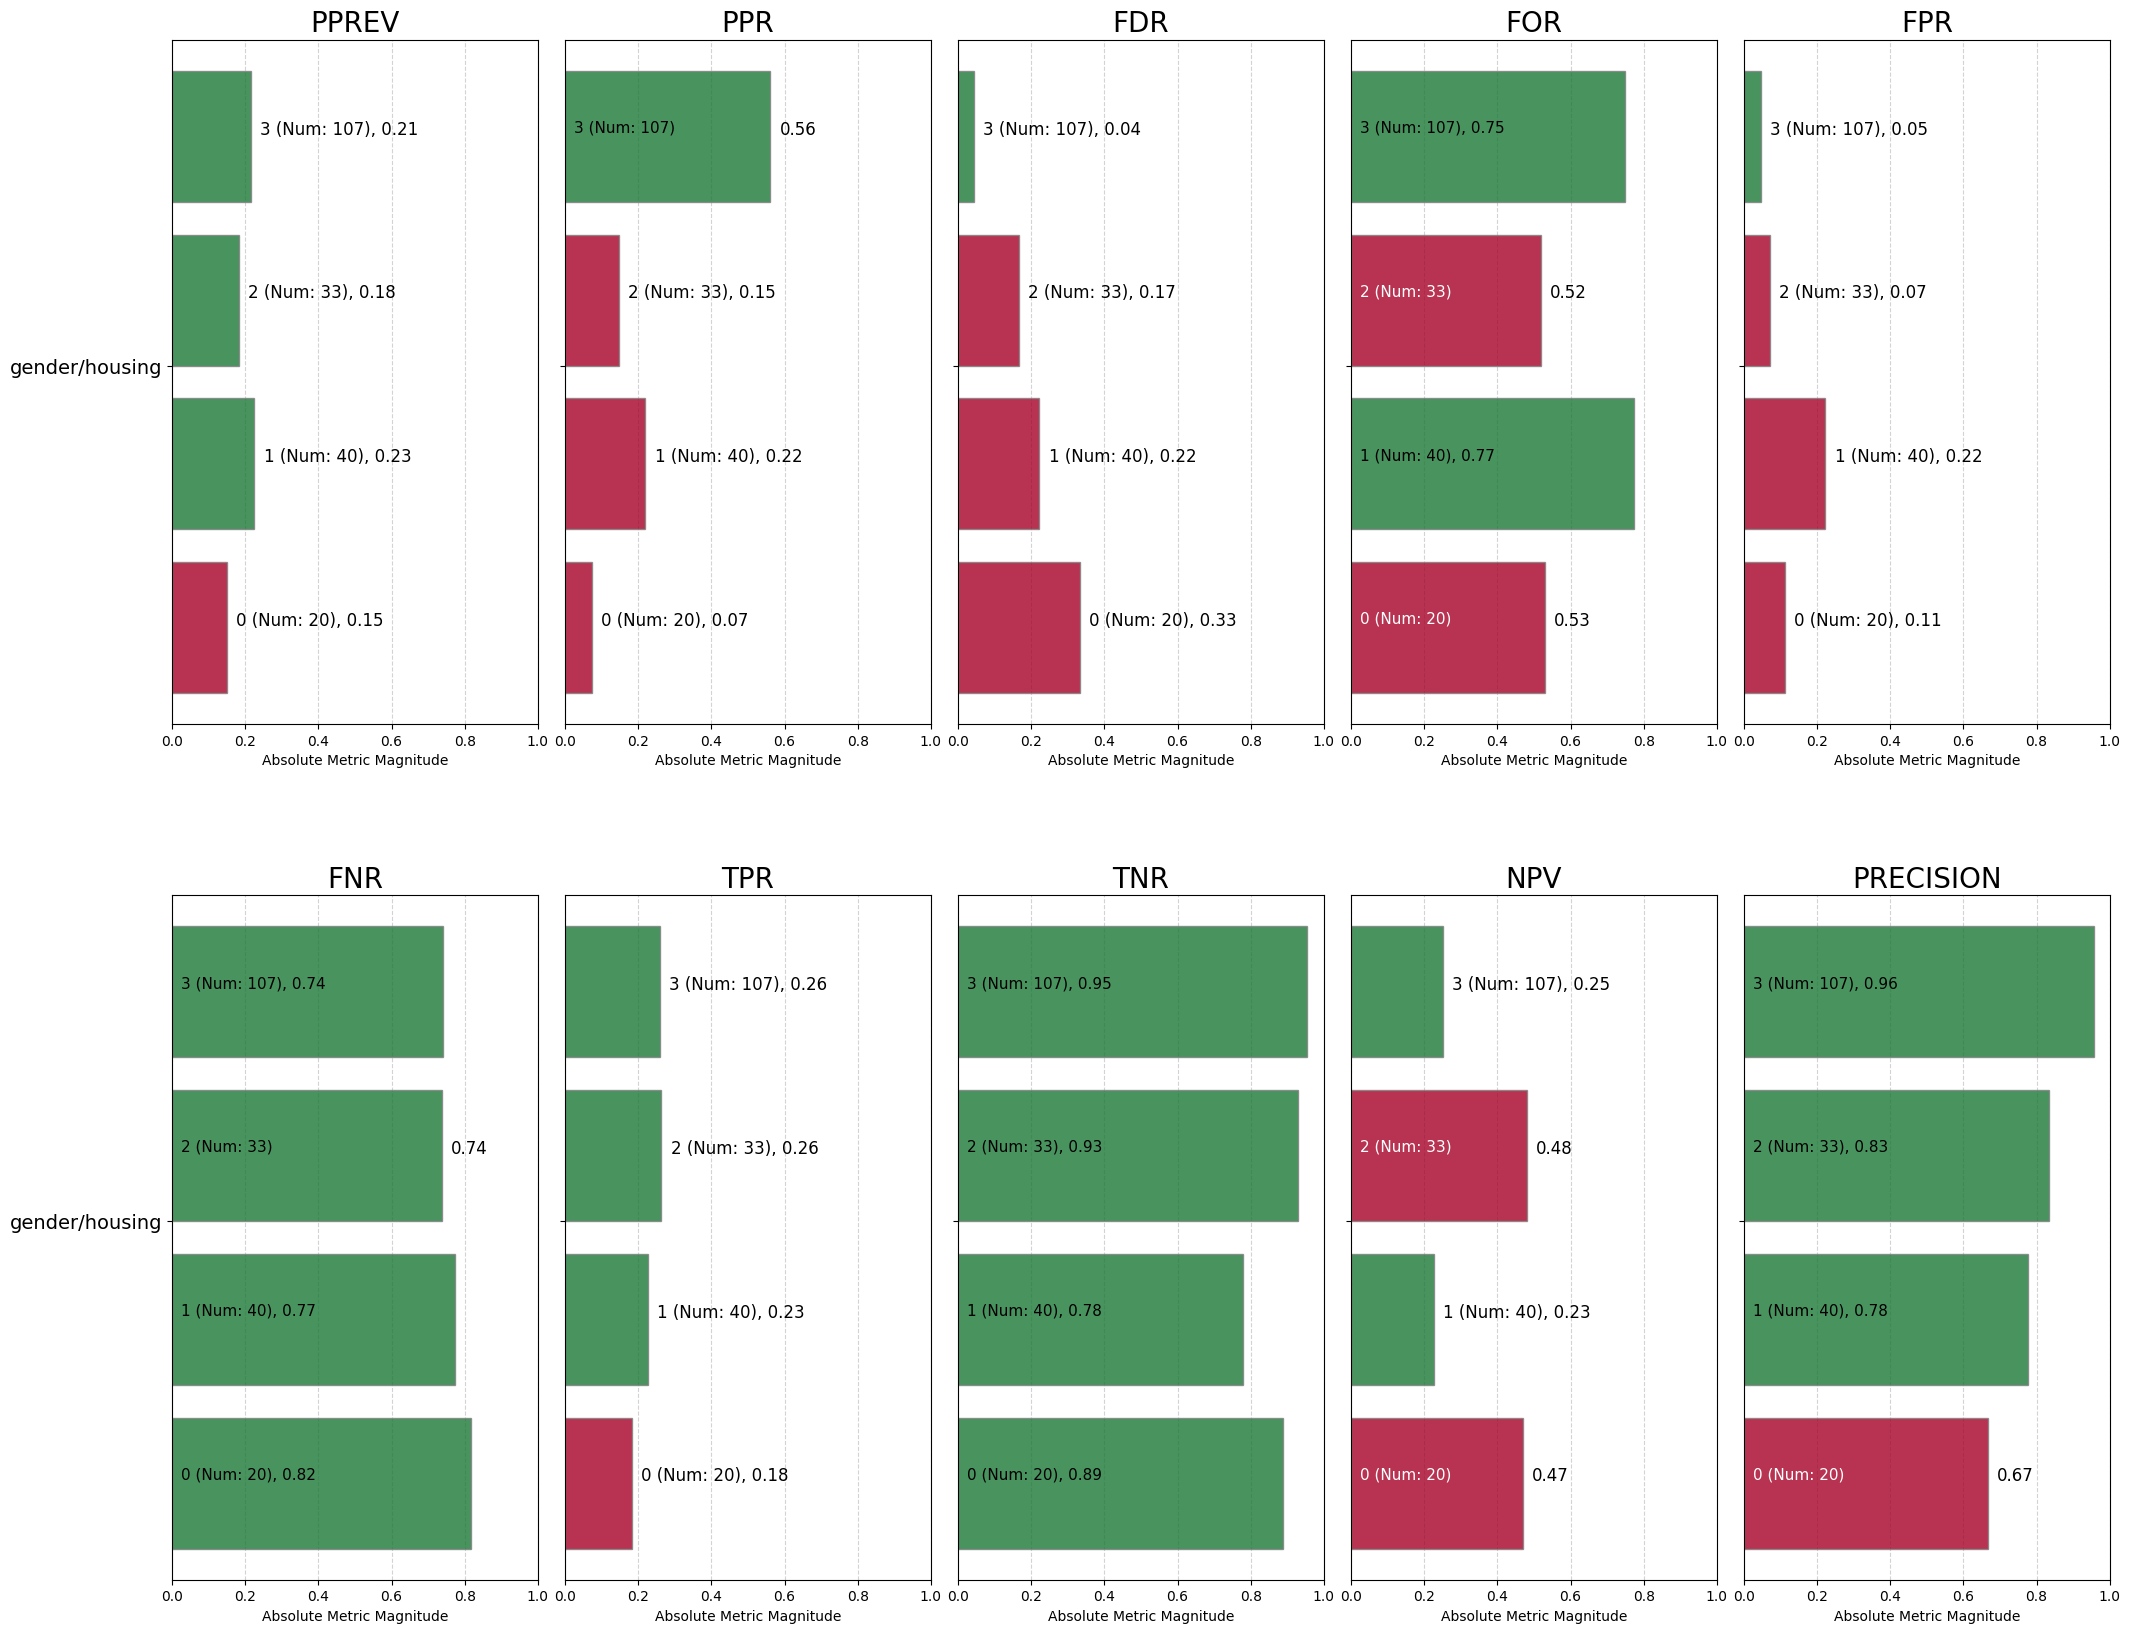

model_id score_threshold  attribute_name  Statistical Parity  \
0         0      binary 0/1  gender/housing               False   

   Impact Parity  FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  \
0          False       False       False       False        True       False   

   TNR Parity  NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  \
0        True       False             False         False          False   

   Equalized Odds  Unsupervised Fairness  Supervised Fairness  
0           False                  False                False

---------- Model name:  LogisticRegression ----------

[INFO] 2024-11-20 19:25:14 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 19:25:14 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 19:25:14 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 19:25:14 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-11-20 19:25:14 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 19:25:14 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-20 19:25:14 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 19:25:14 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-20 19:25:14 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 19:25:14 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-11-20 19:25:14 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-11-20 19:25:14 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


attribute: num_people_maintenance/housing
Privileged groups:  [{'num_people_maintenance/housing': 1}]
Unprivileged groups:  [{'num_people_maintenance/housing': 2}, {'num_people_maintenance/housing': 3}, {'num_people_maintenance/housing': 0}]
---------- Metrics --------

Disparate Impact Ratio for num_people_maintenance/housing: 1.292
Statistical Parity Difference for num_people_maintenance/housing: 0.067
equalized opportunity difference for num_people_maintenance/housing: 0.152
equalized ods difference for num_people_maintenance/housing: 0.152
 FNR ratio for num_people_maintenance/housing: 0.797
 FNR privileged for num_people_maintenance/housing: 0.699
 FNR unpriv for num_people_maintenance/housing: 0.596
 FPR ratio for num_people_maintenance/housing: 0.750
 FOR ratio for num_people_maintenance/housing: 0.706
 FDR ratio for num_people_maintenance/housing: 0.989


Average FNR: 0.797
Average FPR: 0.989
Average FOR: 0.706
Average FDR: 0.989
Accuracy score test corrected:
0.3550


attribute_name attribute_value  accuracy   tpr   tnr   for  \
0  num_people_maintenance/housing               0      0.53  0.26  0.90  0.53   
1  num_people_maintenance/housing               1      0.38  0.25  0.85  0.76   
2  num_people_maintenance/housing               2      0.67  0.33  1.00  0.40   
3  num_people_maintenance/housing               3      0.67  0.65  0.75  0.67   

    fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0  0.22  0.10  0.74  0.47       0.78  0.18   0.19  0.57  
1  0.14  0.15  0.75  0.24       0.86  0.57   0.23  0.79  
2  0.00  0.00  0.67  0.60       1.00  0.02   0.17  0.50  
3  0.08  0.25  0.35  0.33       0.92  0.24   0.57  0.81

Majority class for:  num_people_maintenance/housing  is: 1
[]


attribute_name attribute_value  fdr_disparity  \
0  num_people_maintenance/housing               0           1.61   
1  num_people_maintenance/housing               1           1.00   
2  num_people_maintenance/housing               2           0.00   
3  num_people_maintenance/housing               3           0.60   

   fnr_disparity  for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0           0.99           0.69           0.68           2.00           0.31   
1           1.00           1.00           1.00           1.00           1.00   
2           0.89           0.52           0.00           2.53           0.03   
3           0.47           0.87           1.69           1.41           0.41   

   pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0             0.83                 0.90           1.06           1.03  
1             1.00                 1.00           1.00           1.00  
2             0.72                 1.16           1.17           1.32  
3             2.48                 1.06           0.88           2.56

                                fnr_disparity  for_disparity
num_people_maintenance/gender             NaN            NaN
gender/housing                            NaN            NaN
num_people_maintenance/housing       0.783333       0.693333
Overall average for fnr_disparity:  0.783
Overall average for for_disparity:  0.693


<Figure size 640x480 with 0 Axes>

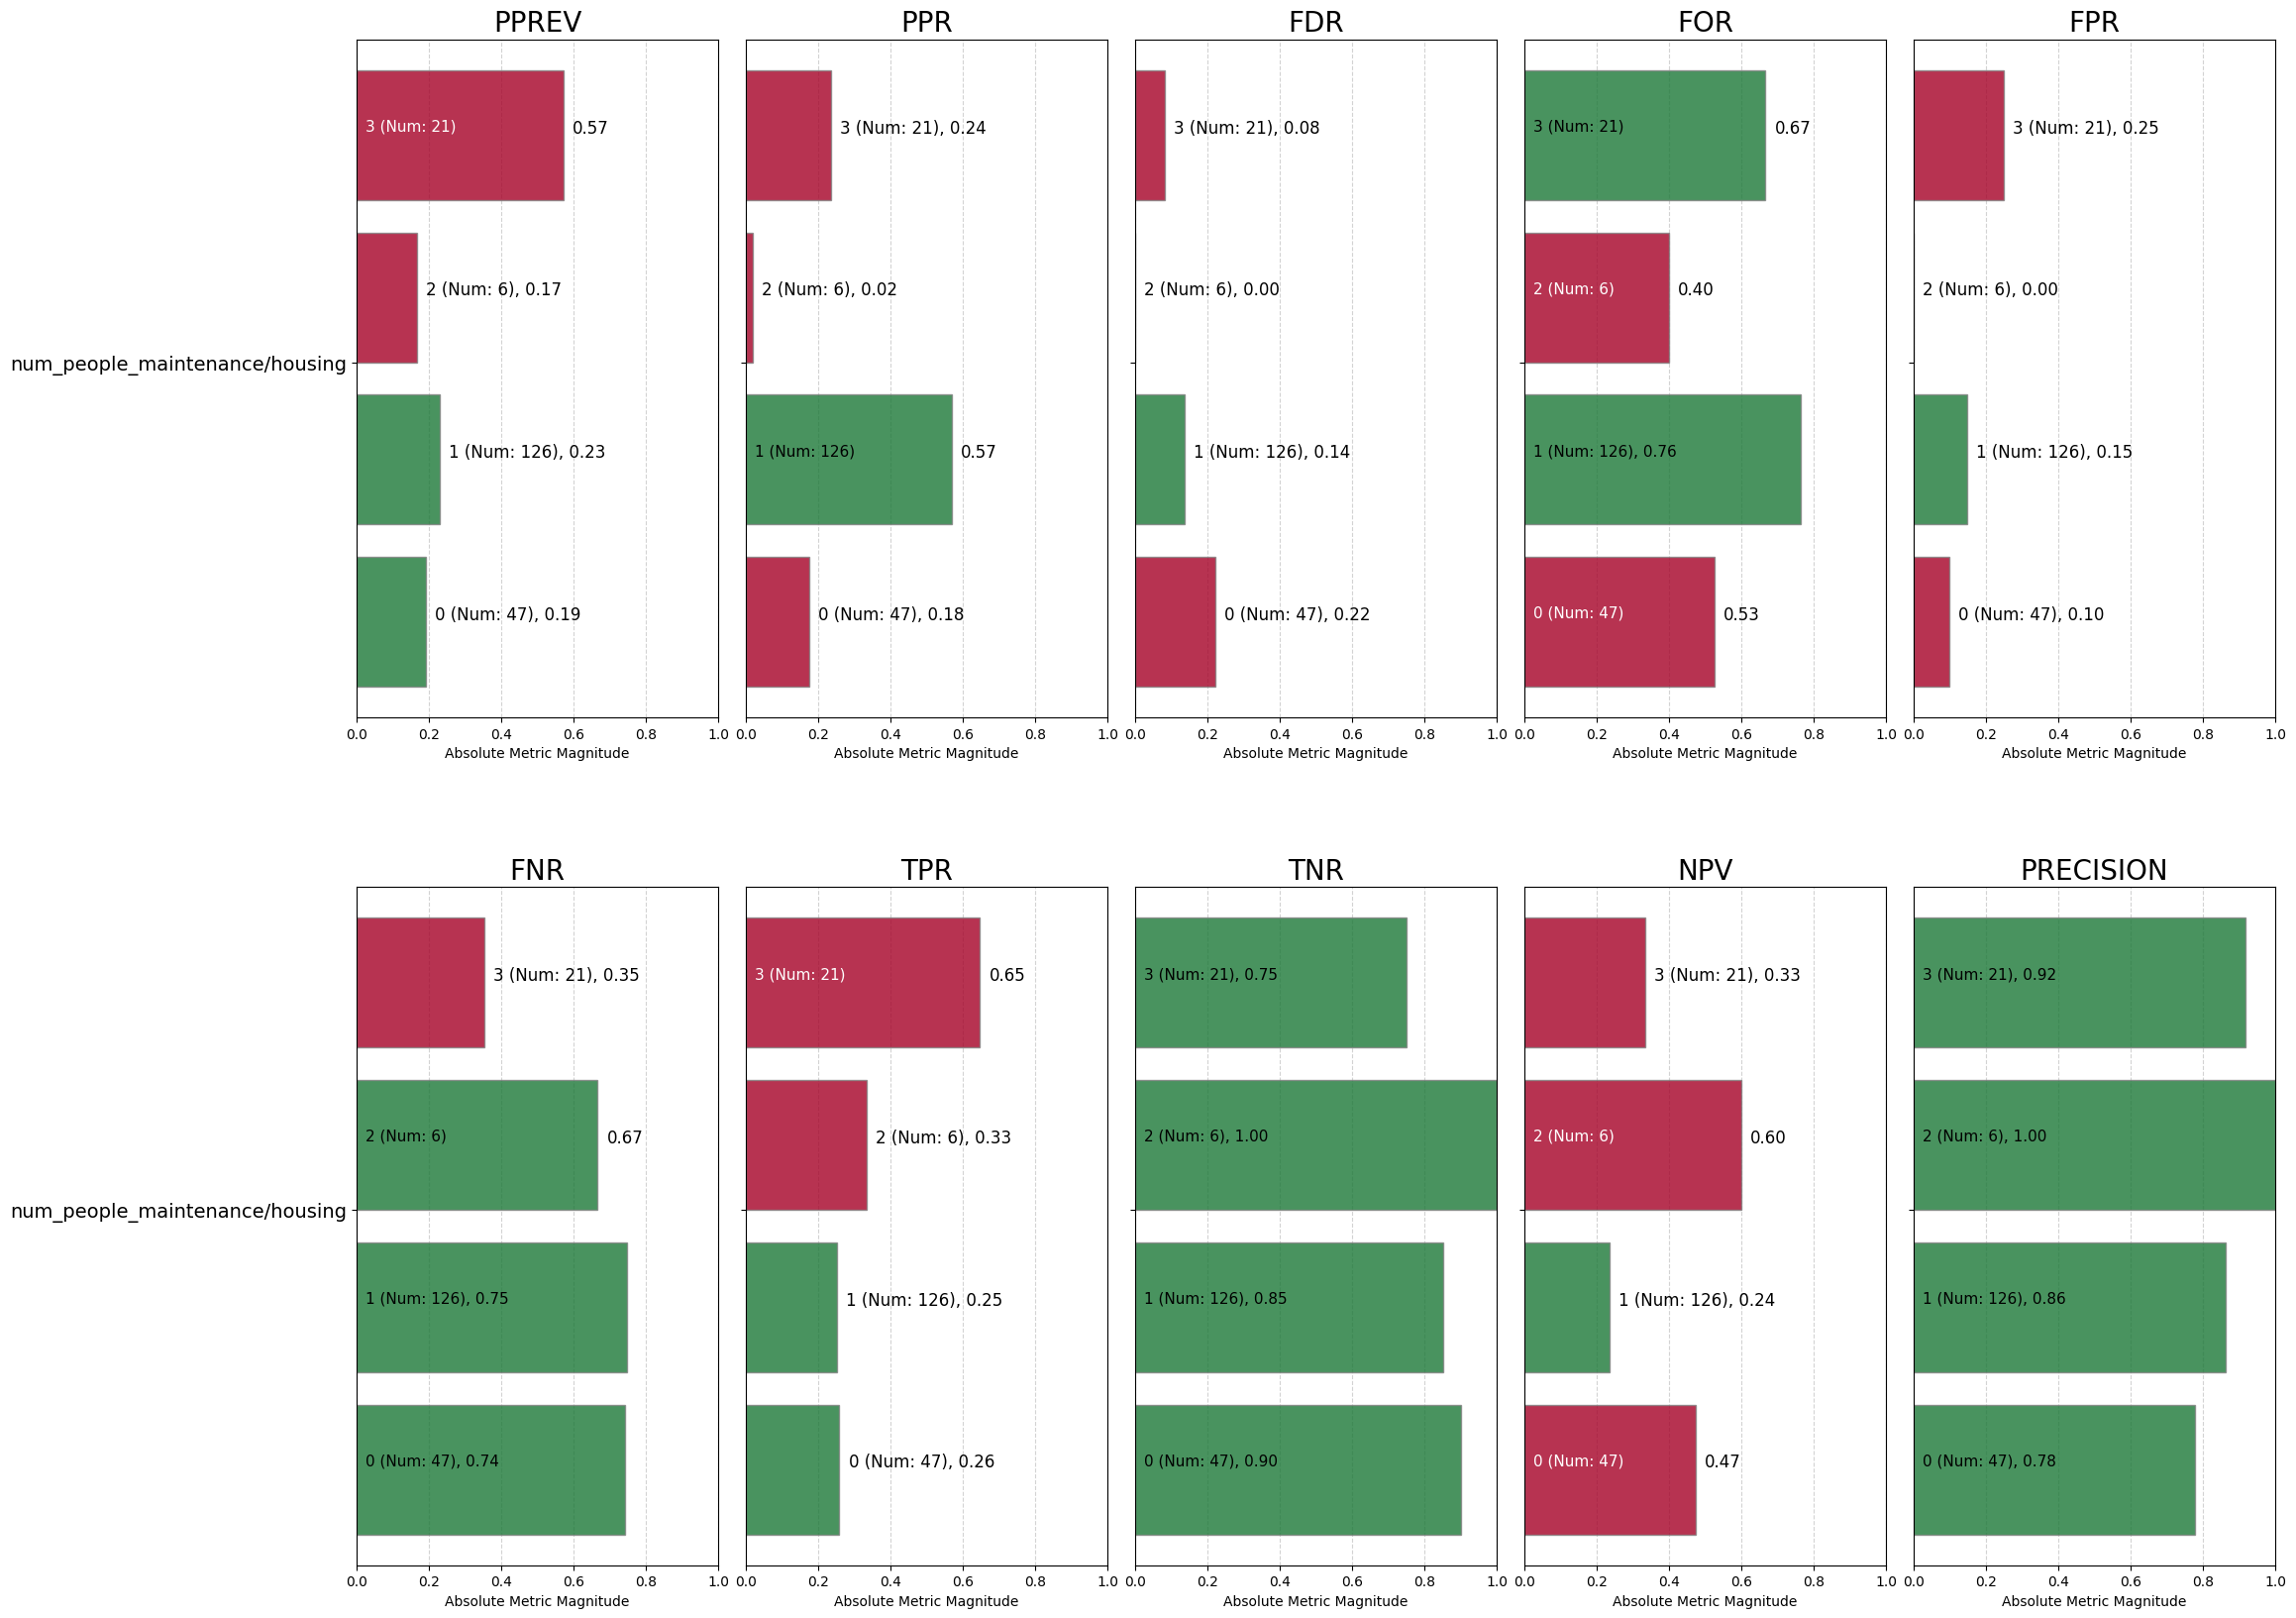

model_id score_threshold                  attribute_name  \
0         0      binary 0/1  num_people_maintenance/housing   

   Statistical Parity  Impact Parity  FDR Parity  FPR Parity  FOR Parity  \
0               False          False       False       False       False   

   FNR Parity  TPR Parity  TNR Parity  NPV Parity  Precision Parity  \
0       False       False        True       False              True   

   TypeI Parity  TypeII Parity  Equalized Odds  Unsupervised Fairness  \
0         False          False           False                  False   

   Supervised Fairness  
0                False

<Figure size 640x480 with 0 Axes>

In [86]:
df_test_aequitas = post_process_group_threshold_aequitas(df_num_int, protected_attributes_int[0], target,priv,list_of_disparities)
df_test_aequitas = post_process_group_threshold_aequitas(df_num_int,  protected_attributes_int[1], target,priv,list_of_disparities)
df_test_aequitas = post_process_group_threshold_aequitas(df_num_int,  protected_attributes_int[2], target,priv, list_of_disparities)

---------- Model name:  LogisticRegression ----------

Accuracy score test corrected:
0.6550
attribute: num_people_maintenance/gender
Privileged groups:  [{'num_people_maintenance/gender': 1}]
Unprivileged groups:  [{'num_people_maintenance/gender': 2}, {'num_people_maintenance/gender': 3}, {'num_people_maintenance/gender': 0}]
---------- Metrics --------

Disparate Impact Ratio for num_people_maintenance/gender: 0.973
Statistical Parity Difference for num_people_maintenance/gender: -0.017
equalized opportunity difference for num_people_maintenance/gender: -0.019
equalized ods difference for num_people_maintenance/gender: 0.019
 FNR ratio for num_people_maintenance/gender: 1.062
 FNR privileged for num_people_maintenance/gender: 0.322
 FNR unpriv for num_people_maintenance/gender: 0.333
 FPR ratio for num_people_maintenance/gender: 1.042
 FOR ratio for num_people_maintenance/gender: 0.980
 FDR ratio for num_people_maintenance/gender: 1.183


attribute: gender/housing
Privileged groups:

attribute_name attribute_value  accuracy   tpr   tnr  \
0    num_people_maintenance/gender               0      0.60  0.60  0.59   
1    num_people_maintenance/gender               1      0.66  0.69  0.60   
2    num_people_maintenance/gender               2      0.67  0.50  1.00   
3    num_people_maintenance/gender               3      0.75  0.83  0.50   
4                   gender/housing               0      0.60  0.55  0.67   
5                   gender/housing               1      0.60  0.61  0.56   
6                   gender/housing               2      0.70  0.74  0.64   
7                   gender/housing               3      0.67  0.71  0.55   
8   num_people_maintenance/housing               0      0.64  0.63  0.65   
9   num_people_maintenance/housing               1      0.64  0.67  0.56   
10  num_people_maintenance/housing               2      0.83  1.00  0.67   
11  num_people_maintenance/housing               3      0.71  0.76  0.50   

     for   fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0   0.62  0.23  0.41  0.40  0.38       0.77  0.26   0.54  0.70  
1   0.60  0.17  0.40  0.31  0.40       0.83  0.59   0.61  0.74  
2   0.50  0.00  0.00  0.50  0.50       1.00  0.01   0.33  0.67  
3   0.50  0.17  0.50  0.17  0.50       0.83  0.15   0.75  0.75  
4   0.45  0.33  0.33  0.45  0.55       0.67  0.07   0.45  0.55  
5   0.71  0.17  0.44  0.39  0.29       0.83  0.19   0.57  0.78  
6   0.36  0.26  0.36  0.26  0.64       0.74  0.16   0.58  0.58  
7   0.68  0.14  0.45  0.29  0.32       0.86  0.58   0.65  0.79  
8   0.43  0.29  0.35  0.37  0.57       0.71  0.20   0.51  0.57  
9   0.69  0.15  0.44  0.33  0.31       0.85  0.64   0.62  0.79  
10  0.00  0.25  0.33  0.00  1.00       0.75  0.03   0.67  0.50  
11  0.67  0.13  0.50  0.24  0.33       0.87  0.12   0.71  0.81

Majority class for:  num_people_maintenance/gender  is: 1
Majority class for:  gender/housing  is: 3
Majority class for:  num_people_maintenance/housing  is: 1
[]


attribute_name attribute_value  fdr_disparity  \
0    num_people_maintenance/gender               0           1.34   
1    num_people_maintenance/gender               1           1.00   
2    num_people_maintenance/gender               2           0.00   
3    num_people_maintenance/gender               3           0.99   
4                   gender/housing               0           2.33   
5                   gender/housing               1           1.22   
6                   gender/housing               2           1.84   
7                   gender/housing               3           1.00   
8   num_people_maintenance/housing               0           1.90   
9   num_people_maintenance/housing               1           1.00   
10  num_people_maintenance/housing               2           1.62   
11  num_people_maintenance/housing               3           0.87   

    fnr_disparity  for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            1.27           1.03           1.03           0.96           0.44   
1            1.00           1.00           1.00           1.00           1.00   
2            1.59           0.83           0.00           1.25           0.01   
3            0.53           0.83           1.25           1.25           0.25   
4            1.55           0.67           0.73           1.68           0.13   
5            1.32           1.04           0.98           0.91           0.33   
6            0.89           0.53           0.79           1.98           0.27   
7            1.00           1.00           1.00           1.00           1.00   
8            1.11           0.63           0.79           1.81           0.31   
9            1.00           1.00           1.00           1.00           1.00   
10           0.00           0.00           0.75           3.20           0.05   
11           0.71           0.97           1.12           1.07           0.19   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              0.89                 0.93           0.98           0.87  
1              1.00                 1.00           1.00           1.00  
2              0.54                 1.20           1.67           0.73  
3              1.23                 1.00           0.83           1.21  
4              0.69                 0.78           1.22           0.77  
5              0.88                 0.96           1.02           0.87  
6              0.88                 0.86           1.18           1.04  
7              1.00                 1.00           1.00           1.00  
8              0.82                 0.84           1.17           0.94  
9              1.00                 1.00           1.00           1.00  
10             1.08                 0.89           1.20           1.50  
11             1.15                 1.02           0.90           1.15

                                fnr_disparity  for_disparity
num_people_maintenance/gender        1.130000       0.896667
gender/housing                       1.253333       0.746667
num_people_maintenance/housing       0.606667       0.533333
Overall average for fnr_disparity:  0.997
Overall average for for_disparity:  0.726


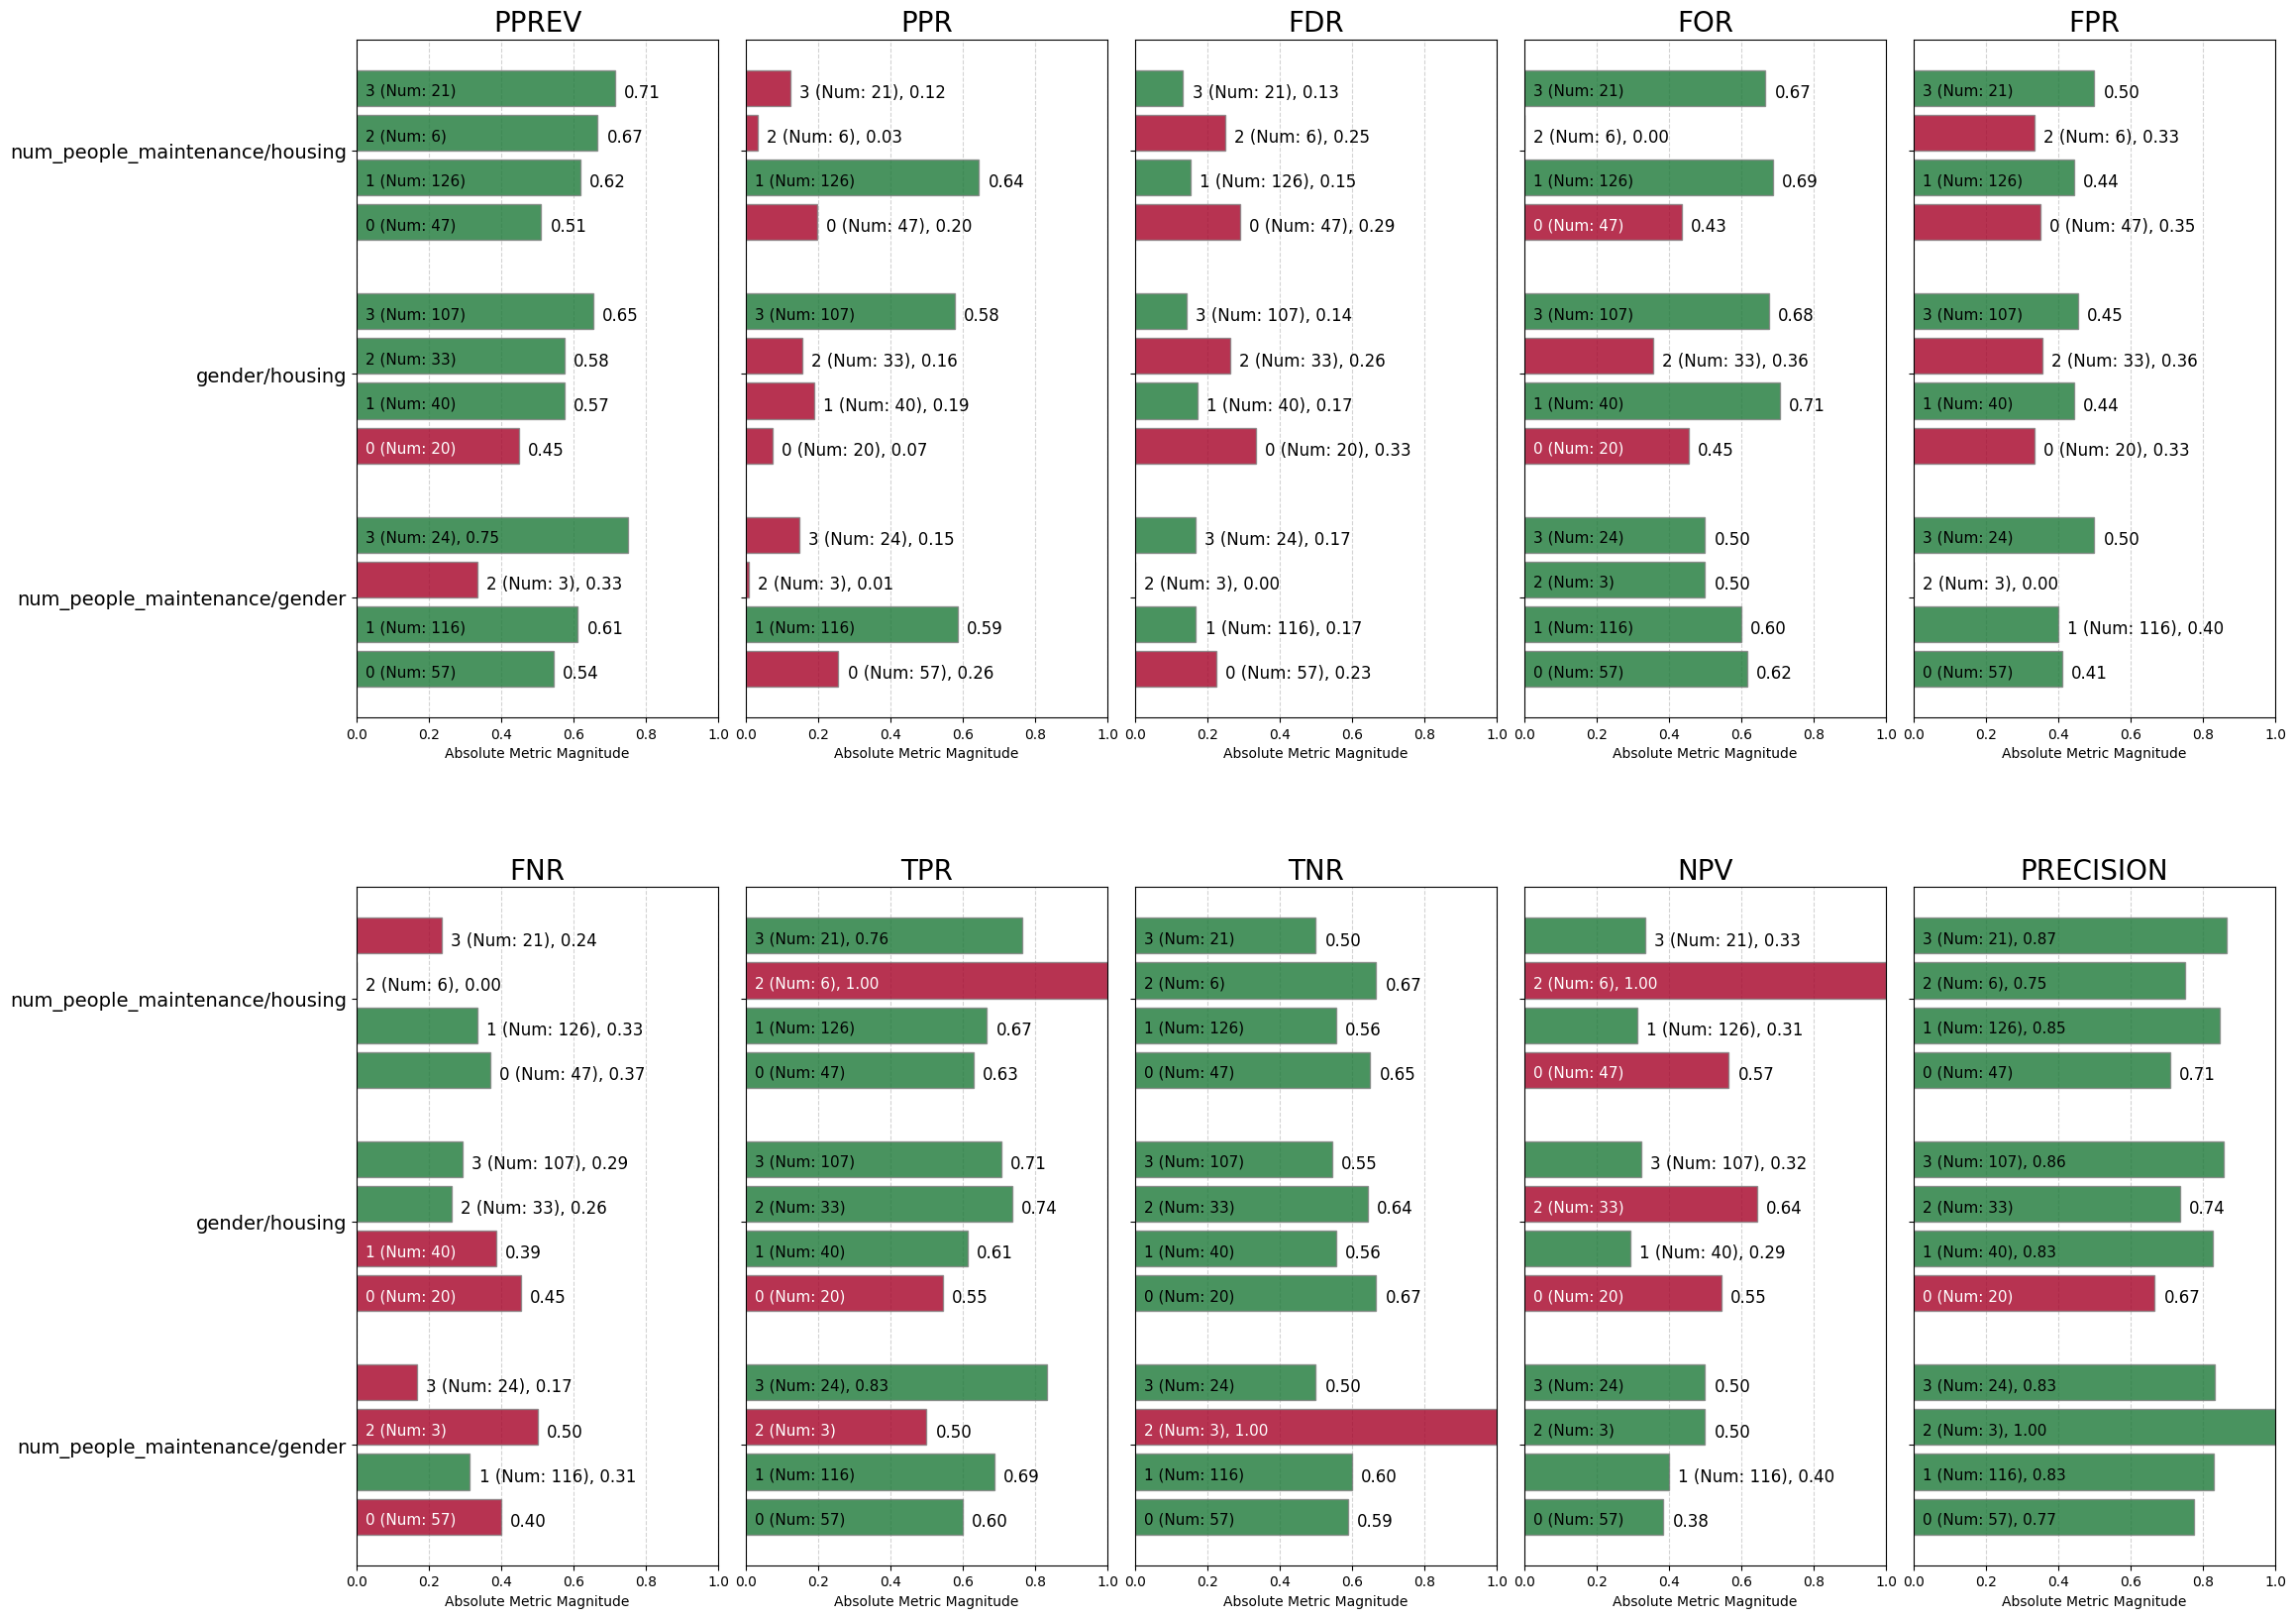

model_id score_threshold                  attribute_name  \
0         0      binary 0/1                  gender/housing   
1         0      binary 0/1   num_people_maintenance/gender   
2         0      binary 0/1  num_people_maintenance/housing   

   Statistical Parity  Impact Parity  FDR Parity  FPR Parity  FOR Parity  \
0               False          False       False       False       False   
1               False          False       False       False        True   
2               False           True       False       False       False   

   FNR Parity  TPR Parity  TNR Parity  NPV Parity  Precision Parity  \
0       False       False        True       False             False   
1       False       False       False        True              True   
2       False       False        True       False              True   

   TypeI Parity  TypeII Parity  Equalized Odds  Unsupervised Fairness  \
0         False          False           False                  False   
1         False          False           False                  False   
2         False          False           False                  False   

   Supervised Fairness  
0                False  
1                False  
2                False

score  label_value num_people_maintenance/gender gender/housing  \
785    1.0            1                             1              3   
945    1.0            1                             1              3   
65     1.0            1                             1              3   
873    1.0            1                             3              3   
859    1.0            1                             3              3   
..     ...          ...                           ...            ...   
247    0.0            1                             0              1   
299    0.0            1                             0              0   
738    0.0            1                             0              1   
264    0.0            1                             0              1   
150    0.0            1                             0              0   

    num_people_maintenance/housing  rank_abs  rank_pct  binary_score  \
785                              1         1     0.005             1   
945                              1         2     0.010             1   
65                               1         3     0.015             1   
873                              3         4     0.020             1   
859                              3         5     0.025             1   
..                             ...       ...       ...           ...   
247                              1       196     0.980             0   
299                              0       197     0.985             0   
738                              1       198     0.990             0   
264                              1       199     0.995             0   
150                              0       200     1.000             0   

     binary_fpr  binary_fnr  binary_fdr  binary_for  binary_npv  binary_ppr  \
785         0.0         NaN         0.0         NaN         NaN           1   
945         0.0         NaN         0.0         NaN         NaN           1   
65          0.0         NaN         0.0         NaN         NaN           1   
873         0.0         NaN         0.0         NaN         NaN           1   
859         0.0         NaN         0.0         NaN         NaN           1   
..          ...         ...         ...         ...         ...         ...   
247         NaN         1.0         NaN         1.0         1.0           0   
299         NaN         1.0         NaN         1.0         1.0           0   
738         NaN         1.0         NaN         1.0         1.0           0   
264         NaN         1.0         NaN         1.0         1.0           0   
150         NaN         1.0         NaN         1.0         1.0           0   

     binary_tnr  binary_tpr  binary_precision  binary_pprev  
785         0.0         NaN               0.0             1  
945         0.0         NaN               0.0             1  
65          0.0         NaN               0.0             1  
873         0.0         NaN               0.0             1  
859         0.0         NaN               0.0             1  
..          ...         ...               ...           ...  
247         NaN         1.0               NaN             0  
299         NaN         1.0               NaN             0  
738         NaN         1.0               NaN             0  
264         NaN         1.0               NaN             0  
150         NaN         1.0               NaN             0  

[200 rows x 18 columns]

<Figure size 640x480 with 0 Axes>

In [87]:
post_process_group_threshold_fairlearn(data=df_num_int,attributes=protected_attributes_int,target=target, list_of_disparities=list_of_disparities,priv=priv)

---------- Model name:  LogisticRegression ----------

Privileged groups:  [{'num_people_maintenance/gender': 1}]
Unprivileged groups:  [{'num_people_maintenance/gender': 2}, {'num_people_maintenance/gender': 3}, {'num_people_maintenance/gender': 0}]
Accuracy score test corrected:
0.7200
attribute: num_people_maintenance/gender
Privileged groups:  [{'num_people_maintenance/gender': 1}]
Unprivileged groups:  [{'num_people_maintenance/gender': 2}, {'num_people_maintenance/gender': 3}, {'num_people_maintenance/gender': 0}]
---------- Metrics --------

Disparate Impact Ratio for num_people_maintenance/gender: 0.990
Statistical Parity Difference for num_people_maintenance/gender: -0.009
equalized opportunity difference for num_people_maintenance/gender: -0.025
equalized ods difference for num_people_maintenance/gender: 0.042
 FNR ratio for num_people_maintenance/gender: 1.433
 FNR privileged for num_people_maintenance/gender: 0.068
 FNR unpriv for num_people_maintenance/gender: 0.083
 FPR r

attribute_name attribute_value  accuracy   tpr   tnr  \
0    num_people_maintenance/gender               0      0.67  0.90  0.12   
1    num_people_maintenance/gender               1      0.74  0.94  0.17   
2    num_people_maintenance/gender               2      0.67  1.00  0.00   
3    num_people_maintenance/gender               3      0.75  0.94  0.17   
4                   gender/housing               0      0.55  0.82  0.22   
5                   gender/housing               1      0.72  0.94  0.00   
6                   gender/housing               2      0.61  0.84  0.29   
7                   gender/housing               3      0.79  0.96  0.09   
8   num_people_maintenance/housing               0      0.57  0.81  0.25   
9   num_people_maintenance/housing               1      0.77  0.96  0.07   
10  num_people_maintenance/housing               2      0.67  1.00  0.33   
11  num_people_maintenance/housing               3      0.76  0.94  0.00   

     for   fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0   0.67  0.29  0.88  0.10  0.33       0.71  0.28   0.89  0.70  
1   0.50  0.24  0.83  0.06  0.50       0.76  0.58   0.91  0.74  
2    NaN  0.33  1.00  0.00   NaN       0.67  0.02   1.00  0.67  
3   0.50  0.23  0.83  0.06  0.50       0.77  0.12   0.92  0.75  
4   0.50  0.44  0.78  0.18  0.50       0.56  0.09   0.80  0.55  
5   1.00  0.24  1.00  0.06  0.00       0.76  0.21   0.95  0.78  
6   0.43  0.38  0.71  0.16  0.57       0.62  0.14   0.79  0.58  
7   0.60  0.20  0.91  0.04  0.40       0.80  0.56   0.95  0.79  
8   0.50  0.41  0.75  0.19  0.50       0.59  0.20   0.79  0.57  
9   0.67  0.21  0.93  0.04  0.33       0.79  0.66   0.95  0.79  
10  0.00  0.40  0.67  0.00  1.00       0.60  0.03   0.83  0.50  
11  1.00  0.20  1.00  0.06  0.00       0.80  0.11   0.95  0.81

Majority class for:  num_people_maintenance/gender  is: 1
Majority class for:  gender/housing  is: 3
Majority class for:  num_people_maintenance/housing  is: 1
[]


attribute_name attribute_value  fdr_disparity  \
0    num_people_maintenance/gender               0           1.25   
1    num_people_maintenance/gender               1           1.00   
2    num_people_maintenance/gender               2           1.41   
3    num_people_maintenance/gender               3           0.96   
4                   gender/housing               0           2.23   
5                   gender/housing               1           1.21   
6                   gender/housing               2           1.96   
7                   gender/housing               3           1.00   
8   num_people_maintenance/housing               0           1.95   
9   num_people_maintenance/housing               1           1.00   
10  num_people_maintenance/housing               2           1.92   
11  num_people_maintenance/housing               3           0.96   

    fnr_disparity  for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            1.72           1.33           1.06           0.67           0.48   
1            1.00           1.00           1.00           1.00           1.00   
2            0.00            NaN           1.20            NaN           0.03   
3            0.96           1.00           1.00           1.00           0.21   
4            5.15           0.83           0.86           1.25           0.16   
5            1.83           1.67           1.10           0.00           0.37   
6            4.47           0.71           0.79           1.43           0.25   
7            1.00           1.00           1.00           1.00           1.00   
8            4.58           0.75           0.81           1.50           0.31   
9            1.00           1.00           1.00           1.00           1.00   
10           0.00           0.00           0.72           3.00           0.04   
11           1.46           1.50           1.08           0.00           0.17   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              0.98                 0.92           0.71           0.96  
1              1.00                 1.00           1.00           1.00  
2              1.09                 0.87           0.00           1.06  
3              1.00                 1.01           1.00           1.00  
4              0.84                 0.70           2.44           0.85  
5              1.00                 0.95           0.00           0.97  
6              0.83                 0.77           3.14           0.87  
7              1.00                 1.00           1.00           1.00  
8              0.83                 0.75           3.38           0.85  
9              1.00                 1.00           1.00           1.00  
10             0.88                 0.76           4.50           1.04  
11             1.00                 1.01           0.00           0.98

                                fnr_disparity  for_disparity
num_people_maintenance/gender        0.893333          1.165
gender/housing                       3.816667          1.070
num_people_maintenance/housing       2.013333          0.750
Overall average for fnr_disparity:  2.241
Overall average for for_disparity:  0.995


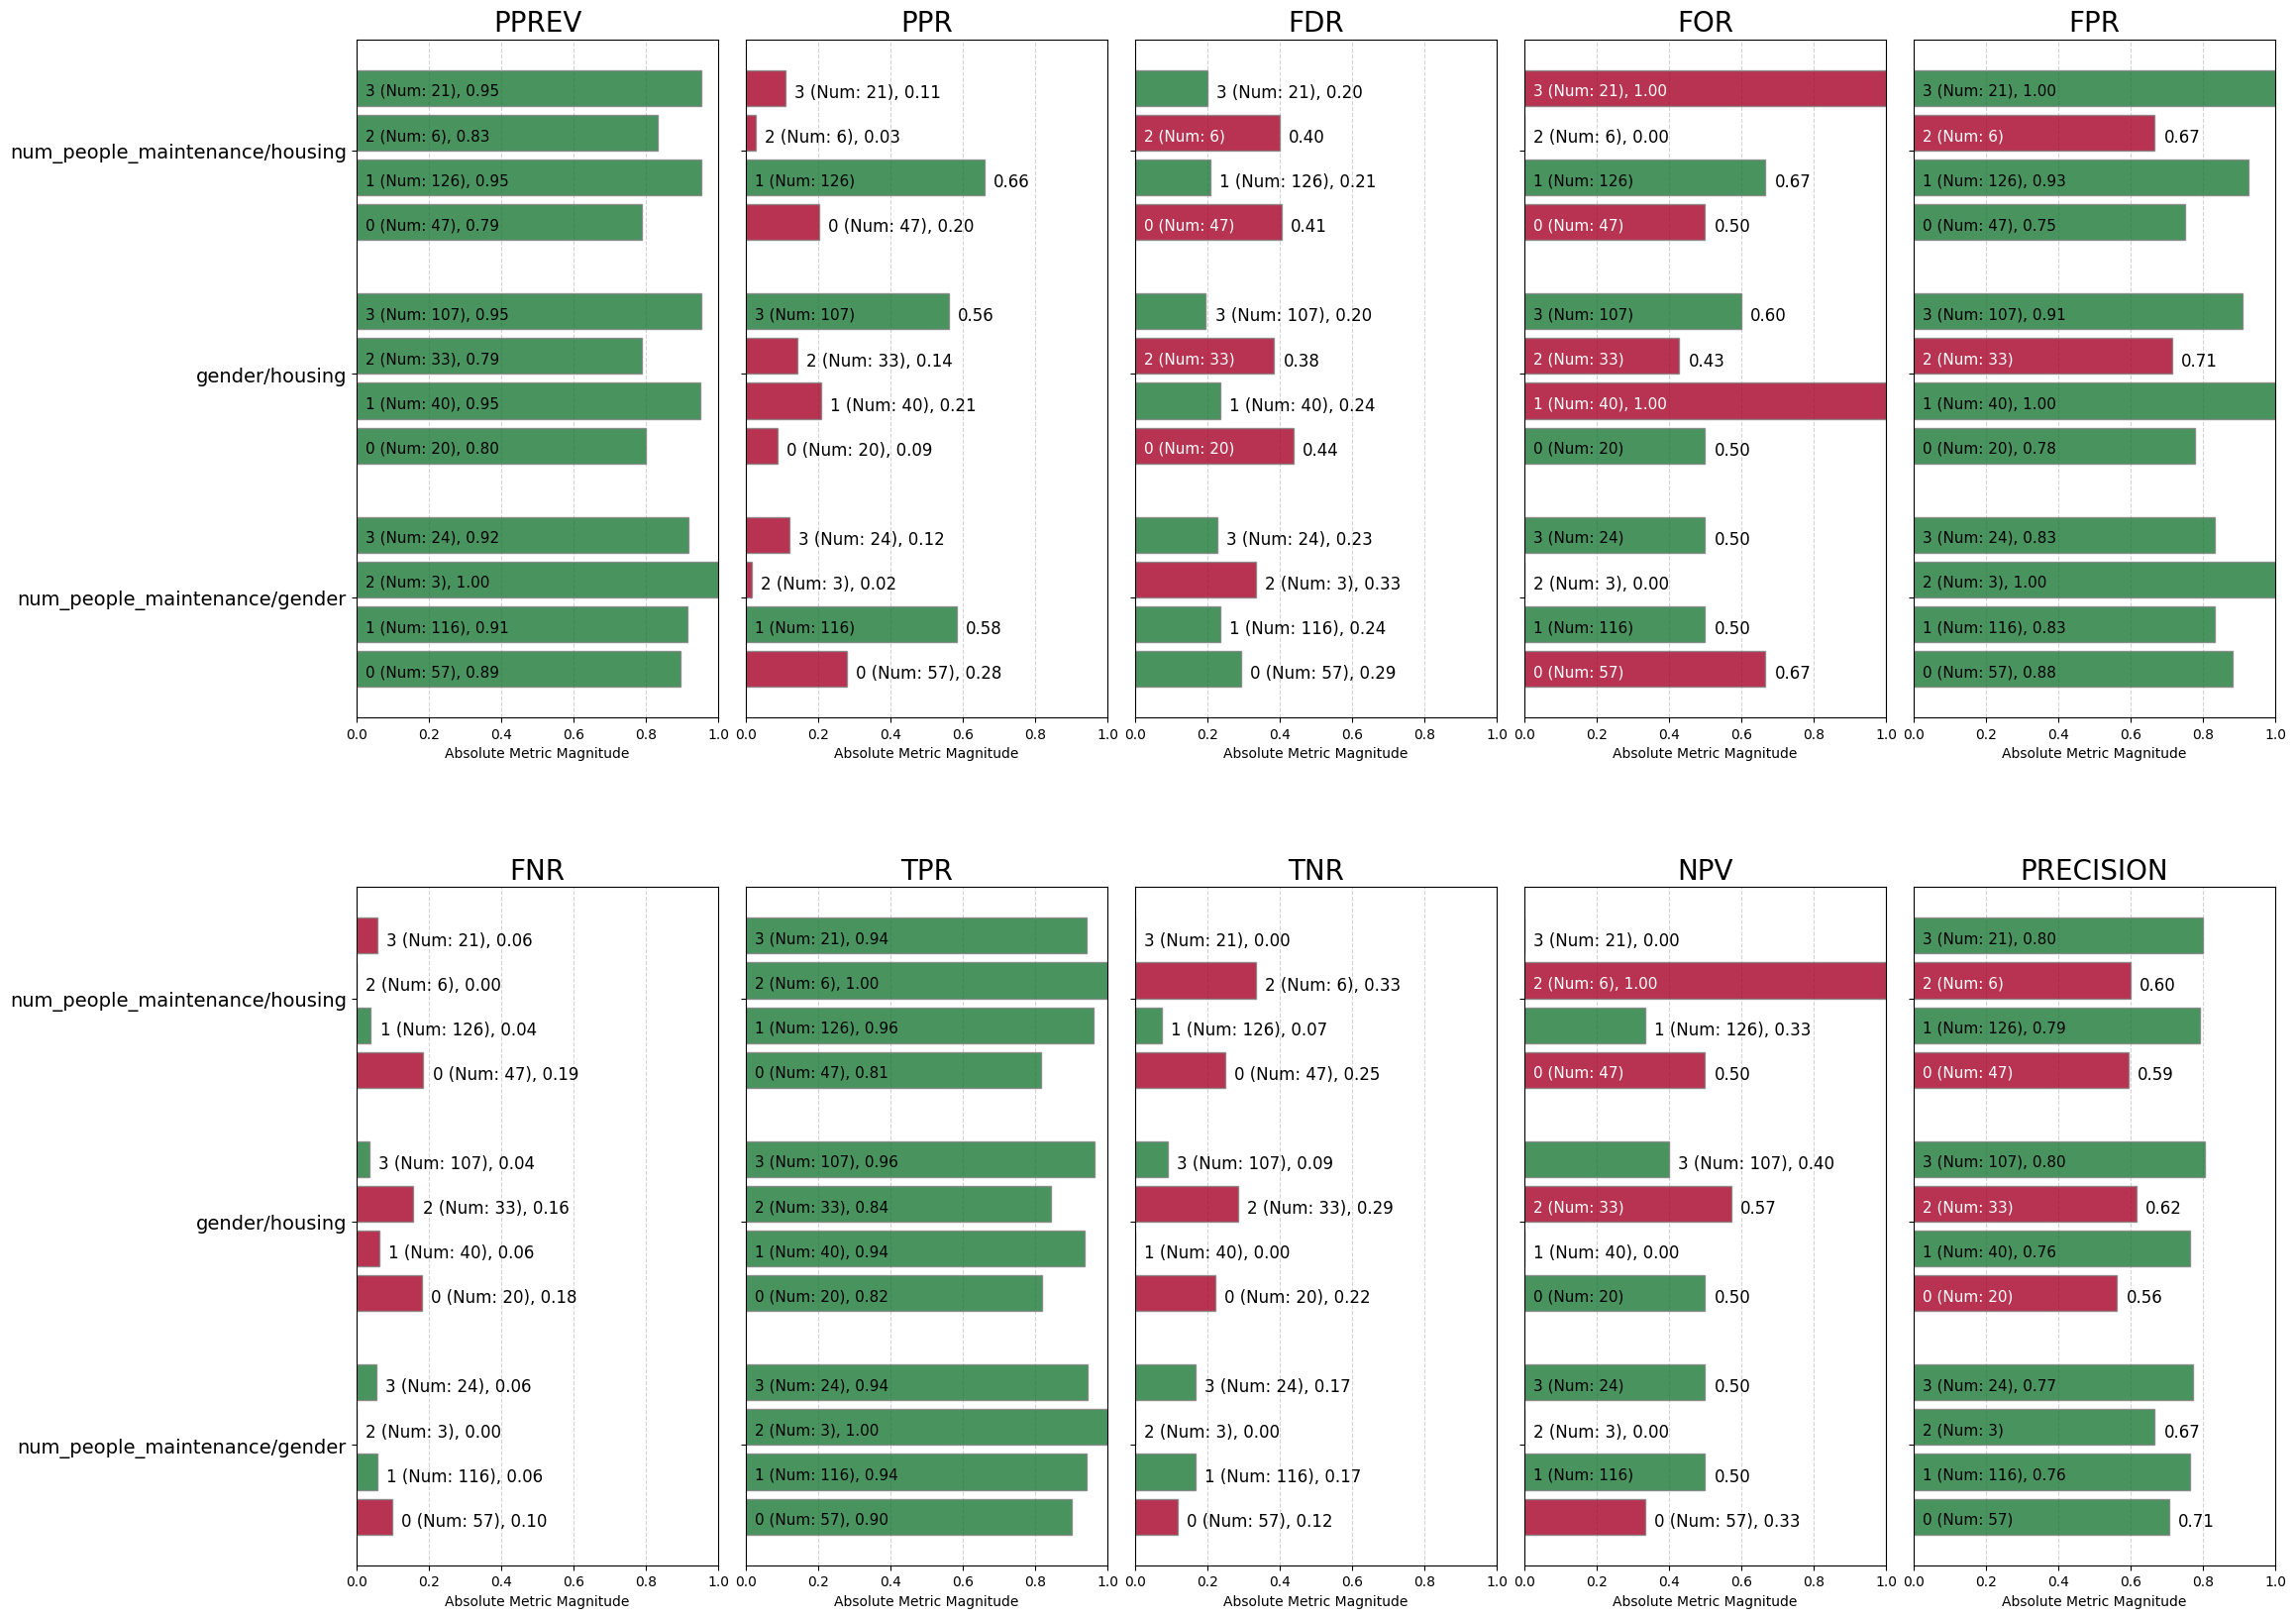

model_id score_threshold                  attribute_name  \
0         0      binary 0/1                  gender/housing   
1         0      binary 0/1   num_people_maintenance/gender   
2         0      binary 0/1  num_people_maintenance/housing   

   Statistical Parity  Impact Parity  FDR Parity  FPR Parity  FOR Parity  \
0               False           True       False       False       False   
1               False           True       False        True       False   
2               False           True       False       False       False   

   FNR Parity  TPR Parity  TNR Parity  NPV Parity  Precision Parity  \
0       False        True       False       False             False   
1       False        True       False       False              True   
2       False        True       False       False             False   

   TypeI Parity  TypeII Parity  Equalized Odds  Unsupervised Fairness  \
0         False          False           False                  False   
1         False          False            True                  False   
2         False          False           False                  False   

   Supervised Fairness  
0                False  
1                False  
2                False

score  label_value num_people_maintenance/gender gender/housing  \
993    1.0            1                             0              1   
568    1.0            1                             1              3   
844    1.0            0                             0              0   
372    1.0            0                             0              1   
283    1.0            0                             1              3   
..     ...          ...                           ...            ...   
424    0.0            1                             1              2   
247    0.0            1                             0              1   
736    0.0            0                             1              2   
927    0.0            0                             1              3   
485    0.0            0                             3              2   

    num_people_maintenance/housing  rank_abs  rank_pct  binary_score  \
993                              1         1     0.005             1   
568                              1         2     0.010             1   
844                              0         3     0.015             1   
372                              1         4     0.020             1   
283                              1         5     0.025             1   
..                             ...       ...       ...           ...   
424                              0       196     0.980             0   
247                              1       197     0.985             0   
736                              0       198     0.990             0   
927                              1       199     0.995             0   
485                              2       200     1.000             0   

     binary_fpr  binary_fnr  binary_fdr  binary_for  binary_npv  binary_ppr  \
993         0.0         NaN         0.0         NaN         NaN           1   
568         0.0         NaN         0.0         NaN         NaN           1   
844         1.0         NaN         1.0         NaN         NaN           1   
372         1.0         NaN         1.0         NaN         NaN           1   
283         1.0         NaN         1.0         NaN         NaN           1   
..          ...         ...         ...         ...         ...         ...   
424         NaN         1.0         NaN         1.0         1.0           0   
247         NaN         1.0         NaN         1.0         1.0           0   
736         NaN         0.0         NaN         0.0         0.0           0   
927         NaN         0.0         NaN         0.0         0.0           0   
485         NaN         0.0         NaN         0.0         0.0           0   

     binary_tnr  binary_tpr  binary_precision  binary_pprev  
993         0.0         NaN               0.0             1  
568         0.0         NaN               0.0             1  
844         1.0         NaN               1.0             1  
372         1.0         NaN               1.0             1  
283         1.0         NaN               1.0             1  
..          ...         ...               ...           ...  
424         NaN         1.0               NaN             0  
247         NaN         1.0               NaN             0  
736         NaN         0.0               NaN             0  
927         NaN         0.0               NaN             0  
485         NaN         0.0               NaN             0  

[200 rows x 18 columns]

<Figure size 640x480 with 0 Axes>

In [88]:
post_process_eq_ods(data=df_num_int, attributes=protected_attributes_int, target=target,list_of_disparities=list_of_disparities,priv=priv)

In [ ]:
plot_audit(df_test_int, ['gender/housing'])
plot_audit(y_test_post_fl, ['gender/housing'])
plot_audit(y_test_post_aeq, ['gender/housing'])

plot_audit(df_test_int, ['num_people_maintenance/gender'])
plot_audit(y_test_post_fl2, ['num_people_maintenance/gender'])
plot_audit(y_test_post_aeq2, ['num_people_maintenance/gender'])


plot_audit(df_test_int, ['num_people_maintenance/housing'])
plot_audit(y_test_post_fl3, ['num_people_maintenance/housing'])
plot_audit(y_test_post_aeq3, ['num_people_maintenance/housing'])

In [ ]:
index = 4 
plt.figure(figsize=(10, 6))
accuracy_scores = {}
accuracy_scores["Orignal dataset"] = {"Catboost": 0.79, "RandomForest":0.78, "DecisionTree":0.77, "LR":0.76}
accuracy_scores["Intersectional dataset"] = {"Catboost": 0.8, "RandomForest":0.78, "DecisionTree":0.76, "LR":0.76}
accuracy_scores["Massaging method"] = {"Catboost": 0.92, "RandomForest":0.87, "DecisionTree":0.86, "LR":0.83}
accuracy_scores["Prevelance Sampling"] = {"Catboost": 0.77, "RandomForest":0.75, "DecisionTree":0.73, "LR":0.73}
accuracy_scores["Data repairer"] = {"Catboost": 0.78, "RandomForest":0.76, "DecisionTree":0.75, "LR":0.76}

accuracy_df = pd.DataFrame(accuracy_scores).T
# Set the plot style
sns.set(style="whitegrid")
sns.set_palette("blend:#7AB,#EDA")
# Plot each method's accuracy scores
accuracy_df.plot(kind='bar', figsize=(10, 6))

# Add title and labels
plt.title("Accuracy Scores by Dataset and Model", fontsize=16)
plt.xlabel("Method", fontsize=12)
plt.ylabel("Accuracy Score", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
metrics_rf = {}
metrics_rf["Initial dataset"] = metrics_dict_int["RandomForest"]['gender/housing']
metrics_rf["Prevelance Sampling"] = metrics_ps_dict["RandomForest"]['gender/housing']
metrics_rf["Massaging"] = metrics_ms_dict["RandomForest"]['gender/housing']
metrics_rf["Data repairer"] = metrics_dr_dict["RandomForest"]['gender/housing']
plot_metrics(metrics_rf,'gender/housing')

metrics_rf = {}
metrics_rf["Initial dataset"] = metrics_dict_int["RandomForest"]['num_people_maintenance/gender']
metrics_rf["Prevelance Sampling"] = metrics_ps_dict["RandomForest"]['num_people_maintenance/gender']
metrics_rf["Massaging"] = metrics_ms_dict["RandomForest"]['num_people_maintenance/gender']
metrics_rf["Data repairer"] = metrics_dr_dict["RandomForest"]['num_people_maintenance/gender']
plot_metrics(metrics_rf,'num_people_maintenance/gender')

metrics_rf = {}
metrics_rf["Initial dataset"] = metrics_dict_int["RandomForest"]['num_people_maintenance/housing']
metrics_rf["Prevelance Sampling"] = metrics_ps_dict["RandomForest"]['num_people_maintenance/housing']
metrics_rf["Massaging"] = metrics_ms_dict["RandomForest"]['num_people_maintenance/housing']
metrics_rf["Data repairer"] = metrics_dr_dict["RandomForest"]['num_people_maintenance/housing']
plot_metrics(metrics_rf,'num_people_maintenance/housing')